![title](./00_titleimage.png)
## Predicting Employee Attrition
---
- IBM 데이터 과학자들이 만든 가상의 HR 데이터셋입니다.
- 1,470명에 대한 35개의 변수가 기록되어 있고, 종속변수는 <b>Attrition</b>, 즉 0 또는 1의 퇴사 여부입니다.
- Data Source: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

## 순서
0. 패키지 import
1. 데이터 설명 및 전처리
2. EDA
3. 가설확인
4. Feature Engineering
5. 예측을 위한 데이터 처리
6. 머신러닝 알고리즘을 이용한 퇴사자 예측
7. 이후의 방향

## 0. 패키지 import
---
### 0.1 필요한 패키지 import

In [8]:
from collections import OrderedDict

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier


# 모델 import
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm
import graphviz
import pydotplus

# EDA package
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl


# warnings 끄기
warnings.filterwarnings('ignore')

# pandas display option view row & columns
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 1000)

# # matplotlib set
plt.rc('font', family='DejaVu Sans')  # For MacOS
plt.rc('axes', unicode_minus=False)

%matplotlib inline

<br>

## 1. 데이터 설명 및 전처리
---

### 1.1 데이터 로드 및 체크

In [9]:
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.tail()

Age Attrition     BusinessTravel  DailyRate              Department  \
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeCount  \
1465                23          2        Medical              1   
1466                 6          1        Medical              1   
1467                 4          3  Life Sciences              1   
1468                 2          3        Medical              1   
1469                 8          3        Medical              1   

      EmployeeNumber  EnvironmentSatisfaction Gender  HourlyRate  \
1465            2061                        3   Male          41   
1466            2062                        4   Male          42   
1467            2064                        2   Male          87   
1468            2065                        4   Male          63   
1469            2068                        2   Male          82   

      JobInvolvement  JobLevel                    JobRole  JobSatisfaction  \
1465               4         2      Laboratory Technician                4   
1466               2         3  Healthcare Representative                1   
1467               4         2     Manufacturing Director                2   
1468               2         2            Sales Executive                2   
1469               4         2      Laboratory Technician                3   

     MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked Over18  \
1465       Married           2571        12290                   4      Y   
1466       Married           9991        21457                   4      Y   
1467       Married           6142         5174                   1      Y   
1468       Married           5390        13243                   2      Y   
1469       Married           4404        10228                   2      Y   

     OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  \
1465       No                 17                  3                         3   
1466       No                 15                  3                         1   
1467      Yes                 20                  4                         2   
1468       No                 14                  3                         4   
1469       No                 12                  3                         1   

      StandardHours  StockOptionLevel  TotalWorkingYears  \
1465             80                 1                 17   
1466             80                 1                  9   
1467             80                 1                  6   
1468             80                 0                 17   
1469             80                 0                  6   

      TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
1465                      3                3               5   
1466                      5                3               7   
1467                      0                3               6   
1468                      3                2               9   
1469                      3                4               4   

      YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
1465                   2                        0                     3  
1466                   7                        1                     7  
1467                   2                        0                     3  
1468                   6                        0                     8  
1469                   3                        1                     2

1. Age : 해당 직원의 나이
2. Attrition : 퇴직 여부 Target값 (종속변수)
3. BusinessTravel : 출장의 빈도
4. DailyRate : 일 대비 급여의 수준
5. Department : 업무분야
6. DistanceFromHome : 집과의 거리
7. Education : 교육의 정도
    - 1 : 'Below College' : 대학 이하
    - 2 : 'College' : 전문대
    - 3 : 'Bachelor' : 학사
    - 4 : 'Master' : 석사
    - 5 : 'Doctor' : 박사
8. EducationField : 전공
9. EmployeeCount : 직원 숫자
10. EmployeeNumber : 직원 ID
11. EnvironmentSatisfaction : 업무 환경에 대한 만족도
    - 1 : 'Low'
    - 2 : 'Medium'
    - 3 : 'High'
    - 4 : 'Very High'
12. Gender : 성별
13. HourlyRate : 시간 대비 급여의 수준
14. JobInvolvement : 업무 참여도
    - 1 : 'Low'
    - 2 : 'Medium'
    - 3 : 'High'
    - 4 : 'Very High'
15. JobLevel : 업무의 수준
16. JobRole : 업무 종류
17. JobSatisfaction : 업무 만족도
    - 1 : 'Low'
    - 2 : 'Medium'
    - 3 : 'High'
    - 4 : 'Very High'
18. MaritalStatus : 결혼 여부
19. MonthlyIncome : 월 소득
20. MonthlyRate : 월 대비 급여 수준
21. NumCompaniesWorked : 일한 회사의 수
22. Over18 : 18세 이상
23. OverTime : 규정외 노동시간
24. PercentSalaryHike : 급여의 증가분 백분율
25. PerformanceRating : 업무 성과
    - 1 : 'Low'
    - 2 : 'Good'
    - 3 : 'Excellent'
    - 4 : 'Outstanding'
26. RelationshipSatisfaction : 대인관계 만족도
    - 1 : 'Low'
    - 2 : 'Medium'
    - 3 : 'High'
    - 4 : 'Very High'
27. StandardHours : 표준 시간
28. StockOptionLevel : 스톡옵션 정도
29. TotalWorkingYears : 경력 기간
30. TrainingTimesLastYear : 교육 시간
31. WorkLifeBalance : 일과 생활의 균형 정도
    - 1 : 'Bad'
    - 2 : 'Good'
    - 3 : 'Better'
    - 4 : 'Best'
32. YearsAtCompany : 근속 연수
33. YearsInCurrentRole : 현재 역할의 년수
34. YearsSinceLastPromotion : 마지막 프로모션
35. YearsWithCurrManager : 현재 관리자와 함께 보낸 시간

- 총 독립변수 : 34개, 종속변수 1개 확인 됩니다.

<br>

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

- Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, WorkLifeBalance, JobLevel, StockOptionLevel, NumCompaniesWorked
- 위의 컬럼들이 실제론 Category column인데, int형으로 되어있습니다.
- int형 컬럼들을 Category 컬럼으로 바꿔주어야 EDA 할때 조금더 편합니다. \<int형 26개, category형 9개>

<br>

### 1.2 EDA를 쉽게하기 위해 데이터값을 Object로 변경

In [11]:
# Education
change_dict = {1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'}
data.replace({'Education': change_dict}, inplace=True)
data['Education'].unique()

array(['College', 'Below College', 'Master', 'Bachelor', 'Doctor'],
      dtype=object)

In [12]:
# EnvironmentSatisfaction
change_dict = {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
data.replace({'EnvironmentSatisfaction': change_dict}, inplace=True)
data['EnvironmentSatisfaction'].unique()

array(['Medium', 'High', 'Very High', 'Low'], dtype=object)

In [13]:
# JobInvolvement
change_dict = {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
data.replace({'JobInvolvement': change_dict}, inplace=True)
data['JobInvolvement'].unique()

array(['High', 'Medium', 'Very High', 'Low'], dtype=object)

In [14]:
# JobSatisfaction
change_dict = {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
data.replace({'JobSatisfaction': change_dict}, inplace=True)
data['JobSatisfaction'].unique()

array(['Very High', 'Medium', 'High', 'Low'], dtype=object)

In [15]:
# PerformanceRating
change_dict = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
data.replace({'PerformanceRating': change_dict}, inplace=True)
data['PerformanceRating'].unique()

array(['Excellent', 'Outstanding'], dtype=object)

In [16]:
# RelationshipSatisfaction
change_dict = {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
data.replace({'RelationshipSatisfaction': change_dict}, inplace=True)
data['RelationshipSatisfaction'].unique()

array(['Low', 'Very High', 'Medium', 'High'], dtype=object)

In [17]:
# WorkLifeBalance
change_dict = {1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'}
data.replace({'WorkLifeBalance': change_dict}, inplace=True)
data['WorkLifeBalance'].unique()

array(['Bad', 'Better', 'Good', 'Best'], dtype=object)

In [18]:
# JobLevel, StockOptionLevel, TrainingTimesLastYear, NumCompaniesWorked, TotalWorkingYears
data = data.astype({'JobLevel': object, 'StockOptionLevel': object, 'NumCompaniesWorked': object})
data

Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome      Education EducationField  EmployeeCount  \
0                    1        College  Life Sciences              1   
1                    8  Below College  Life Sciences              1   
2                    2        College          Other              1   
3                    3         Master  Life Sciences              1   
4                    2  Below College        Medical              1   
...                ...            ...            ...            ...   
1465                23        College        Medical              1   
1466                 6  Below College        Medical              1   
1467                 4       Bachelor  Life Sciences              1   
1468                 2       Bachelor        Medical              1   
1469                 8       Bachelor        Medical              1   

      EmployeeNumber EnvironmentSatisfaction  Gender  HourlyRate  \
0                  1                  Medium  Female          94   
1                  2                    High    Male          61   
2                  4               Very High    Male          92   
3                  5               Very High  Female          56   
4                  7                     Low    Male          40   
...              ...                     ...     ...         ...   
1465            2061                    High    Male          41   
1466            2062               Very High    Male          42   
1467            2064                  Medium    Male          87   
1468            2065               Very High    Male          63   
1469            2068                  Medium    Male          82   

     JobInvolvement JobLevel                    JobRole JobSatisfaction  \
0              High        2            Sales Executive       Very High   
1            Medium        2         Research Scientist          Medium   
2            Medium        1      Laboratory Technician            High   
3              High        1         Research Scientist            High   
4              High        1      Laboratory Technician          Medium   
...             ...      ...                        ...             ...   
1465      Very High        2      Laboratory Technician       Very High   
1466         Medium        3  Healthcare Representative             Low   
1467      Very High        2     Manufacturing Director          Medium   
1468         Medium        2            Sales Executive          Medium   
1469      Very High        2      Laboratory Technician            High   

     MaritalStatus  MonthlyIncome  MonthlyRate NumCompaniesWorked Over18  \
0           Single           5993        19479                  8      Y   
1          Married           5130        24907                  1      Y   
2           Single           2090         2396                  6      Y   
3          Married           2909        23159                  1      Y   
4          Married           3468        16632                  9      Y   
...            ...            ...          ...        

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

- EDA 과정을 하기 위해 Category Columns는 object 형식으로 변환함
- \<int형 16개, Category형 19개>

<br>

### 1.3 결측치 확인

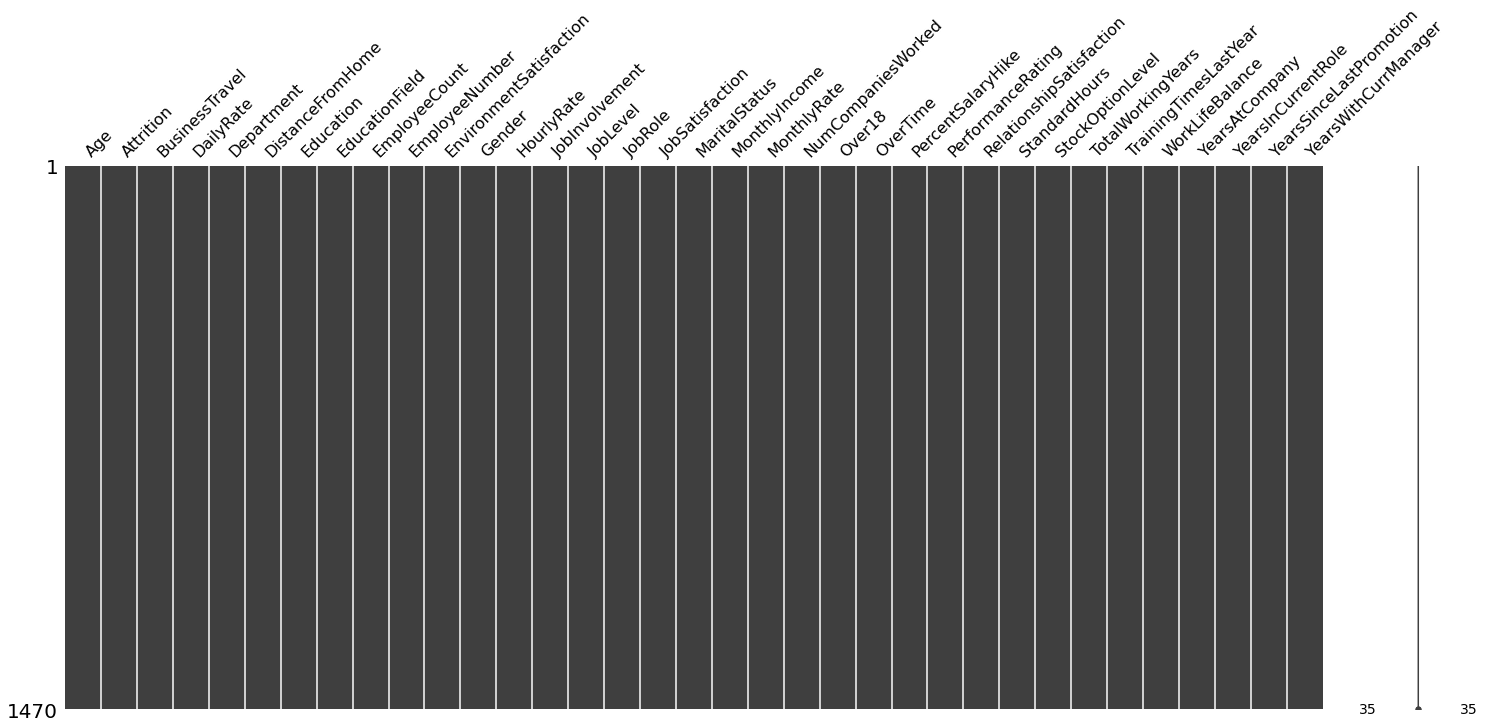

In [20]:
missingno.matrix(data)
plt.show()

- Missingno 패키지를 통해 Null 데이터가 있는지 시각화 해보았습니다.
- 총 1470 데이터 중에 Null 데이터는 없는것으로 확인됩니다.
- 만일 있다면 중간값, 삭제, 평균 값 등으로 채워주거나 혹은 해당 데이터 행 자체를 삭제 해야합니다.
- 만일 Null data를 임의적으로 0혹은 999와 같이 일괄적인 값으로 채워넣었다면 여기서 확인은 어렵습니다.

<br>

## 2. EDA
---
### 2.1 가설 설정 - 누가 퇴사를 할것인가?
- 일단 퇴사를 할것 같은 사람들 간단한 도메인 지식을 활용하여 가설설정하였음.
- 가설1 : 집과 회사의 거리가 먼 사람들이 퇴사를 많이 할것이다.
- 가설2 : 월급여가 낮은 사람이 퇴사를 많이 할것이다.
- 가설3 : 업무환경이 안좋은 사람이 퇴사를 할것이다.
- 가설4 : 워라벨이 안좋은 사람들이 퇴사를 할것이다.
- 가설5 : 근무부서에 따른 퇴사의 비율이 다를것이다. 즉, 특정부서가 퇴사율이 높을것이다.
- 가설6 : 초기 경력자들이 퇴직을 많이 할것이다.

<br>

### 2.2 Target 확인

In [21]:
print('Attrition 비율')
print(f'{data.Attrition.value_counts().index[0]} : {round(data.Attrition.value_counts()[0] / len(data), 2) * 100}%')
print(f'{data.Attrition.value_counts().index[1]} : {round(data.Attrition.value_counts()[1] / len(data), 2) * 100}%')

Attrition 비율
No : 84.0%
Yes : 16.0%


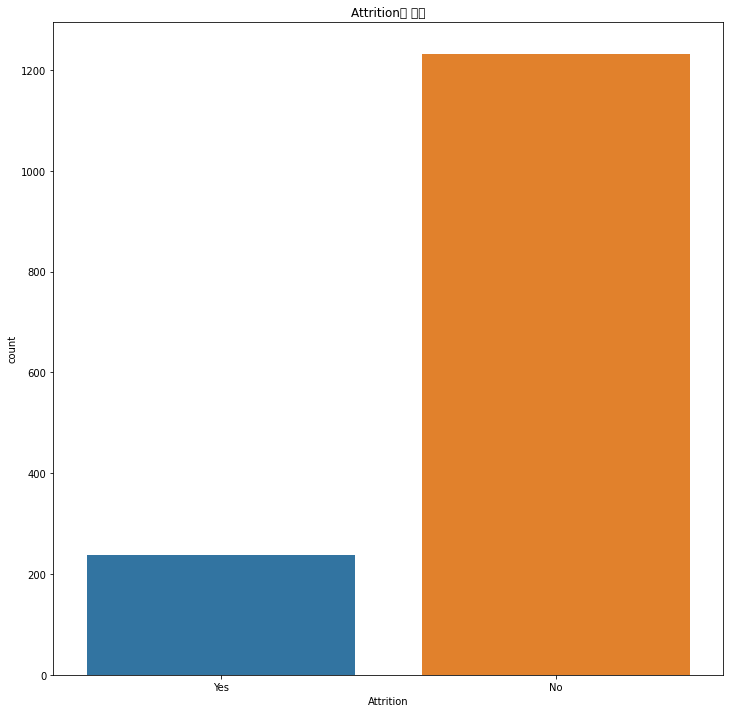

In [22]:
plt.figure(figsize = (12,12))
sns.countplot(x = data['Attrition'])
plt.title('Attrition의 분포')
plt.show()

- 퇴사자의 분포는 전체 데이터의 약 16%를 차지하는것을 알수 있었습니다.

<br>

### 2.3 전체 컬럼 분포 확인

#### 2.3.1 카테고리형 컬럼

In [23]:
# category column
cate_cols = []
for column in data.columns:
    if data[column].dtype == object:
        cate_cols.append(column)
        print('=============================================================================================')
        print(f'{column} : {data[column].unique()}')
        print(f'{data[column].value_counts()}')
        print()
        
print()
print(f'object column의 갯수 : {len(cate_cols)} 개')

Attrition : ['Yes' 'No']
No     1233
Yes     237
Name: Attrition, dtype: int64

BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

Department : ['Sales' 'Research & Development' 'Human Resources']
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

Education : ['College' 'Below College' 'Master' 'Bachelor' 'Doctor']
Bachelor         572
Master           398
College          282
Below College    170
Doctor            48
Name: Education, dtype: int64

EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

EnvironmentSatisfaction : ['Medium' 'High' 'Very High' 'Low']


- 총 19개의 Category형 컬럼의 값들을 확인해 보았습니다.
- 그중 Over18 컬럼이 Y값 하나만을 가지고 있을것을 알수 있었으며, 그 외 다른 컬럼은 큰 이상이 없어 보입니다.

<br>

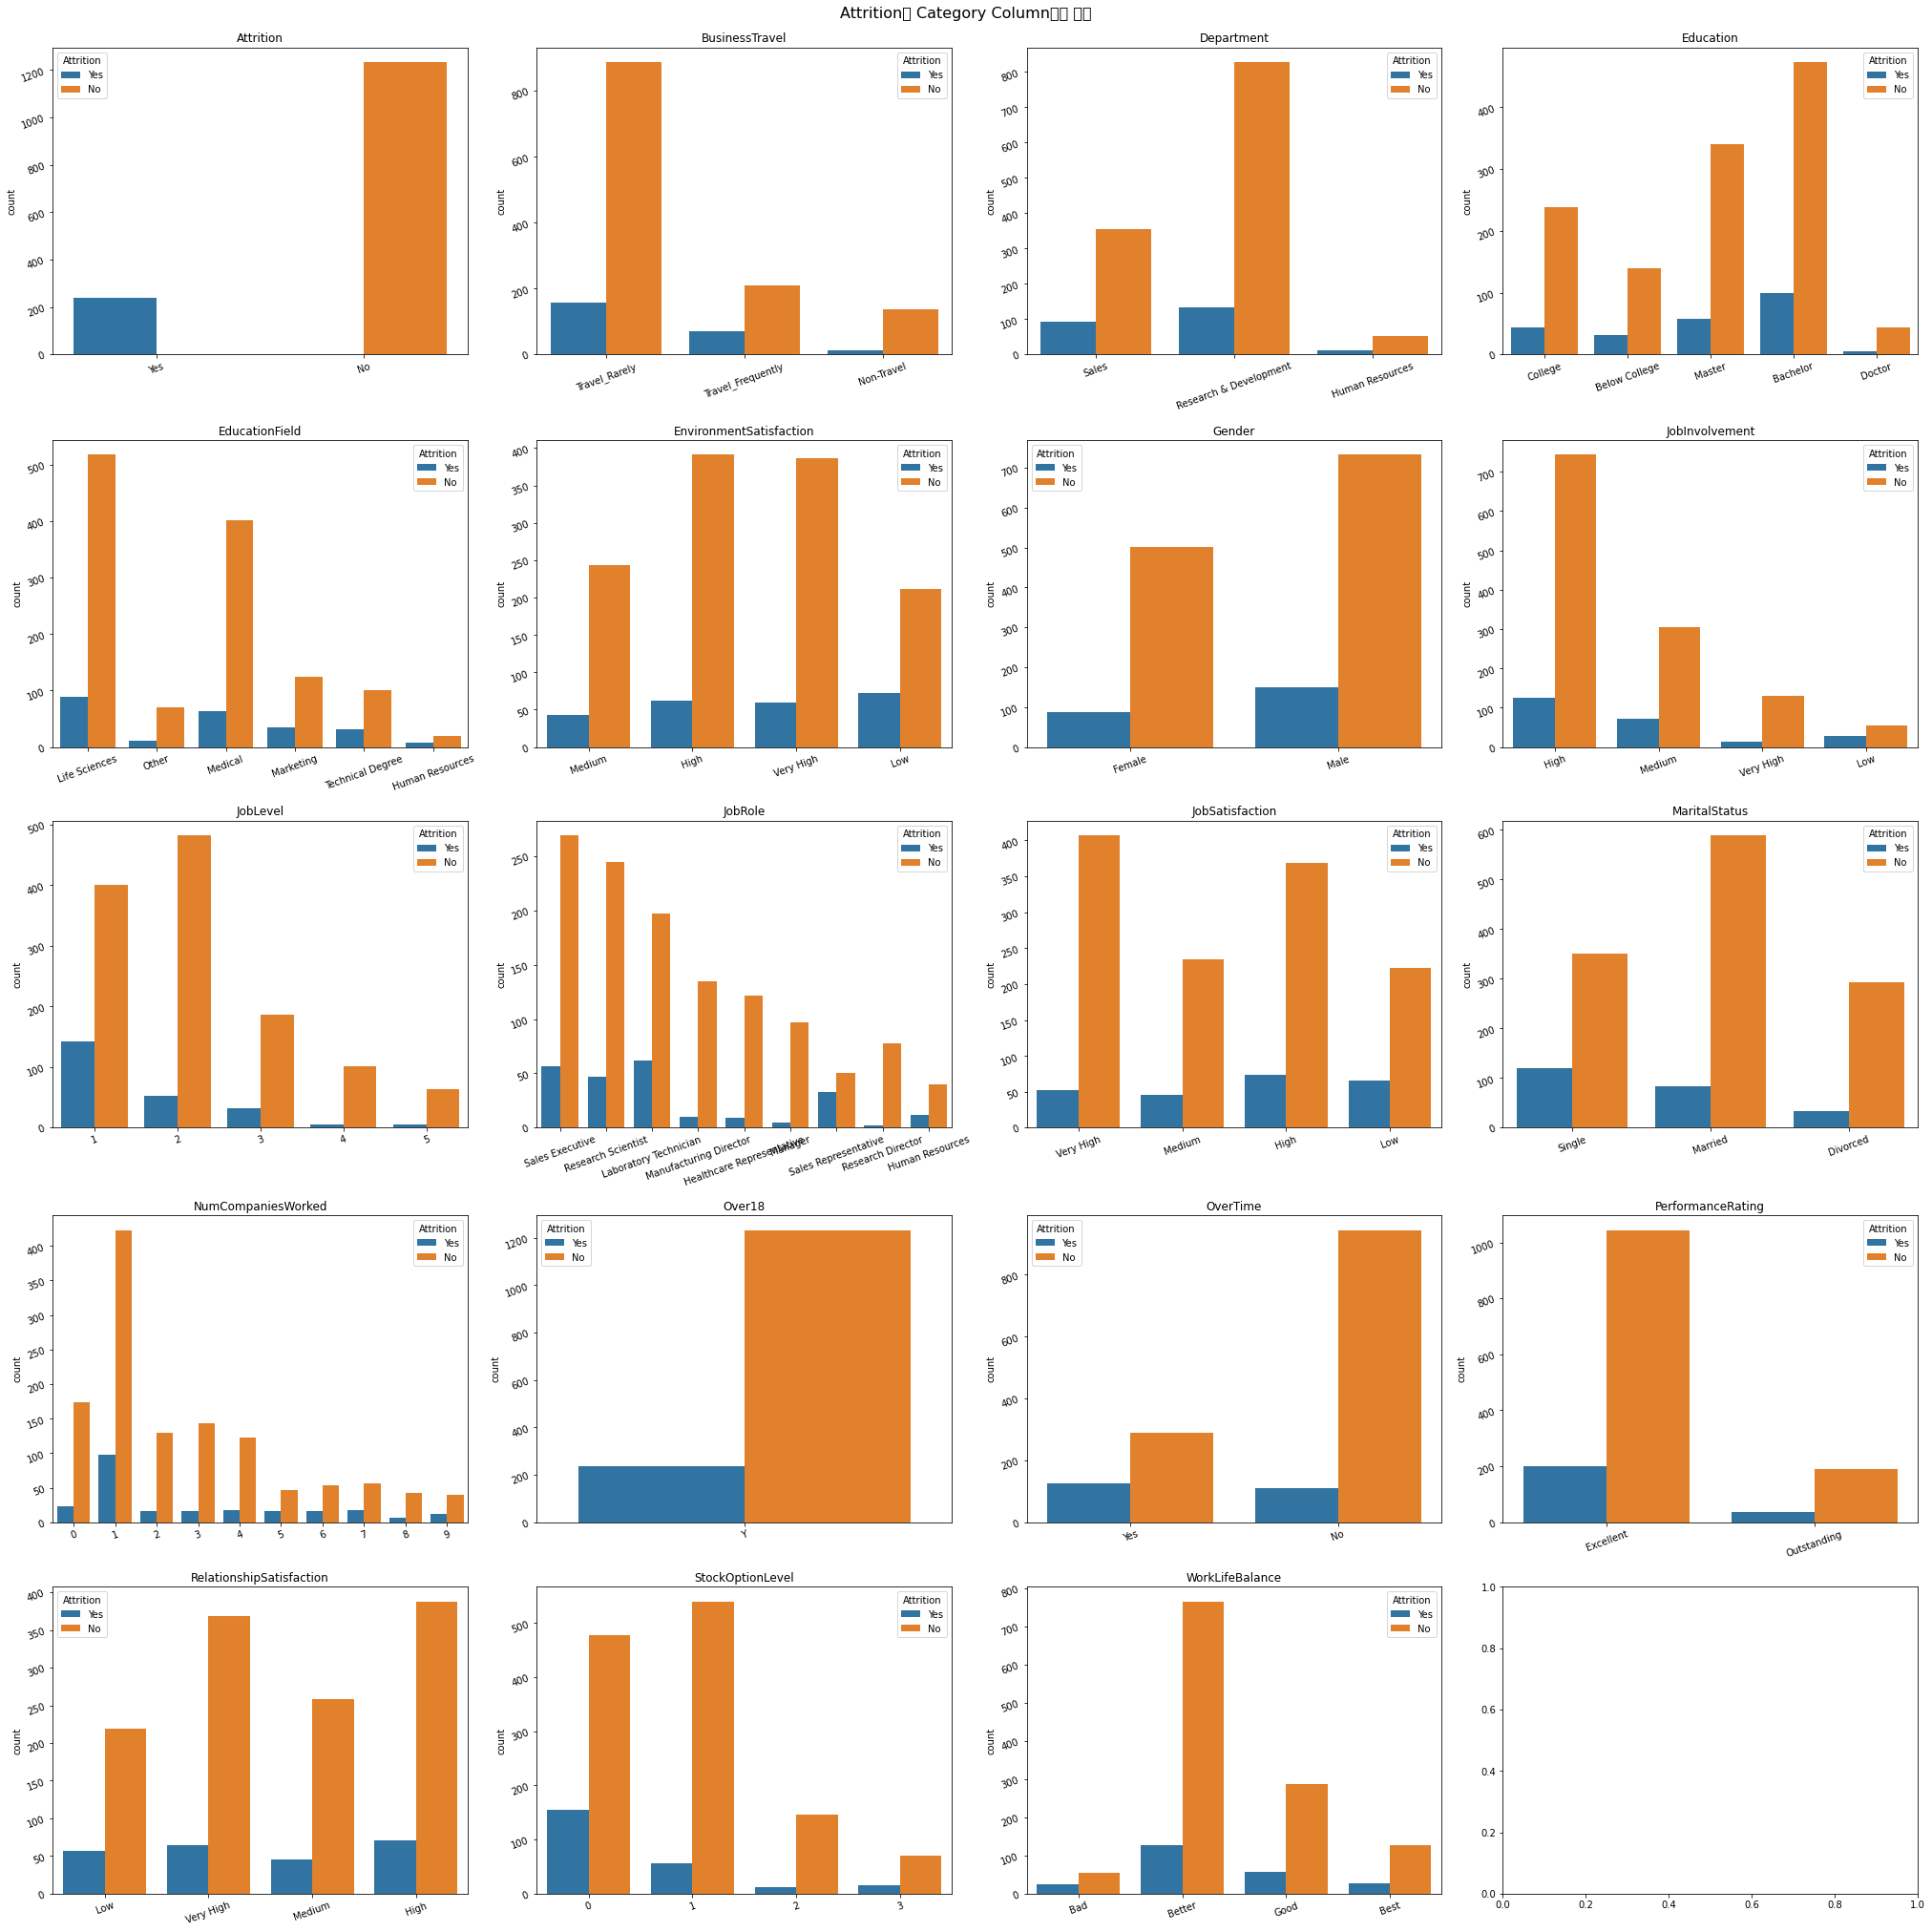

In [24]:
# category column 그래프로 보기
fig, ax = plt.subplots(5, 4, figsize=(28, 28), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Attrition과 Category Column들의 분포', fontsize=16)

for i in range(len(cate_cols)):
    sns.countplot(x=cate_cols[i], data=data,
                      hue='Attrition', ax=ax[i]).set(xlabel = None)
    ax[i].set(title = cate_cols[i])
    
    if data[cate_cols[1]].nunique() >= 3:
        ax[i].tick_params(labelrotation=20)
        
plt.show()

- 요약 데이터를 그래프로 시각화 해보았습니다.
- Department(근무부서) : 근무부서에 따라 퇴사 여부가 달라짐이 보입니다. 일단 눈으로 볼땐 HR부서가 가장 적어보이지만, 모수가 적기 때문에 자세히 확인해볼 필요가 있습니다.
- EnvironmentSatisfaction(근무환경 만족도) : 근무환경 만족도에 따라서 퇴사 여부가 확인될듯 싶었는데, 아래에서 자세히 확인해봐야할듯 싶습니다.
- JobSatisfaction(직업 만족도) : 직업 만족에 따른 퇴사 여부도 확인해 보아야겠습니다.
- StockOptionLevel(스톡옵션 레벨) : 스톡옵션이 없거나 낮은 직원이 많이 떠나는것으로 보입니다. 확인해볼 필요가 있어 보입니다.
- WorkLifeBalance(워라벨의 정도) : 워라벨이 중요한 사람들은 퇴사를 많이하는지 확인이 필요합니다. 만일 그렇다면 해당 회사는 워라벨이 좋지 않은 회사 인듯 합니다.

<br>

#### 2.3.2 연속형 컬럼 확인

In [25]:
# continuous column
cont_cols = []
for column in data.columns:
    if data[column].dtype != object:
        cont_cols.append(column)
        print(f'{column} : {data[column].nunique()}')
        print('==============================')
print()
print(f'연속형 column의 갯수 : {len(cont_cols)} 개')

Age : 43
DailyRate : 886
DistanceFromHome : 29
EmployeeCount : 1
EmployeeNumber : 1470
HourlyRate : 71
MonthlyIncome : 1349
MonthlyRate : 1427
PercentSalaryHike : 15
StandardHours : 1
TotalWorkingYears : 40
TrainingTimesLastYear : 7
YearsAtCompany : 37
YearsInCurrentRole : 19
YearsSinceLastPromotion : 16
YearsWithCurrManager : 18

연속형 column의 갯수 : 16 개


- int형 컬럼을 요약해보니, EmployeeCount, StandardHours는 값이 1개로 되어 있어서, 삭제가 필요합니다.
- EmployeeNumber는 값이 1470개로 모든 Row마다 값이 유니크함으로, 삭제가 필요합니다.
- 눈으로 쉽게 보기 위해 그래프로 그려보겠습니다.

<br>

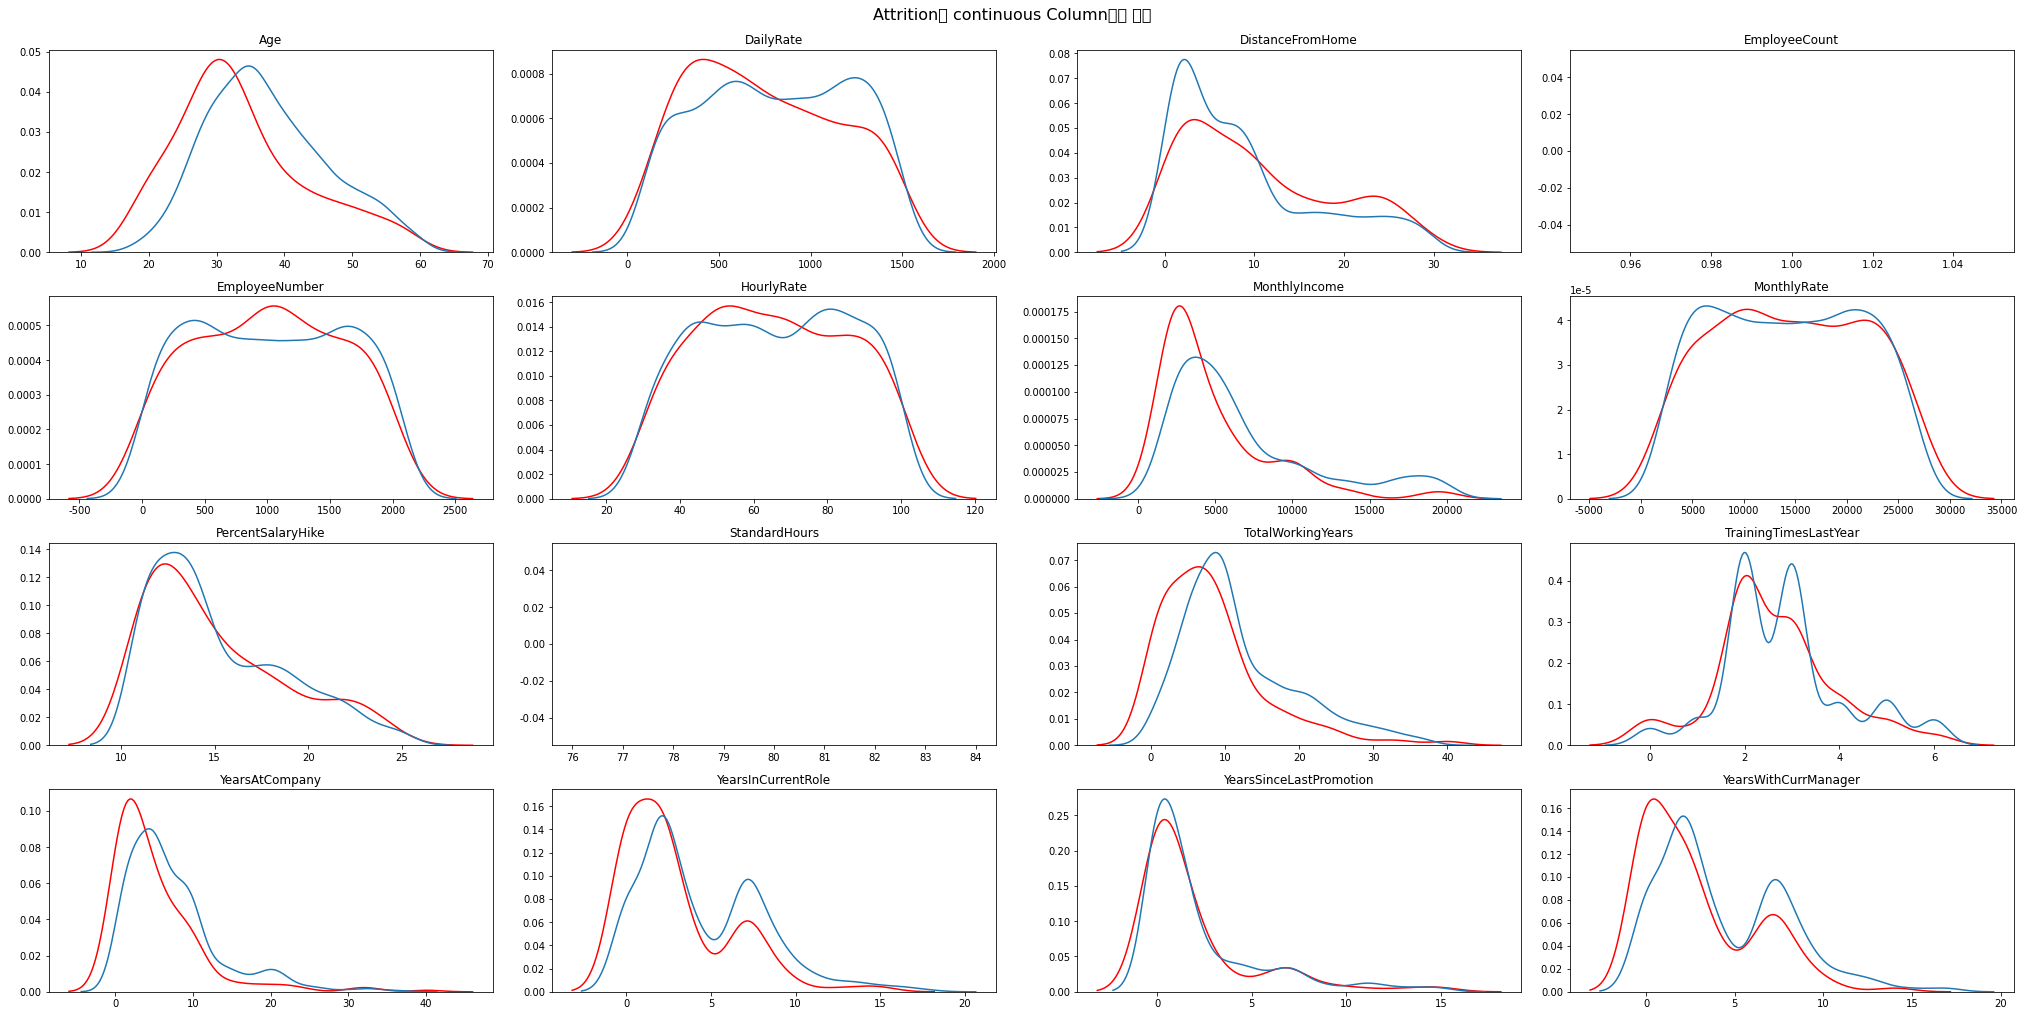

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(28, 14), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Attrition과 continuous Column들의 분포', fontsize=16)

for i in range(len(cont_cols)):
    sns.distplot(data[data['Attrition'] == 'Yes'][cont_cols[i]], color='Red', ax=ax[i], hist = False).set(xlabel = None, ylabel = None)
    sns.distplot(data[data['Attrition'] == 'No'][cont_cols[i]], ax=ax[i],hist = False).set(xlabel = None, ylabel = None)
    ax[i].set(title = cont_cols[i])
    
plt.show()

- 밀도 그래프를 그려보았습니다. 빨간색은 퇴사한 사람들에 대한 그래프이고 파란색은 반대입니다.
- 밀도 그래프만으로는 부족해보여 박스그래프도 그려보겠습니다.

<br>

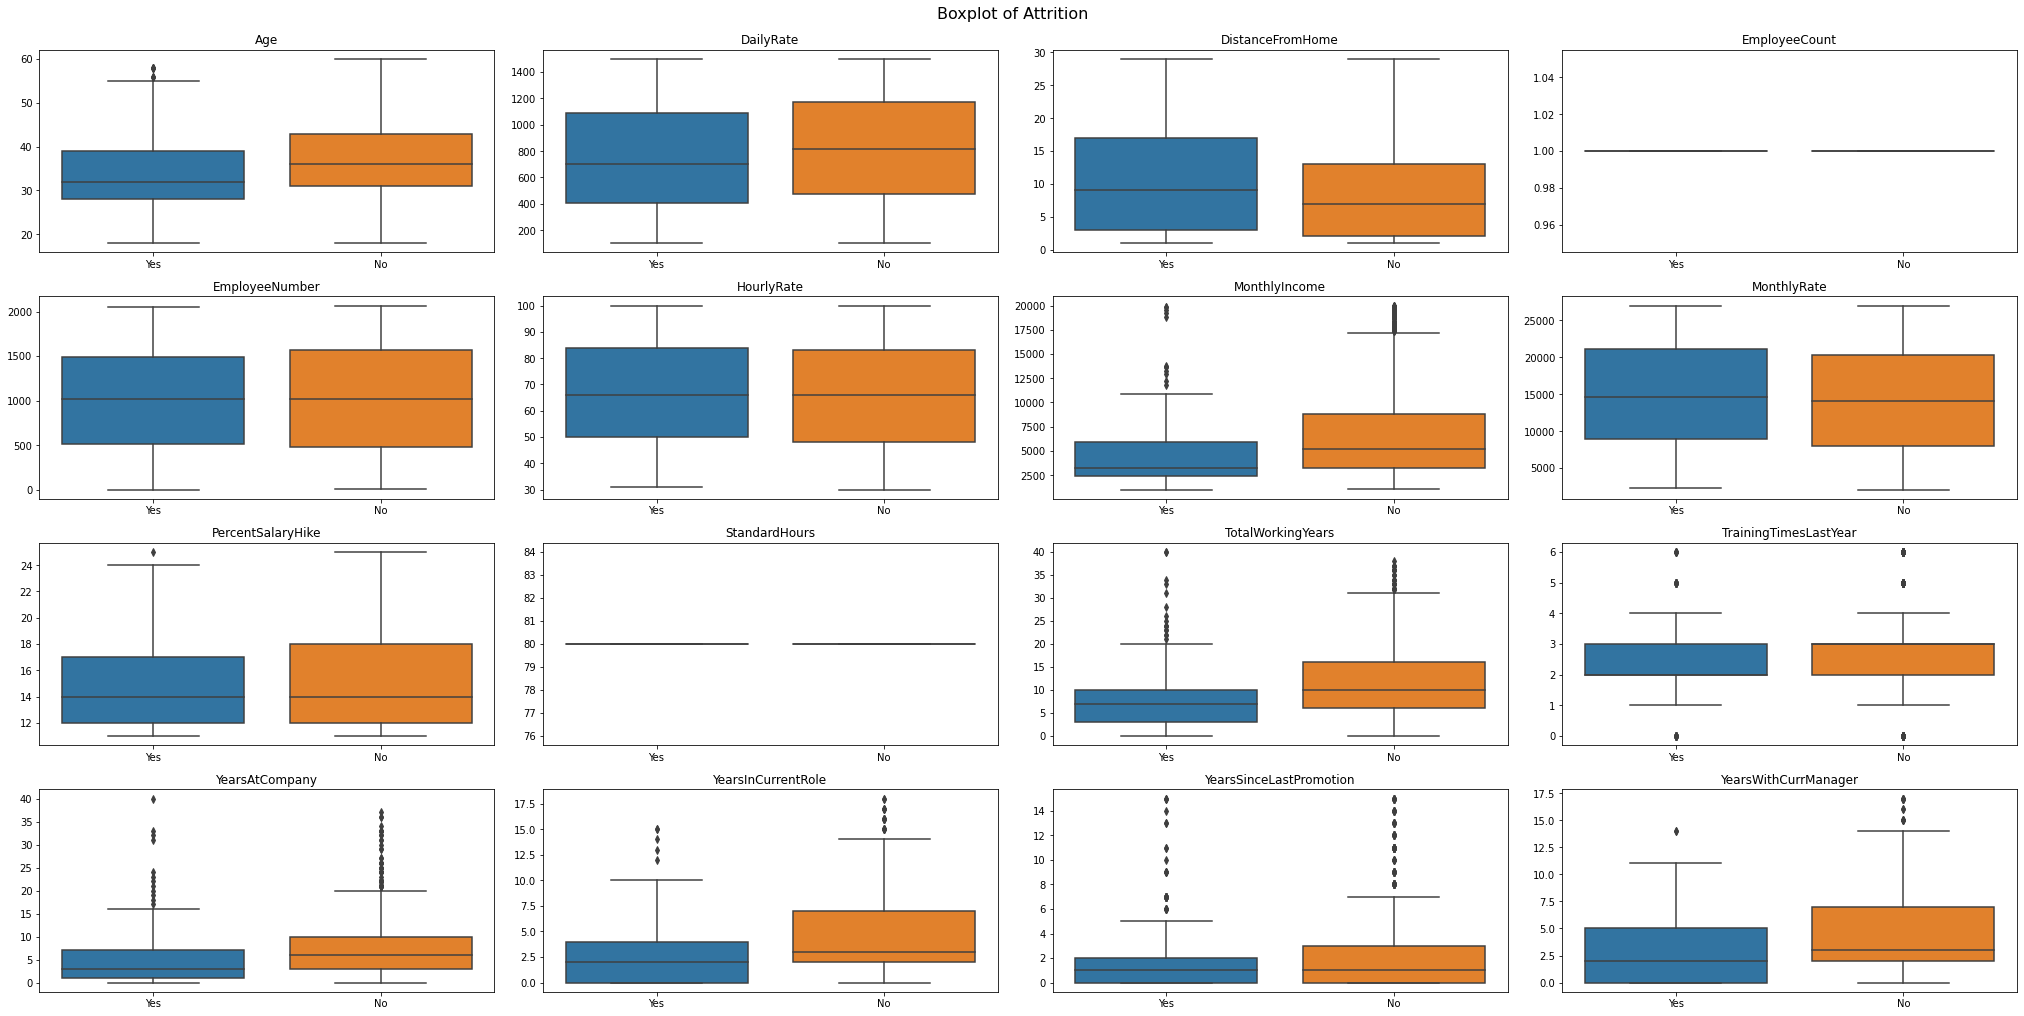

In [27]:
# boxplot
fig, ax = plt.subplots(4, 4, figsize=(28, 14), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Boxplot of Attrition', fontsize=16)

for i in range(len(cont_cols)):
    ax[i].set(title = cont_cols[i])
    sns.boxplot(x=data['Attrition'], y = data[cont_cols[i]], ax=ax[i]).set(xlabel=None,  ylabel=None)
    
plt.show()

- int형 컬럼에 대해 밀도 그래프와 박스 그래프를 그려보니 이상한 컬럼이 눈에 확실히 띕니다.(위에서 이야기했던 3가지 컬럼)
- Age (나이) : 나이가 어릴때 퇴사를 많이하는것으로 보입니다.
- MonthlyIncome (월수입) : 월 급여가 적으면 퇴사합니다. 많아도 퇴사를 하는 극단치가 보입니다.
- DistanceFromHome (집과 회사의 거리) : 집과 거리가 멀면 퇴사를 하는 경향이 보입니다.
- YearsInCurrentRole (현재 역할의 연수) : 장기간 같은 역할을 할때 그대로 있고, 초창기에 퇴직을 많이 합니다. 이는 승진을 하고 퇴사를 한다는 이야기 같습니다.
- PercentSalaryHike (연봉 상승률) : 연봉 상승률이 낮은 사람은들은 그렇지 않은 사람들에 비해 더 많이 퇴사하는것으로 봉비니다.
- YearsWithCurrManager (현재 관리자와 같이 일한 연도) : 관리자와 오래일하면 퇴직하진 않지만 중간에 퇴사하는 사람이 들쭉날쭉합니다. 진짜 관리자 때문에 퇴사를 하는 것일지 궁금합니다.
- TotalWorkingYears (총 경력) : 경력이 짧을때 퇴사를 많이 합니다. 경력이 많은 사람들이 퇴사를 하는것으로 보이는데, 아마 정년퇴임이 아닐까 싶긴 합니다.

<br>

### 2.4 컬럼 삭제

In [28]:
# EmployeeCount, StandardHours, Over18, EmployeeNumber 
print('Over18 :', data['Over18'].unique()[0])
print('EmployeeCount :', data['EmployeeCount'].unique()[0])
print('StandardHours :', data['StandardHours'].unique()[0])
print('EmployeeNumber :', data['EmployeeNumber'].unique()[0])
data.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis = 1, inplace = True)
print(data.shape)
data.tail()

Over18 : Y
EmployeeCount : 1
StandardHours : 80
EmployeeNumber : 1
(1470, 31)


Age Attrition     BusinessTravel  DailyRate              Department  \
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome      Education EducationField EnvironmentSatisfaction  \
1465                23        College        Medical                    High   
1466                 6  Below College        Medical               Very High   
1467                 4       Bachelor  Life Sciences                  Medium   
1468                 2       Bachelor        Medical               Very High   
1469                 8       Bachelor        Medical                  Medium   

     Gender  HourlyRate JobInvolvement JobLevel                    JobRole  \
1465   Male          41      Very High        2      Laboratory Technician   
1466   Male          42         Medium        3  Healthcare Representative   
1467   Male          87      Very High        2     Manufacturing Director   
1468   Male          63         Medium        2            Sales Executive   
1469   Male          82      Very High        2      Laboratory Technician   

     JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  \
1465       Very High       Married           2571        12290   
1466             Low       Married           9991        21457   
1467          Medium       Married           6142         5174   
1468          Medium       Married           5390        13243   
1469            High       Married           4404        10228   

     NumCompaniesWorked OverTime  PercentSalaryHike PerformanceRating  \
1465                  4       No                 17         Excellent   
1466                  4       No                 15         Excellent   
1467                  1      Yes                 20       Outstanding   
1468                  2       No                 14         Excellent   
1469                  2       No                 12         Excellent   

     RelationshipSatisfaction StockOptionLevel  TotalWorkingYears  \
1465                     High                1                 17   
1466                      Low                1                  9   
1467                   Medium                1                  6   
1468                Very High                0                 17   
1469                      Low                0                  6   

      TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
1465                      3          Better               5   
1466                      5          Better               7   
1467                      0          Better               6   
1468                      3            Good               9   
1469                      3            Best               4   

      YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
1465                   2                        0                     3  
1466                   7                        1                     7  
1467                   2                        0                     3  
1468                   6                        0                     8  
1469                   3                        1                     2

- EmployeeCount와 EmployeeNumber는 1, StandardHours는 80, Over18은 Y로 각각 하나의 값만 가지므로 분석 및 예측에 필요 없기에 삭제하였습니다.

<br>

### 2.5 상관관계

In [29]:
# 상관계수 구하기
data_cp = data.copy()
data_cp = pd.get_dummies(data_cp, drop_first= True)
data_cp = data_cp[['Attrition_Yes'] + [column for column in data_cp.columns if column != 'Attrition_Yes']]
data_corr = data_cp.corr()
print(data_corr.shape)

(71, 71)


#### 2.5.1 상관계수 히트맵으로 확인

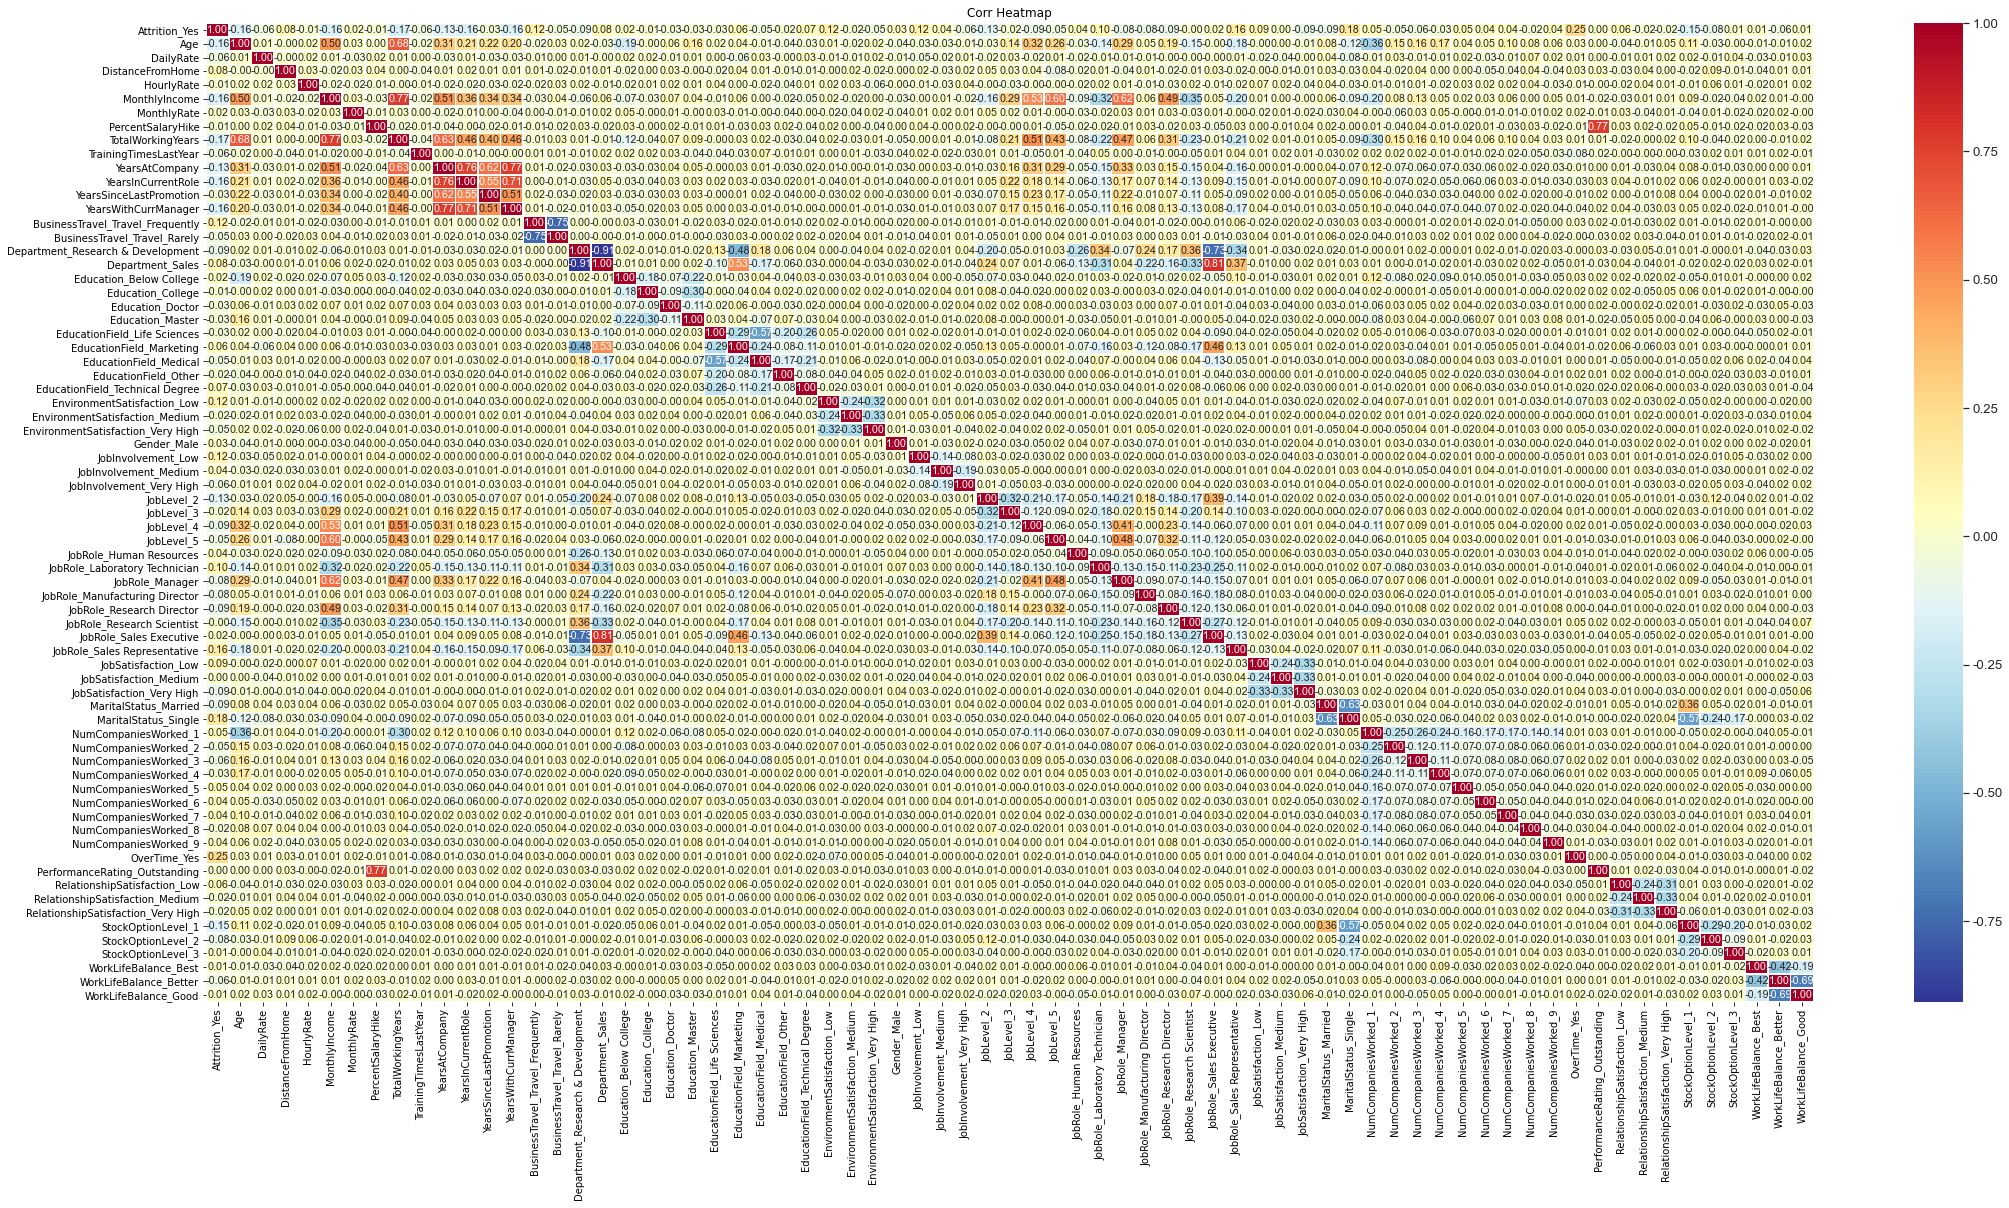

In [30]:
plt.figure(figsize=(36, 18))
plt.title('Corr Heatmap')

# 실제 히트맵 그리는 코드
sns.set(font_scale=1.2)
sns.heatmap(data_corr, annot=True, annot_kws={
    "size": 90 / np.sqrt(len(data_corr))}, fmt='.2f', cmap='RdYlBu_r', linewidths=0.5,)
plt.savefig('corrmap.png')
plt.show()

- 변수가 너무많아서 상관계수를 히트맵으로 표현해도 잘 볼수가 없습니다.
- 물론 볼수는 있지만, 이럴땐 다른 방법으로 확인해야겠습니다.

<br>

#### 2.5.2 상관관계가 있는것들만 따로 보기

In [31]:
temps = data_corr[(data_corr > 0.4) | (data_corr < -0.4)]
high_corr = []
for c in temps.columns: 
    temp = temps[c].dropna()

    if len(temp) == 1:
        continue
    high_corr.append([temp.name, temp.to_dict()])

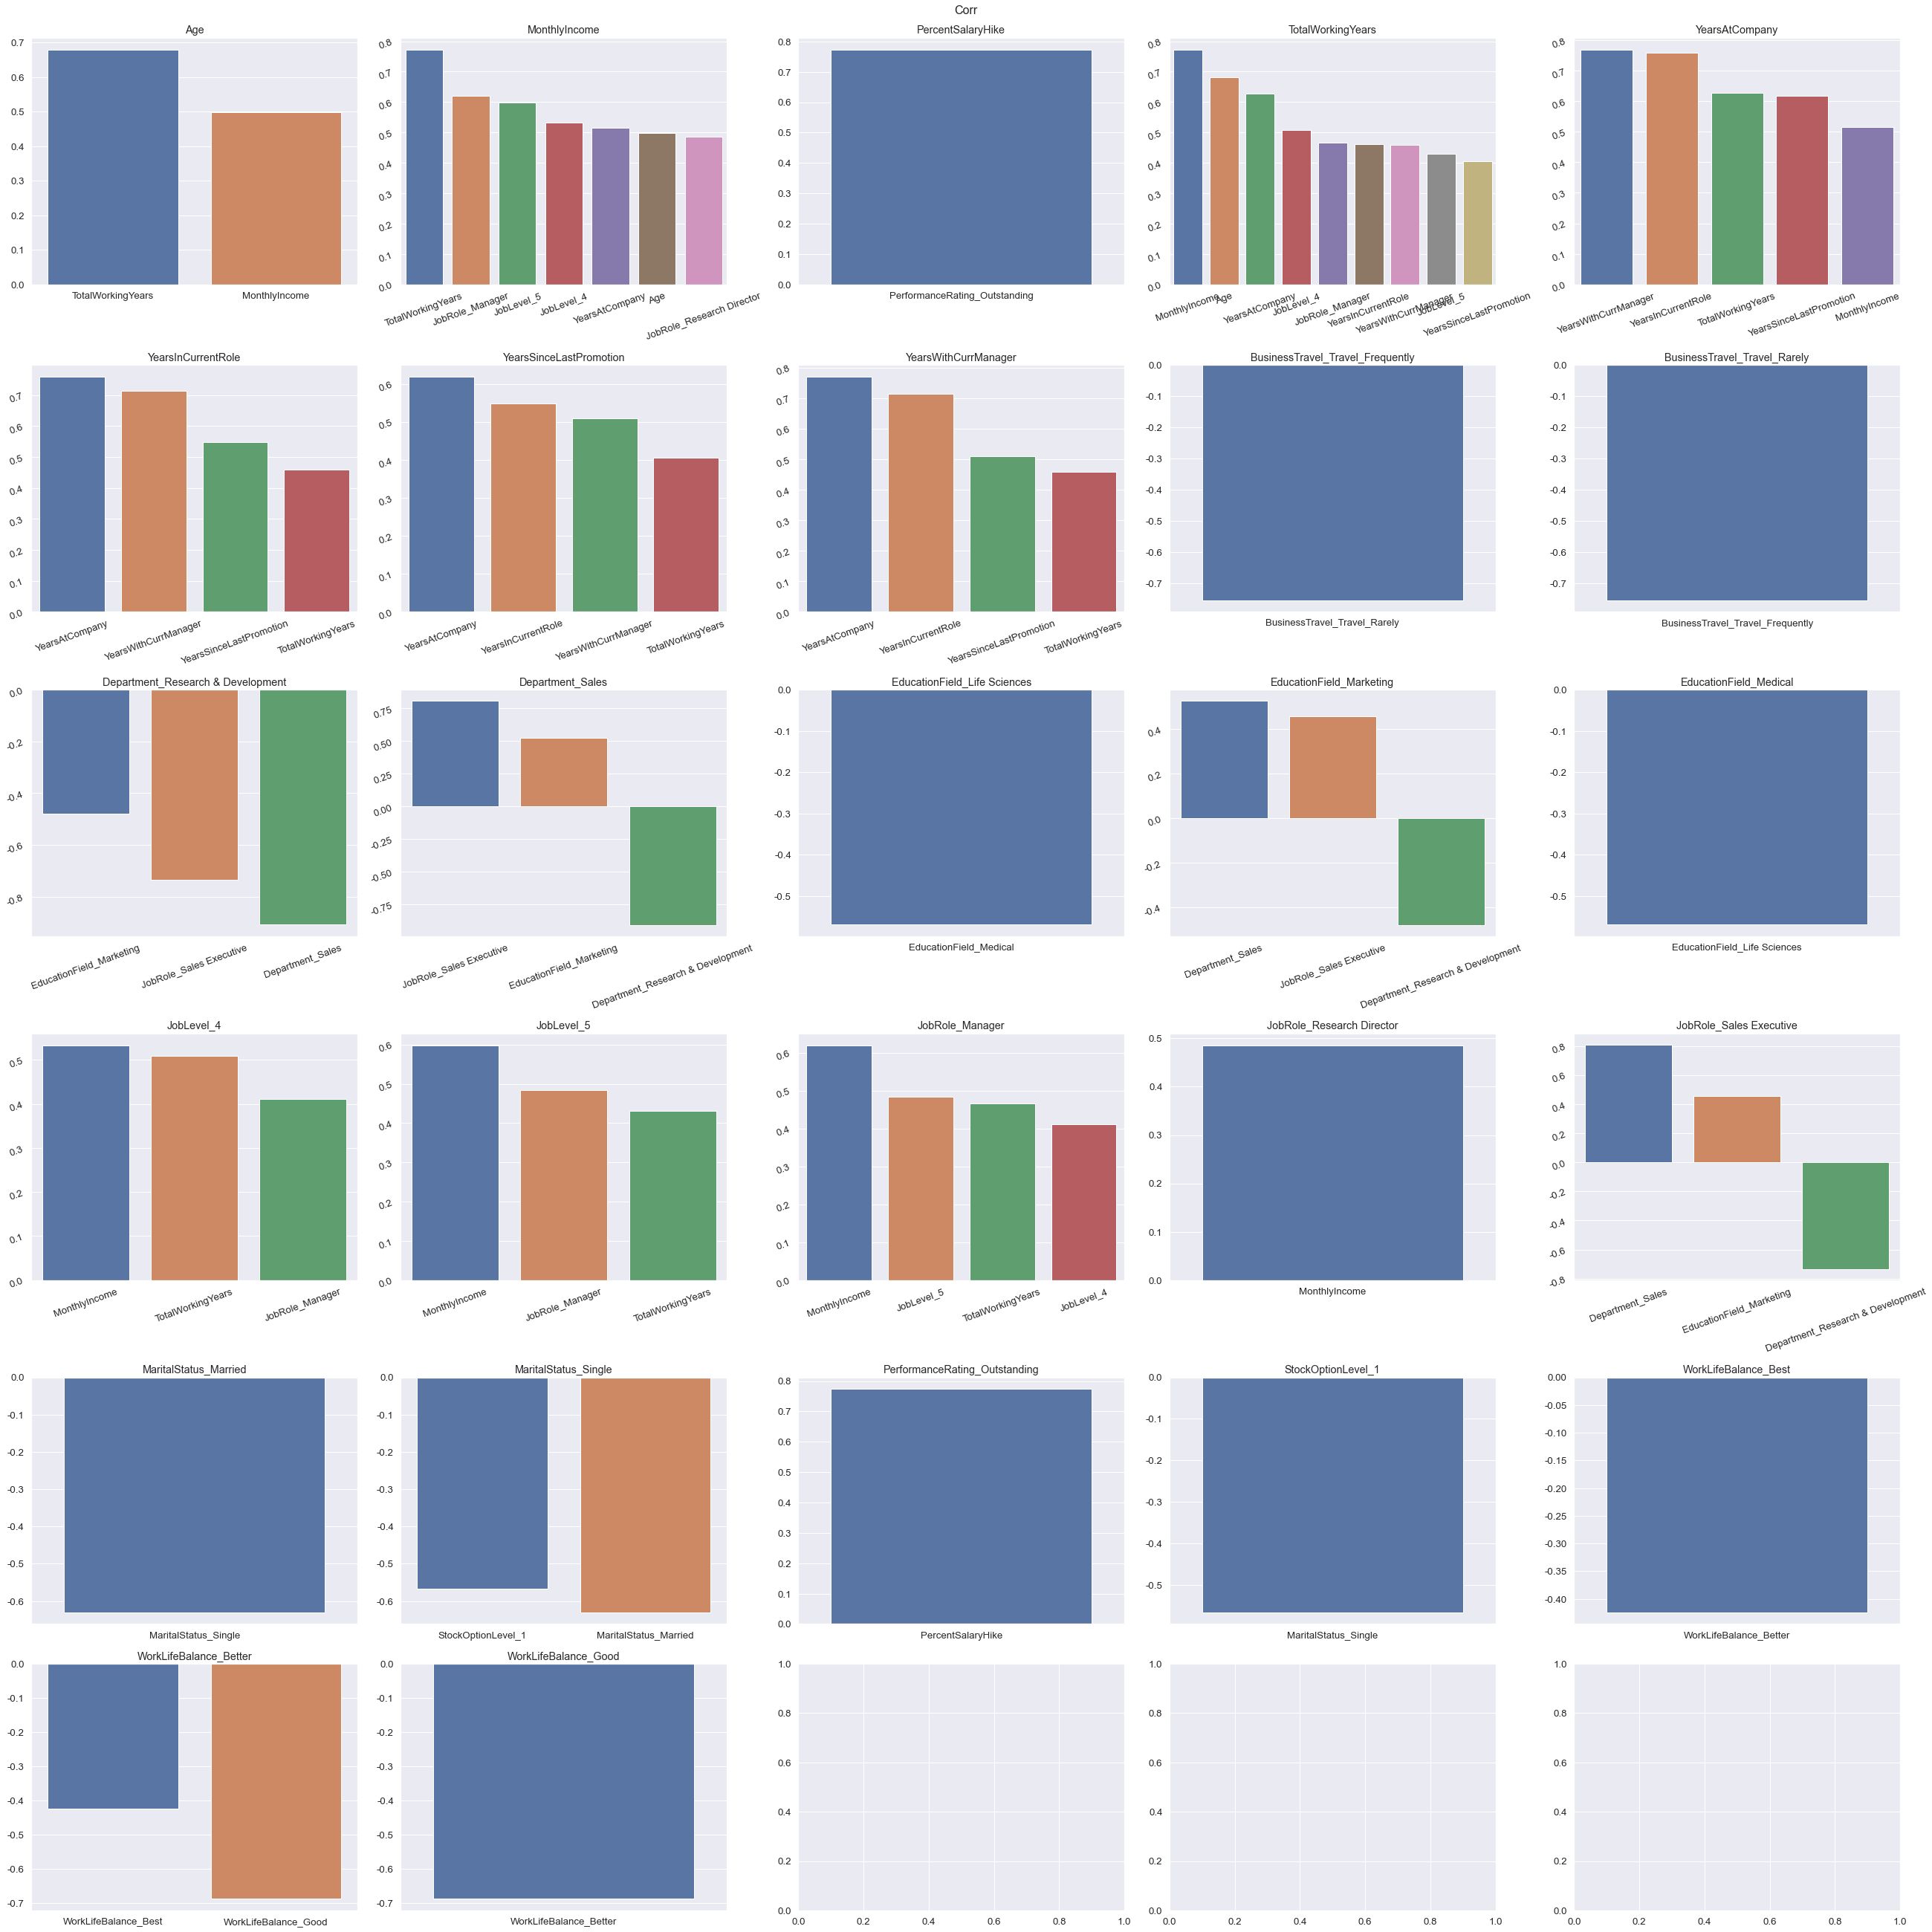

In [32]:
fig, ax = plt.subplots(6,5, figsize = (36, 36), constrained_layout=True)
fig.suptitle('Corr', fontsize=16)
ax = ax.flatten()

for i, c in enumerate(high_corr):
    ordered_d = OrderedDict(sorted(high_corr[i][1].items(), key=lambda t:t[1], reverse=True))
    title = ordered_d.popitem(0)
    
    sns.barplot(x = list(ordered_d.keys()), y = list(ordered_d.values()), ax = ax[i])
    ax[i].set(title = title[0])
    
    if len(ordered_d.keys()) > 2:
        ax[i].tick_params(labelrotation=20)
plt.savefig('corrbar.png')
plt.show()

- 월급여, 경력, 업무의 수준, 관리자, 나이에 상관계수가 높았습니다., 아무래도 경력이 쌓이고, 관리자의 직급, 어려운 업무일수록 급여를 많이주는것으로 파악됩니다.
- 만일 퇴사의 여부가 월 급여와 관련이 있다면 경력, 업무의 수준, 나이 등이 급여와 상관관계가 있으므로 같이 보아야 할듯 합니다.

<br>

#### 2.5.3 종속변수와의 상관관계

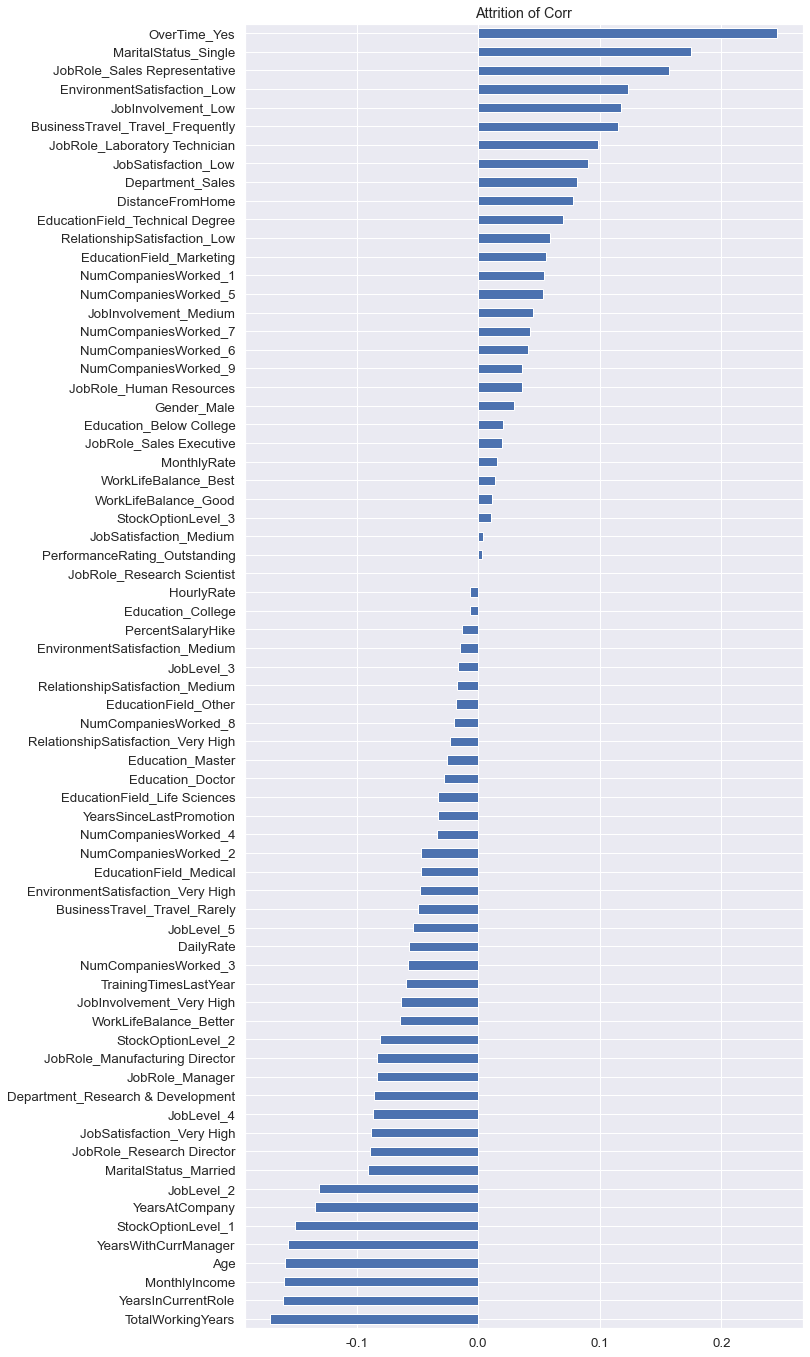

In [33]:
# 잘안보여서 일단 종속변수 상관관계만 확인
plt.title('Attrition of Corr')
data_cp.drop('Attrition_Yes', axis = 1).corrwith(data_cp.Attrition_Yes).sort_values().plot(kind='barh', figsize = (10, 24))
plt.show()

- 위에서 확인해보았던 히트맵에서는 종속변수는 다른 독립변수들과 비교하여 강한 상관관계를 가지는 변수는 없었습니다.
- 그래서 따로 확인을 해보았는데, 약하게 나마 OverTime, TotalWorkingYea, MonthlyIncome과 관계가 있어 보입니다.

<br>

#### 2.5.4 VIF 확인

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif["features"] = data_corr.columns
vif.sort_values(by='VIF Factor', ascending = False)

VIF Factor                            features
17  13640.716455                    Department_Sales
16  13522.448575   Department_Research & Development
22   3238.702786        EducationField_Life Sciences
5    3212.315104                       MonthlyIncome
24   2882.516493              EducationField_Medical
23   1749.979398            EducationField_Marketing
44   1229.895130             JobRole_Sales Executive
26    816.753726     EducationField_Technical Degree
37    740.090127                          JobLevel_5
36    721.256599                          JobLevel_4
38    580.597267             JobRole_Human Resources
25    503.944369                EducationField_Other
35    344.522261                          JobLevel_3
45    249.398879        JobRole_Sales Representative
8     235.109044                   TotalWorkingYears
40    196.264859                     JobRole_Manager
34    162.649949                          JobLevel_2
10    161.956363                      YearsAtCompany
43    107.302581          JobRole_Research Scientist
39     91.089185       JobRole_Laboratory Technician
69     88.607126              WorkLifeBalance_Better
50     73.095522                MaritalStatus_Single
70     65.434059                WorkLifeBalance_Good
42     53.287587           JobRole_Research Director
11     40.420495                  YearsInCurrentRole
65     38.927425                  StockOptionLevel_1
13     37.935563                YearsWithCurrManager
68     29.813928                WorkLifeBalance_Best
51     21.270629                NumCompaniesWorked_1
1      20.328417                                 Age
7      19.126971                   PercentSalaryHike
61     18.554877       PerformanceRating_Outstanding
41     16.536042      JobRole_Manufacturing Director
15     15.969357        BusinessTravel_Travel_Rarely
14     15.703952    BusinessTravel_Travel_Frequently
53     14.656369                NumCompaniesWorked_3
66     14.637033                  StockOptionLevel_2
52     12.851189                NumCompaniesWorked_2
49     12.089123               MaritalStatus_Married
54     12.066410                NumCompaniesWorked_4
12     10.986051             YearsSinceLastPromotion
67      8.399376                  StockOptionLevel_3
56      6.210026                NumCompaniesWorked_6
57      6.093062                NumCompaniesWorked_7
55      5.382364                NumCompaniesWorked_5
59      4.785775                NumCompaniesWorked_9
0       4.706463                       Attrition_Yes
58      4.495559                NumCompaniesWorked_8
48      3.975349           JobSatisfaction_Very High
64      3.799682  RelationshipSatisfaction_Very High
21      3.694006                    Education_Master
29      3.634595   EnvironmentSatisfaction_Very High
62      3.628168        RelationshipSatisfaction_Low
46      3.556749                 JobSatisfaction_Low
27      3.444139         EnvironmentSatisfaction_Low
47      3.402401              JobSatisfaction_Medium
28      3.310664      EnvironmentSatisfaction_Medium
63      3.220096     RelationshipSatisfaction_Medium
19      3.059469                   Education_College
18      2.625621             Education_Below College
60      1.823511                        OverTime_Yes
31      1.796165                  JobInvolvement_Low
33      1.726490            JobInvolvement_Very High
20      1.706147                    Education_Doctor
32      1.687609               JobInvolvement_Medium
3       1.580221                    DistanceFromHome
2       1.447858                           DailyRate
6       1.379119                         MonthlyRate
4       1.349891                          HourlyRate
30      1.328611                         Gender_Male
9       1.318633               TrainingTimesLastYear

- 다중공선성(vif) : 통계학의 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제입니다.
- 보통은 10 미만이면 다중공선성이 없다고 하는데, HR 데이터에는 상당히 높은 특성들이 많습니다.
- 일단, vif가 13000으로 너무 높은 Department 컬럼은 제외시키겠습니다.
- 물론 vif가 높다고 다 드랍 시킬순 없으니(Department 제외, 압도적으로 높음), 어떤 특성을 드랍시켜야하는지는 후에 고민을 해봐야 할듯하다.

## 3. 가설 확인
---
### 3.1 가설
- 가설1) 집과 회사의 거리가 먼 사람들이 퇴사를 많이 할것이다.
- 가설2) 월급여가 낮은 사람이 퇴사를 많이 할것이다.
- 가설3) 업무환경이 안좋은 사람이 퇴사를 할것이다.
- 가설4) 워라벨이 안좋은 사람들이 퇴사를 할것이다.
- 가설5) 근무부서에 따른 퇴사의 비율이 다를것이다. 즉, 특정부서가 퇴사율이 높을것이다.

<br>

In [35]:
# 비율 확인할 pivot 테이블 만드는 함수
def make_pivot(data, x, y, func):
    table = pd.pivot_table(data = data, values = 'Age', index = x, columns= y, aggfunc=func)
    table['total'] = table['No'] + table['Yes']
    table['Attrition_rate'] = table['Yes'] / table['total'] * 100
    return table

### 3.2 가설1) 집과 회사의 거리가 먼 사람들이 퇴사를 많이 할것이다.

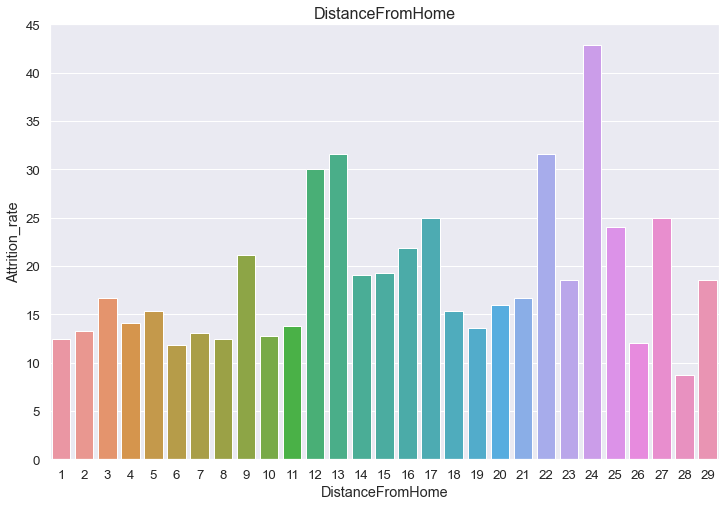

In [36]:
rate = make_pivot(data, 'DistanceFromHome', 'Attrition', func=len)

# plt.rc('font', family='AppleGothic') 
plt.figure(figsize=(12,8))
plt.title('DistanceFromHome', fontsize=16)
sns.barplot(rate.index, rate.Attrition_rate)
plt.show()

- 확실히 집에서 먼 사람이 집에서 가까운 사람들보다 많이 퇴사를 합니다.
- 가장 높은 비율인 거리 24는 전체 28명중에, 12 퇴사하여 비율로는 42.8%이고 전체 퇴사인원의 5%를 차지합니다.
- 전체 퇴사인원중에서 집과의 거리가 가까운 사람의 비율이 제일 많지만, 사실 집과의 거리가 가까운 인원의 비율이 전체 비율에서 제일 많아서 그렇습니다.

<br>

#### 3.2.1 거리가 먼 사람 컬럼 추가

In [37]:
round(data[data.DistanceFromHome >= 22]['DistanceFromHome'].count() / len(data),2)

0.13

In [38]:
data['FarFromHome'] = np.where(data.DistanceFromHome >= 22 , 1, 0)
data['FarFromHome'] = data['FarFromHome'].astype(object)

- 그래프 상에서 거리가 멀어서 퇴사비율이 많아보이는 22부터 집과 거리가 먼 컬럼을 새로 생성하고, 나중을 위해 type을 object로 변경

<br>

### 3.3 가설2) 월급여가 낮은 사람이 퇴사를 많이 할것이다.

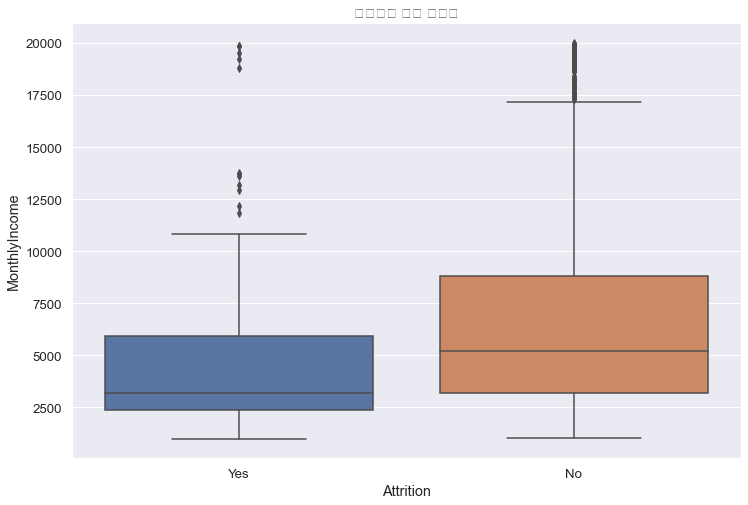

In [39]:
plt.figure(figsize = (12,8))
plt.title('월급여에 따른 퇴사율')
sns.boxplot(x = 'Attrition', y = 'MonthlyIncome', data = data)
plt.show()

- 박스그래프를 보면 월급여가 낮은 사람들이 퇴사가 있는것으로 보입니다.
- 또한 퇴사를 하지 않은 사람들의 중앙값이 퇴사를 한 사람들보다 위에 위치하고, 박스의 크기가 더 큰것으로 보아 분포도 넓은것으로 보입니다.
- 이는 월급여가 퇴사에 영향을 준다고 볼수 있다.

<br>

#### 3.3.1 월급여가 낮은 사람 추가

In [40]:
data[data['Attrition'] == 'Yes']['MonthlyIncome'].median()

3202.0

In [41]:
data['LowMonthlyIncome'] = np.where(data.MonthlyIncome <= 3202 , 1, 0)
data['LowMonthlyIncome'] = data['LowMonthlyIncome'].astype(object)

- 박스그래프상에 퇴사한 사람들의 급여의 중앙값을 기준으로 작은 급여를 책성하여 0,1로 나누었습니다.
- 또한 추후 처리를 쉽게하기 위해 object형식으로바꿔주었습니다.

### 3.4 가설3) 업무환경이 안좋은 사람이 퇴사를 할것이다.

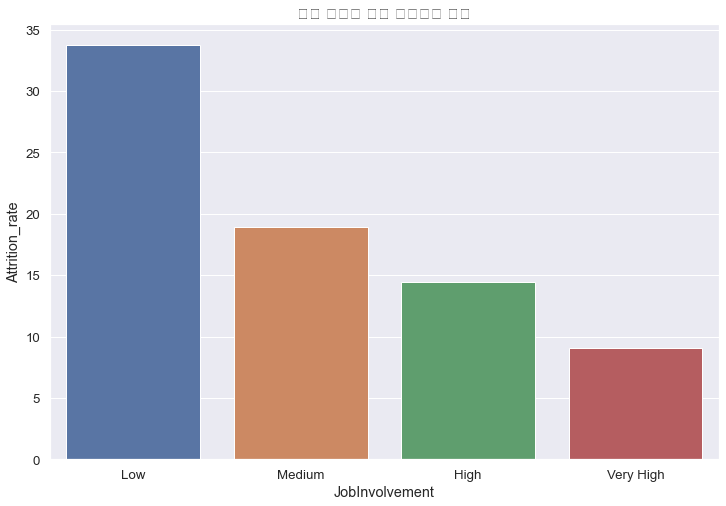

In [42]:
rate = make_pivot(data, 'JobInvolvement', 'Attrition', func=len)

plt.figure(figsize=(12, 8))
plt.title('업무 환경에 따른 퇴사인원 비율', fontsize=16)
sns.barplot(rate.index, rate.Attrition_rate, order=['Low', 'Medium', 'High', 'Very High'])
plt.show()

- 업무환경이 Low인 사람들은 총 83명이었고, 그 중 28명이 퇴사를 하였습니다. Low 인원의 비율로는 33%로 가장 높은 비율을 차지 합니다.
- 따라서 업무환경이 낮은 사람들이 더 많이 퇴사를 하는것으로 알수 있습니다.
- Onehot Encoding을하면 자동으로 Low, Medium, High, Very High는 구별되기에 따로 컬럼을 만들진 않았습니다.

<br>

### 3.5 가설4) 워라벨이 안좋은 사람들이 퇴사를 할것이다.

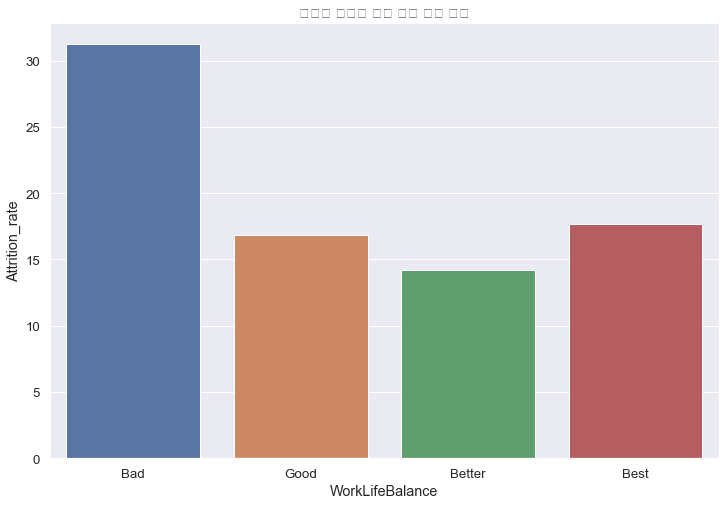

In [43]:
rate = make_pivot(data, 'WorkLifeBalance', 'Attrition', func= len)

plt.figure(figsize = (12,8))
plt.title('워라벨 정도에 따른 퇴사 인원 비율')
sns.barplot(rate.index, rate.Attrition_rate, order=['Bad', 'Good', 'Better', 'Best'])
plt.show()

- 워라벨이 Bad인 인원은 80명이고 그 중에 퇴사한 인원은 25명으로 총 비율로는 31%로 가장 높은 퇴사 비율을 보입니다.
- 의외인것은 Best인 인원도 꽤 많은 퇴사율을 보인다는 것입니다.
- 일단, 워라벨이 Bad인 사람들의 다른 사람들에 비해 퇴사율이 높습니다.

<br>

### 3.6 가설5) 근무부서에 따른 퇴사의 비율이 다를것이다. 즉, 특정부서가 퇴사율이 높을것이다.

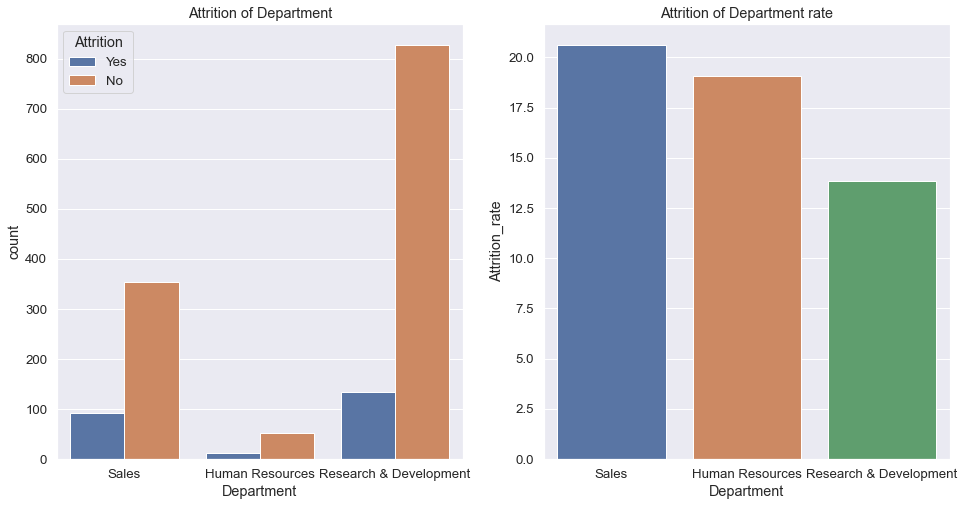

In [44]:
rate = make_pivot(data, 'Department', 'Attrition', func= len)
fig, ax = plt.subplots(1,2, figsize = (16,8))

sns.countplot(data['Department'], hue = data['Attrition'], ax = ax[0], order = ['Sales', 'Human Resources', 'Research & Development'])
ax[0].set(title = 'Attrition of Department')

sns.barplot(rate.index, rate.Attrition_rate, ax = ax[1], order = ['Sales', 'Human Resources', 'Research & Development'])
ax[1].set(title = 'Attrition of Department rate')

plt.show()

- 근무부서가 HR인곳은 전체 인력도 많지 않은데, 퇴사자가 생각보다 많음을 알수 있다, HR에 근무하는 인원 대비 약 18%정도가 퇴사를 하였습니다.
- 그렇다면 근무부서별로 월수입의 차이가 나서 HR 부서에서 퇴사 인력이 많은것 일까?

<br>

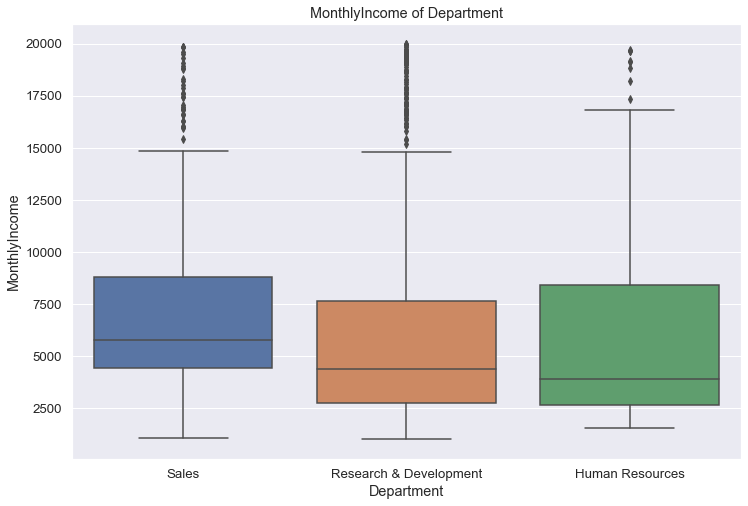

In [45]:
plt.figure(figsize=(12, 8))
plt.title('MonthlyIncome of Department')
sns.boxplot(x='Department', y='MonthlyIncome', data=data)
plt.show()

- 근무 부서별로 월 수입이 차이가 많이 나는지 확인을 해보았으나 (HR이 가장 낮을까?) 사실살 Sales를 제외하고는 나머지 2부서는 큰 차이가 없어 보입니다.
- 또한 가장 많은 월소득 구간은 세개의 부서는 큰 차이가 없는것으로 보입니다.
- 전체적으로 Sale의 급여가 조금 더 높게 형성되어 있음을 알수 있습니다.

<br>

In [46]:
temp = data.groupby('Department', axis=0).agg(['min', 'median', 'mean', 'max', 'std'])['MonthlyIncome']
temp

min  median         mean    max          std
Department                                                           
Human Resources         1555  3886.0  6654.507937  19717  5788.732921
Research & Development  1009  4374.0  6281.252862  19999  4895.835087
Sales                   1052  5754.5  6959.172646  19847  4058.739322

- 혹시 몰라 부서별 월수입에 대한 간단한 통계요약치를 보았습니다.
- 위에 박스그래프에서 적은 내용과 큰 차이는 없습니다.

<br>

### 3.7 가설6) 초기 경력자들이 퇴직을 많이 할것이다.

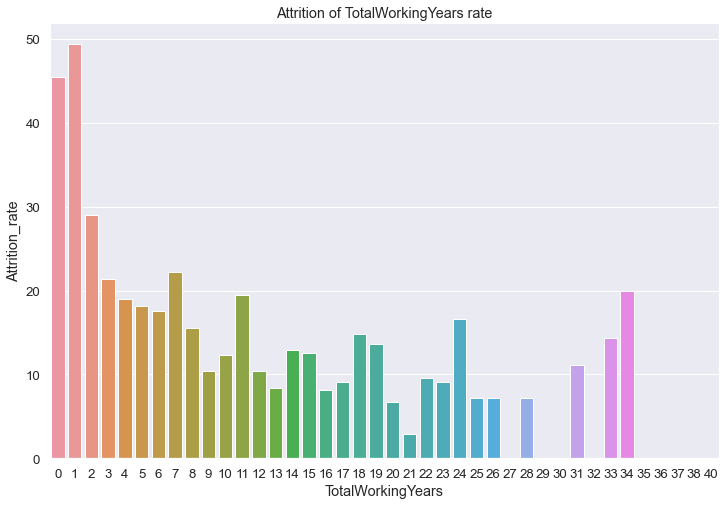

In [47]:
rate = make_pivot(data, 'TotalWorkingYears', 'Attrition', func= len).fillna(0)

plt.figure(figsize = (12,8))
plt.title('Attrition of TotalWorkingYears rate')
sns.barplot(rate.index, rate.Attrition_rate)
plt.show()

- 예상대로 초기 경력자 (0년 ~ 2년사이)의 인원이 가장 많은 퇴직율을 보였습니다.
- 아마 처음 경력을 쌓고 다른곳으로 이직을 하기 위해 퇴사를 하는것이 아닐까 생각해 보았습니다.

<br>

#### 3.7.1 초기경력자 컬럼 생성

In [48]:
data['LowWorkingYears'] = np.where(data.TotalWorkingYears <= 2 , 1, 0)
data['LowWorkingYears'] = data['LowWorkingYears'].astype(object)

### 3.8 가설확인 결론
- 가설1) 집과 회사의 거리가 먼 사람들이 퇴사를 많이 할것이다. - 맞음 -> 해당 컬럼 생성
- 가설2) 월급여가 낮은 사람이 퇴사를 많이 할것이다. - 맞음 -> 해당 컬럼 생성
- 가설3) 업무환경이 안좋은 사람은 퇴사를 할것이다. - 맞음
- 가설4) 워라벨이 안좋은 사람들이 퇴사를 할것이다. - 맞음, 하지만 워라벨이 좋아도 퇴사를 함
- 가설5) 근무부서에 따른 퇴사의 비율이 다를것이다. 즉, 특정부서가 퇴사율이 높을것이다. - 틀림
- 가설6) 초기 경력자들이 퇴직을 많이 할것이다. - 맞음 -> 해당 컬럼 생성

<br>

## 4. Feature Engineering
---

### 4.1 Age

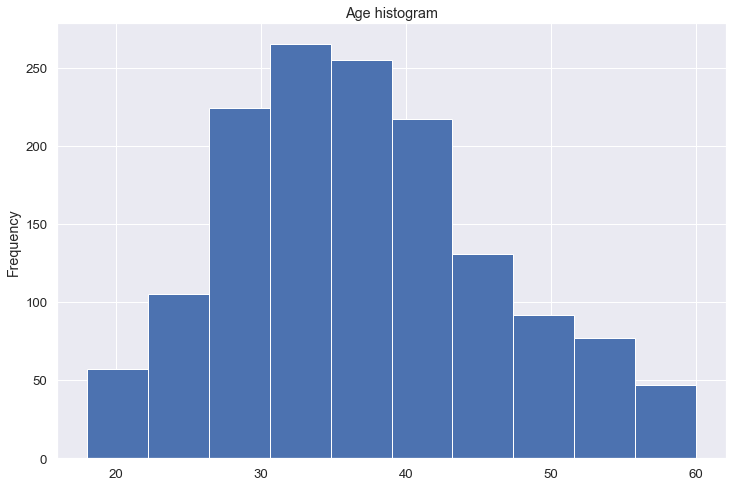

In [49]:
plt.figure(figsize=(12,8))
plt.title('Age histogram')
data['Age'].plot(kind = 'hist')
plt.show()

In [50]:
# [(17.958, 26.4] : 0,  (26.4, 34.8] : 1, (34.8, 43.2] : 2, (43.2, 51.6] : 3,  (51.6, 60.0] : 4]
# (미포함, 포함) 임
data['Age_cut'] = pd.cut(data['Age'], 5, labels=[0, 1, 2, 3, 4]).astype(object)

- 나이는 연속적이긴하지만, 5개 구간으로 나누는 컬럼을 생성하였습니다. 이후 나이 컬럼은 삭제합니다.

### 4.2 NumCompaniesWorked

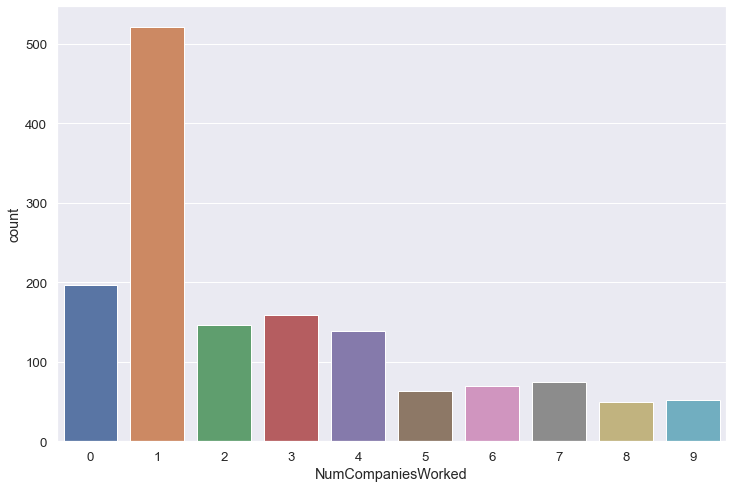

In [51]:
plt.figure(figsize=(12,8))
sns.countplot(data.NumCompaniesWorked)
plt.show()

- 일한 회사의 수가 0인게 이상합니다. 일한 회사의 수가 없을수가 없으니까요
- 만약 전체 일한 회사의수가 현재 IBM을 제외시킨거라면 이해는 갑니다.
- 그렇다면 일한 회사의 수가 0인 사람들은 총 경력기간과 회사의 근속년수가 같아야 합니다.

<br>

In [52]:
data[(data.NumCompaniesWorked == 0) & (data.TotalWorkingYears == data.YearsAtCompany)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']]

Empty DataFrame
Columns: [NumCompaniesWorked, TotalWorkingYears, YearsAtCompany]
Index: []

- 일한 회사의 수가 0개인 사람들 중 전체 경력과 근속년수가 같은 인원은 한명도 없습니다.
- 데이터의 오류인지 더 확인해봐야겠습니다. 
- 이번엔 일한 회사가 0개인 사람들 중에 경력과 근속년수가 다른 사람들을 확인하겠습니다.

In [53]:
print(data[(data.NumCompaniesWorked == 0) & (data.TotalWorkingYears != data.YearsAtCompany)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']].shape)
data[(data.NumCompaniesWorked == 0) & (data.TotalWorkingYears != data.YearsAtCompany)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']].head()

(197, 3)


NumCompaniesWorked  TotalWorkingYears  YearsAtCompany
5                   0                  8               7
8                   0                 10               9
10                  0                  6               5
11                  0                 10               9
13                  0                  3               2

- 총 197개의 데이터가 있고, 경력과 근속년수가 1년씩 차이납니다.
- 그렇다면 경력과 근속년수가 같은 사람들은 일한 회사의 수가 몇개로 나오는지 확인하겠습니다.

In [54]:
data[(data.TotalWorkingYears == data.YearsAtCompany)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']].head()

NumCompaniesWorked  TotalWorkingYears  YearsAtCompany
1                   1                 10              10
3                   1                  8               8
7                   1                  1               1
12                  1                  5               5
15                  1                 10              10

- 경력과 근속년수가 같은 사람들은 모두 일한회사의 수가 1개로 나옵니다.
- 그렇다면 일한회사의 수가 2개 이상인데 경력과 근속년수가 같은 사람도 있는지 확인해봐야겠습니다

In [55]:
data[(data.NumCompaniesWorked >= 2) & (data.TotalWorkingYears == data.YearsAtCompany)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']].head()

Empty DataFrame
Columns: [NumCompaniesWorked, TotalWorkingYears, YearsAtCompany]
Index: []

- 일한회사의 수개 2개 이상 인데, 근속년수가 같은 사람은 없습니다.

In [56]:
data[(data.NumCompaniesWorked >= 1) & ((data.TotalWorkingYears - data.YearsAtCompany) == 1)][['NumCompaniesWorked','TotalWorkingYears','YearsAtCompany']].head()

NumCompaniesWorked  TotalWorkingYears  YearsAtCompany
35                   1                  6               5
45                   1                 23              22
94                   1                 12              11
109                  1                  1               0
129                  1                 16              15

- 일한 회사가 1개고, 총 경력과 근속년수가 1년 차이나는 사람은 있습니다.
- 하지만 일한 회사가 2개 이상이며, 총 경력과 근속년수가 1년 차이나는 사람은 없습니다.
- 정리하자면 일한회사가 0개의 의미는
    - 1) 현재 근속하는 회사를 제외시킨 수치여서 그렇다. (일한회사가 0 = IBM이 첫회사이다) 
        - 그렇다면 일한회사가 1개인 사람들은 총 경력과 현재 근속년수가 같으면 안된다. (IBM에 들어오기전 직장이 있기 때문에)
        - 하지만 일한회사가 1개인 사람들 중 총 경력과 현재 근속년수가 같은 사람이 있다. -> 오류
    - 2) 일한회사가 0개는 오류이다.
        - 일한 회사가 없을수는 없으니 무조건 1개부터 시작한다, 
        - 0으로 넣은 사람들은 오류이고, 1개를 더해주면 된다.(IBM 회사)
- 결론을 이야기하자면, 데이터 상으로 일한회사가 0개가 나올수는 없으니, 0인 사람들은 모두 +1을 해주면 된다.

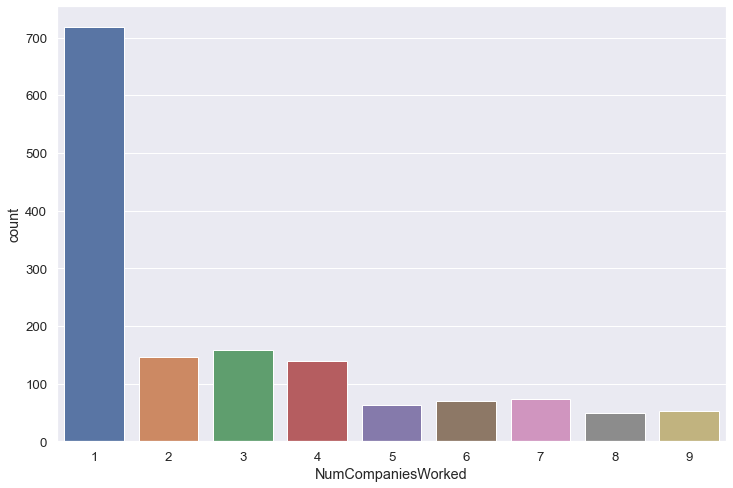

In [57]:
data.NumCompaniesWorked.replace(0, 1, inplace = True)
plt.figure(figsize=(12,8))
sns.countplot(data.NumCompaniesWorked)
plt.show()

- 다시 일한회사의 수가 0인 사람들을 1로 바꾸고 보니, 압도적으로 IBM에서만 일한 사람이 많다.

In [58]:
data.NumCompaniesWorked = data.NumCompaniesWorked.astype(object)

- int형으로 변경되었기에 다시 object로 변경

### 4.3 Total Satisfaction

In [59]:
point = {'Low' : 0, 'Medium' : 1, 'High' : 2 , 'Very High' : 3}
EnvironmentSatisfaction = data['EnvironmentSatisfaction'].map(point)
RelationshipSatisfaction = data['RelationshipSatisfaction'].map(point)
JobSatisfaction = data['JobSatisfaction'].map(point)
data['TotalSatisfaction'] = (EnvironmentSatisfaction + RelationshipSatisfaction + JobSatisfaction).astype(object)

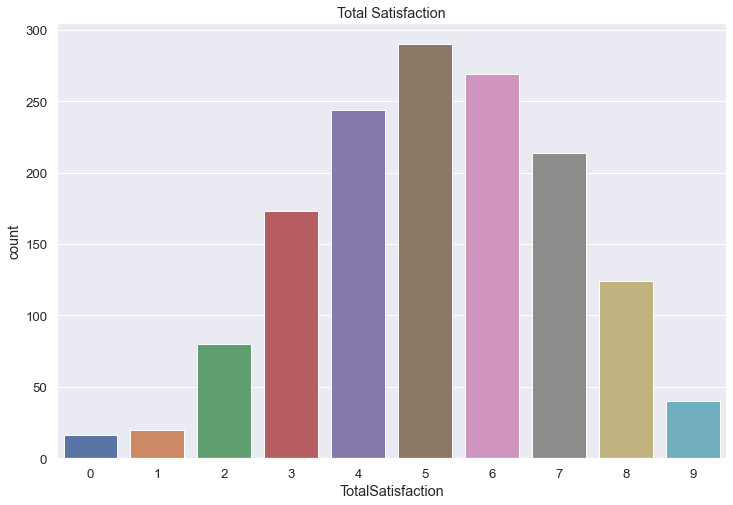

In [60]:
plt.figure(figsize=(12, 8))
plt.title('Total Satisfaction')
sns.countplot(data['TotalSatisfaction'])
plt.show()

- EnvironmentSatisfaction, RelationshipSatisfaction, JobSatisfaction는 만족이라는 키워드를 가지는 컬럼입니다.
- 위 컬럼의 만족도에 대한 점수들을 합산하여 포탈만족도라는 컬럼을 생성하였습니다.
- 따라서, 개별 만족도 컬럼은 삭제 합니다.

### 4.4 Outlier 확인

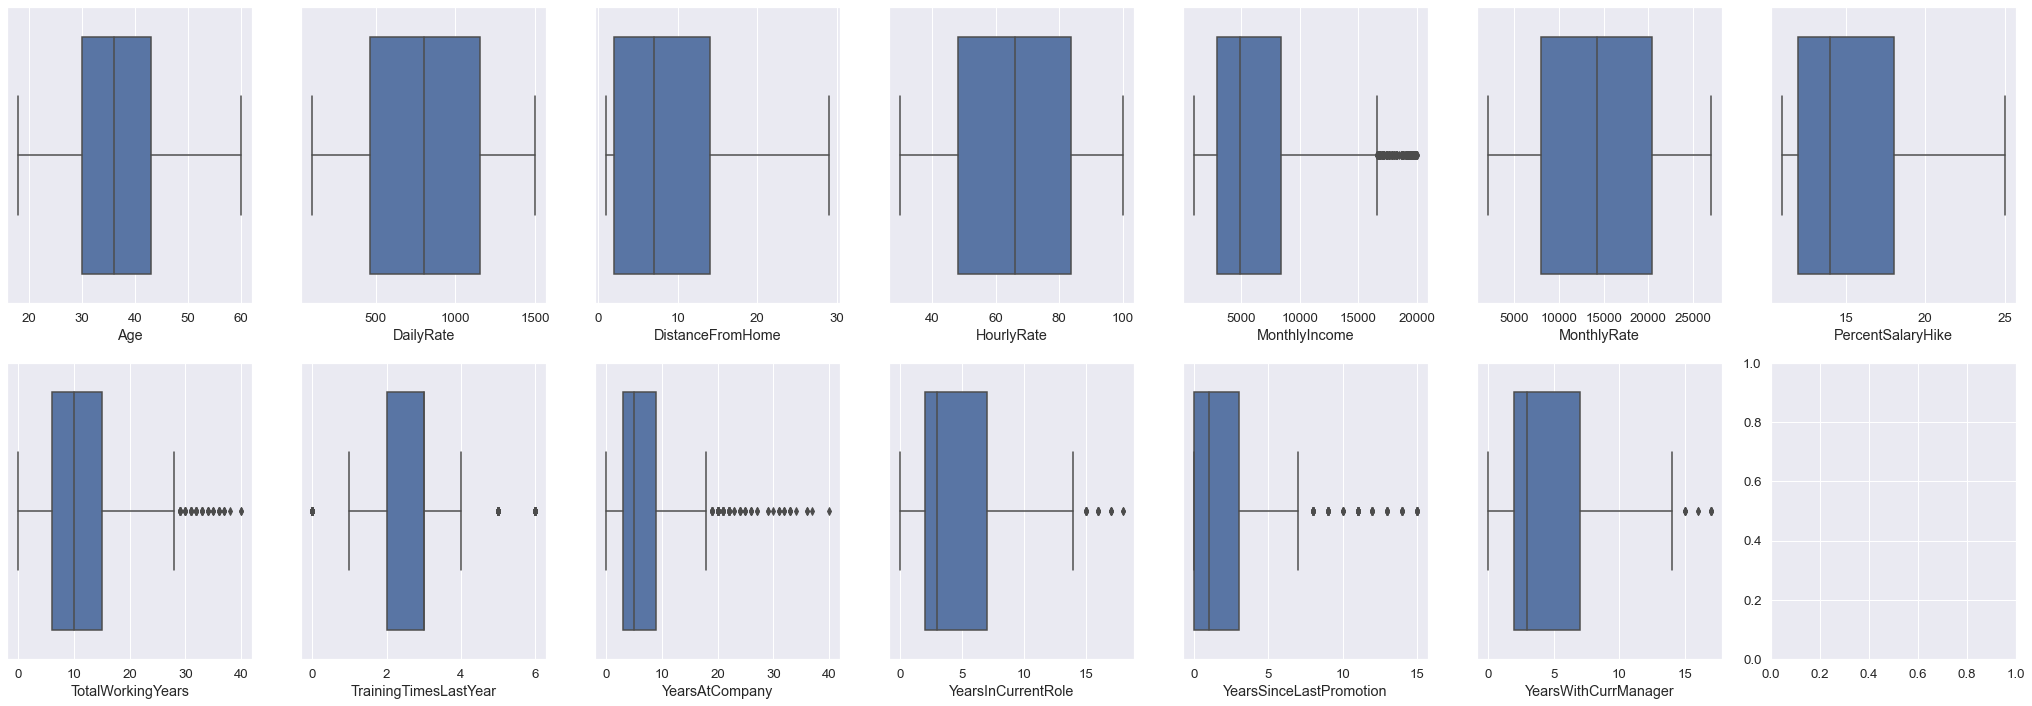

In [61]:
cont_cols = [i for i in data.columns if data[i].dtype != object]
fig, ax = plt.subplots(2, 7, figsize=(36, 12))
ax = ax.flatten()

for index, col in enumerate(cont_cols):
    sns.boxplot(data[col], ax=ax[index])

In [62]:
# 아웃라이어 확인 함수 생성
def outlier(data, col):
    q1 = np.percentile(data[col], 25) 
    q3 = np.percentile(data[col], 75)
    IQR = q3 - q1
    outlier_step = 1.5 * IQR
    return data[(data[col] < q1 - outlier_step) | (data[col] > q3 + outlier_step)]

#### 4.4.1 MonthlyIncom

MonthlyIncome의 아웃라이어 갯수 114개
전체 데이터의 0.08% 차지
No     109
Yes      5
Name: Attrition, dtype: int64


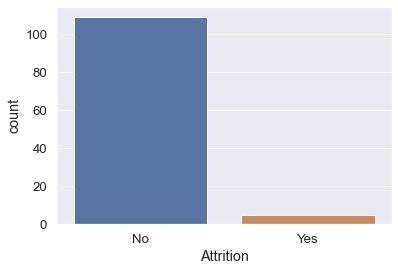

In [63]:
monthlyincom_outlier = outlier(data, 'MonthlyIncome')
print(f'MonthlyIncome의 아웃라이어 갯수 {monthlyincom_outlier.shape[0]}개')
print(f'전체 데이터의 {round(monthlyincom_outlier.shape[0] / data.shape[0],2)}% 차지')
print(monthlyincom_outlier.Attrition.value_counts())
sns.countplot(monthlyincom_outlier.Attrition)
plt.show()

- 컬럼 삭제 합니다. 아웃라이어가 너무 크고 많으며 VIF 계수도 굉장히 높았습니다.

#### 4.4.2 TotalWorkingYears

TotalWorkingYears의 아웃라이어 갯수 63개
전체 데이터의 0.04% 차지
No     58
Yes     5
Name: Attrition, dtype: int64


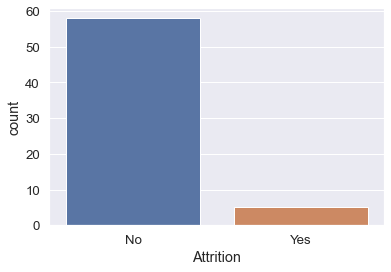

In [64]:
workingyear_outlier = outlier(data, 'TotalWorkingYears')
print(f'TotalWorkingYears의 아웃라이어 갯수 {workingyear_outlier.shape[0]}개')
print(f'전체 데이터의 {round(workingyear_outlier.shape[0] / data.shape[0],2)}% 차지')
print(workingyear_outlier.Attrition.value_counts())
sns.countplot(workingyear_outlier.Attrition)
plt.show()

- 아웃라이어의 갯수가 많지는 않으나, VIF가 높았었기에 컬럼을 삭제 합니다.

#### 4.4.3 TrainingTimesLastYear

TrainingTimesLastYear의 아웃라이어 갯수 238개
전체 데이터의 0.16% 차지
No     203
Yes     35
Name: Attrition, dtype: int64


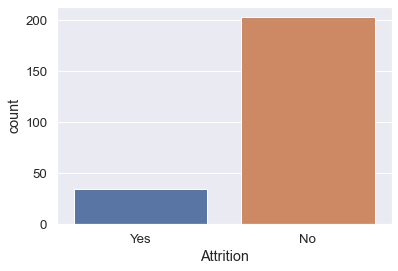

In [65]:
traininigtimes_outlier = outlier(data, 'TrainingTimesLastYear')
print(f'TrainingTimesLastYear의 아웃라이어 갯수 {traininigtimes_outlier.shape[0]}개')
print(f'전체 데이터의 {round(traininigtimes_outlier.shape[0] / data.shape[0],2)}% 차지')
print(traininigtimes_outlier.Attrition.value_counts())
sns.countplot(traininigtimes_outlier.Attrition)
plt.show()

- VIF 계수도 낮으며, 아웃라이어가 전체 데이터에 많은 양을 자지해서 컬럼 및 아웃라이어도 그대로 유지합니다.

#### 4.4.4 YearsAtCompany

YearsAtCompany의 아웃라이어 갯수 104개
전체 데이터의 0.07% 차지
No     94
Yes    10
Name: Attrition, dtype: int64


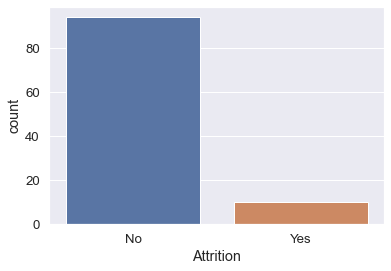

In [66]:
yearsatcompany_outlier = outlier(data, 'YearsAtCompany')
print(f'YearsAtCompany의 아웃라이어 갯수 {yearsatcompany_outlier.shape[0]}개')
print(f'전체 데이터의 {round(yearsatcompany_outlier.shape[0] / data.shape[0],2)}% 차지')
print(yearsatcompany_outlier.Attrition.value_counts())
sns.countplot(yearsatcompany_outlier.Attrition)
plt.show()

- 아웃라이어가 전체 데이터에 0.07% 차지합니다. 근속년수가 퇴사 여부에 영향을 미칠듯 싶어서 아웃라이어만 삭제 합니다.

#### 4.4.5 YearsInCurrentRole

YearsInCurrentRole의 아웃라이어 갯수 21개
전체 데이터의 0.01% 차지
No     19
Yes     2
Name: Attrition, dtype: int64


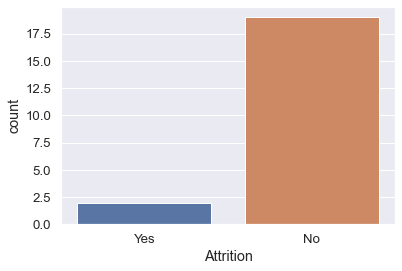

In [67]:
yearsincurrentrole_outlier = outlier(data, 'YearsInCurrentRole')
print(f'YearsInCurrentRole의 아웃라이어 갯수 {yearsincurrentrole_outlier.shape[0]}개')
print(f'전체 데이터의 {round(yearsincurrentrole_outlier.shape[0] / data.shape[0],2)}% 차지')
print(yearsincurrentrole_outlier.Attrition.value_counts())
sns.countplot(yearsincurrentrole_outlier.Attrition)
plt.show()

- 아웃라이어가 전체 데이터에 0.01%밖에 차지를 안합니다. VIF 계수가 낮기에 아웃라이어만 삭제 결정

#### 4.4.6 YearsSinceLastPromotion

YearsSinceLastPromotion의 아웃라이어 갯수 107개
전체 데이터의 0.07% 차지
No     94
Yes    13
Name: Attrition, dtype: int64


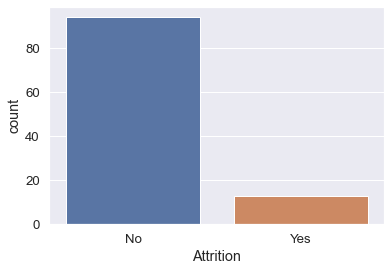

In [68]:
yearssincelastpromotion_outlier = outlier(data, 'YearsSinceLastPromotion')
print(f'YearsSinceLastPromotion의 아웃라이어 갯수 {yearssincelastpromotion_outlier.shape[0]}개')
print(f'전체 데이터의 {round(yearssincelastpromotion_outlier.shape[0] / data.shape[0],2)}% 차지')
print(yearssincelastpromotion_outlier.Attrition.value_counts())
sns.countplot(yearssincelastpromotion_outlier.Attrition)
plt.show()

- 아웃라이어가 전체 데이터에 0.07% 차지하여 삭제하긴 어렵고, 컬럼은 VIF가 낮으니 삭제하기 어려워 유지

#### 4.4.7 YearsWithCurrManager

YearsWithCurrManager의 아웃라이어 갯수 14개
전체 데이터의 0.01% 차지
No    14
Name: Attrition, dtype: int64


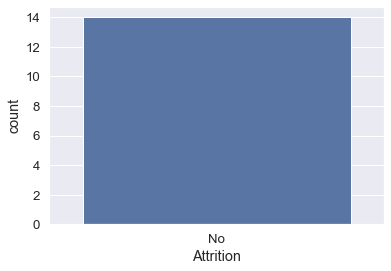

In [69]:
yearswithcurrmanager_outlier = outlier(data, 'YearsWithCurrManager')
print(f'YearsWithCurrManager의 아웃라이어 갯수 {yearswithcurrmanager_outlier.shape[0]}개')
print(f'전체 데이터의 {round(yearswithcurrmanager_outlier.shape[0] / data.shape[0],2)}% 차지')
print(yearswithcurrmanager_outlier.Attrition.value_counts())
sns.countplot(yearswithcurrmanager_outlier.Attrition)
plt.show()

- VIF 도 상대적으로 낮고, 아웃라이어가 몇개 없긴 하지만, 모두 No라는 특성을 가지고 있기에 아웃라이어가 실제 특성을 가지고 있을수 있어서 유지 결정

#### 4.4.8 Outlier 및 컬럼 삭제

In [70]:
data_copy = data.copy()
outlier_df = pd.concat([yearsatcompany_outlier, yearsincurrentrole_outlier]).drop_duplicates()
data_copy.drop(index=outlier_df.index, inplace=True)
data_copy.drop(labels=['MonthlyIncome', 'Age', 'TotalWorkingYears', 'YearsAtCompany', 'Department',
                       'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'JobSatisfaction'], axis=1, inplace=True)
data_copy.shape

(1361, 28)

- Outlier 및 Column을 삭제할때는 하나의 지표를 절대적으로 참고하는것이 아닌 여러가지의 지표를 사용해야 합니다.
- 일단, 해당 데이터에 도메인 지식이 있어서 도메인 지식을 활용하여 컬럼 및 데이터 삭제를 할수 있으면 좋습니다.
- 그 외에는 VIF, 아웃라이어를 가진 컬럼의 시각화, 아웃라이어 데이터만 보기 등이 있습니다.
- 만일 아웃라이어데이터가 이진분류에서 하나의 클래스(All 0 or all 1)만 가지고 있다면 해당 아웃라이어는 클래스를 설명하는 지표가 될수 있기에 삭제를 하지 않는쪽으로 생각 해야합니다.
- 반대로 두개의 클래스에 50:50으로 분포가 되어있다면, 삭제를 고려하여도 됩니다.

<br>

## 5. 예측을 위한 데이터 처리
---

### 5.1 Label Encoder 및 Scaler 적용

In [71]:
numeric_features = [column for column in data_copy.columns if data_copy[column].dtype != object]
categorical_features = [column for column in data_copy.columns if data_copy[column].dtype == object]

data_copy[categorical_features] = data_copy[categorical_features].apply(LabelEncoder().fit_transform)
data_copy[numeric_features] = RobustScaler().fit_transform(data_copy[numeric_features])

- 컴퓨터는 Male, HR 이런 단어들을 인식하지 못합니다. 해당 단어들을 숫자로 바꿔주는것이 Label Encoder 입니다.
- 예를들어 Department의 'Sales', 'Human Resources', 'Research & Development' 를 컴퓨터가 알아볼수 있게 0, 1, 2로 바꿔주는 것입니다.

### 5.2 X,y 분리

In [72]:
X = data_copy.drop(labels= ['Attrition'], axis = 1)
y = data_copy.Attrition

- 데이터를 종속변수와 독립변수로 나눠줍니다.

### 5.3 train, test 분리

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=87, test_size=0.2)

In [74]:
train_rate = round(y_train.sum() / len(y_train),2)
test_rate = round(y_test.sum() / len(y_test),2)
print(f'학습 데이터에서의 Target 비율 : {train_rate}')
print(f'테스트 데이터에서의 Target 비율 : {test_rate}')

학습 데이터에서의 Target 비율 : 0.17
테스트 데이터에서의 Target 비율 : 0.17


### 5.4 함수 생성

#### 5.4.1  Learning Curve 함수 준비

In [75]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).

    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """

    plt.figure(figsize = (12,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt.show()

- 학습이 과적합인지 과소적합인지 확인하는 Learning Curve function 생성
- Gridsearch와 title, x, y값을 넣으면 Learning Curve를 볼수 있는 함수
- Learning Curve로 과적합을 판단함

#### 5.4.2 Model 성능 함수 생성

In [76]:
def model_score(y_test, predict):
    print('Accuracy : ',round(accuracy_score(y_test, predict), 3))
    print('Recall : ',round(recall_score(y_test, predict), 3))
    print('Precision : ',round(precision_score(y_test, predict), 3))
    print('F1_Score : ',round(f1_score(y_test, predict), 3))
    print()
    print('Confusion_matrix :')
    print(confusion_matrix(y_test, predict))

## 6. 머신러닝 알고리즘을 이용한 퇴사자 예측
---

### 6.1 의사결정나무
- 데이터를 분석하여 이들 사이에 존재하는 패턴을 예측 가능한 규칙들의 조합으로 나타내며, 그 모양이 ‘나무’와 같다고 해서 의사결정나무라 불립니다.
- 분류(classification)와 회귀(regression) 모두 가능합니다.
- 종속변수를 잘 나타내주는 독립변수를 지니불순도나 엔트로피를 이용하여 분류합니다.
- 장점 
    - 모델을 쉽게 시각화하여 비전문가도 이해하기 쉽습니다.
    - 데이터의 스케일에 구애받지 않음, 전처리(정규화,표준화)가 필요 없습니다.
    - 각 특성의 스케일이 다르거나 이진특성, 연속특성이 혼합되어 있을 때도 잘 작동 합니다.
            
- 단점
    - 사전 가지치기를 사용해도 과대적합되는 경향이 있어 일반화 성능이 좋지 않습니다.
    - 외삽(extrapolation) = 훈련 데이터의 범위 밖의 포인트는 예측할 수 없습니다.

#### 6.1.1 기본 모델 생성 및 학습

In [77]:
clf_model = DecisionTreeClassifier(random_state=87)

params_grid = [{}]

gridsearch = GridSearchCV(
    estimator=clf_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=87), n_jobs=-1,
             param_grid=[{}], return_train_score=True)

- 의사결정나무에 하이퍼파라미터 튜닝을 하지 않고 기본 설정으로 모델을 생성하였습니다.
- Cross Validation(CV)를 5회 진행하였습니다.

<br>

#### 6.1.2 학습 결과 저장

In [78]:
result = []
result.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'mean_train_score': float(gridsearch.cv_results_['mean_train_score']),
           'mean_test_score': float(gridsearch.cv_results_['mean_test_score'])})

- 학습한 결과를 추후에 모델별로 시각화 할수 있게 저장을 해둡니다.

<br>

#### 6.1.3 예측 및 검증

Accuracy :  0.799
Recall :  0.37
Precision :  0.395
F1_Score :  0.382

Confusion_matrix :
[[201  26]
 [ 29  17]]


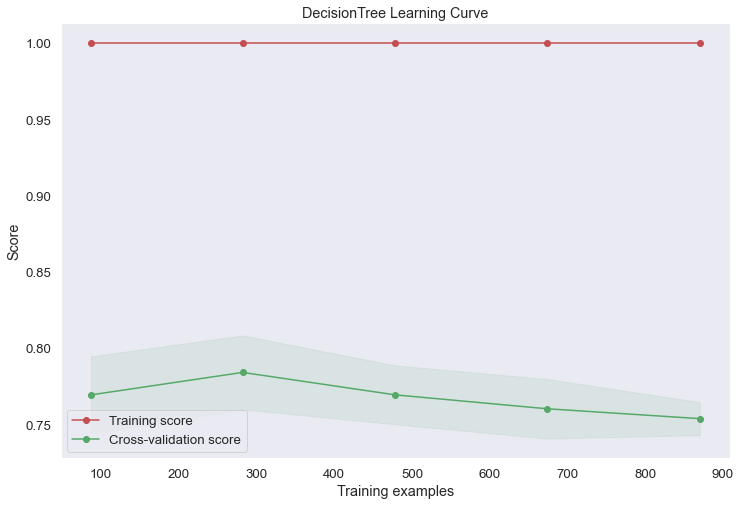

In [79]:
clf_best_model = gridsearch.best_estimator_
clf_best_model.fit(X_train, y_train)
clf_predict = clf_best_model.predict(X_test)

model_score(y_test, clf_predict)
plot_learning_curve(clf_best_model, 'DecisionTree Learning Curve', X_train, y_train, cv=5)

- 학습이 잘 되고 있는지, Learning Curve를 그려보았습니다.
- 학습은 Accuracy가 1로 잘 맞추지만, 실제 검증을 하면 0.8을 넘지못합니다.
- 과대적합이 있습니다.

<br>

#### 6.1.4 중요변수 확인

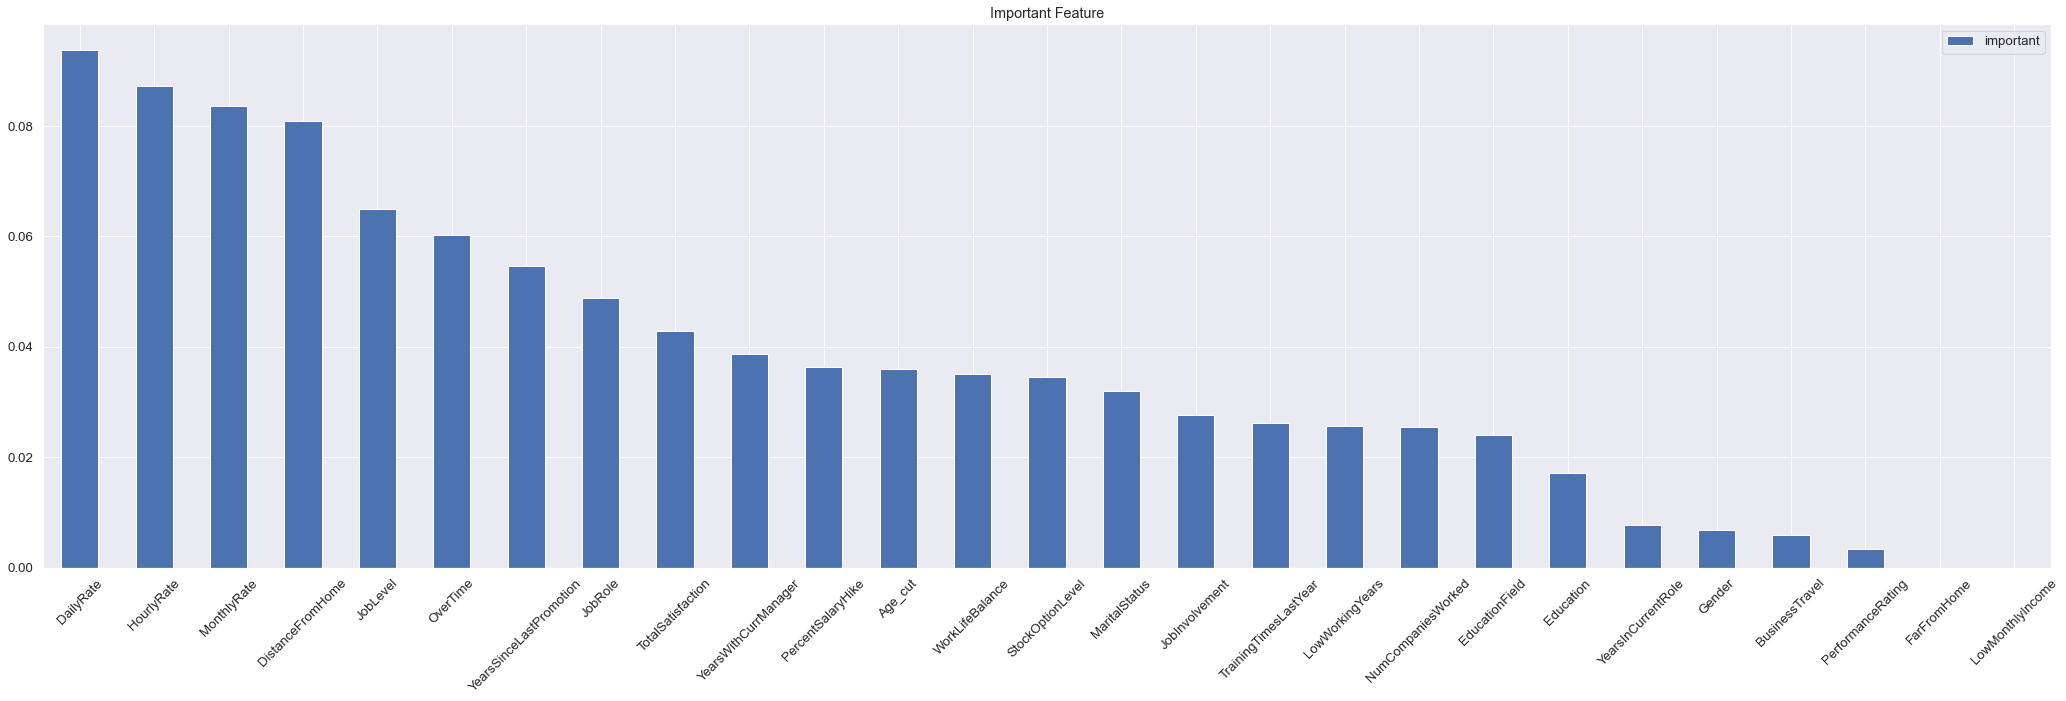

In [80]:
important = clf_best_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title ='Important Feature')
plt.show()

- 의사결정나무모델이 사용한 변수들중 중요하다고 판단한 Feature들을 확인해보았습니다.
- 가장 마지막에 있는 점수가 없는 Feature들은 중요하지 않다고해서 삭제를 할순 없습니다.

<br>

#### 6.1.5 결정나무 시각화

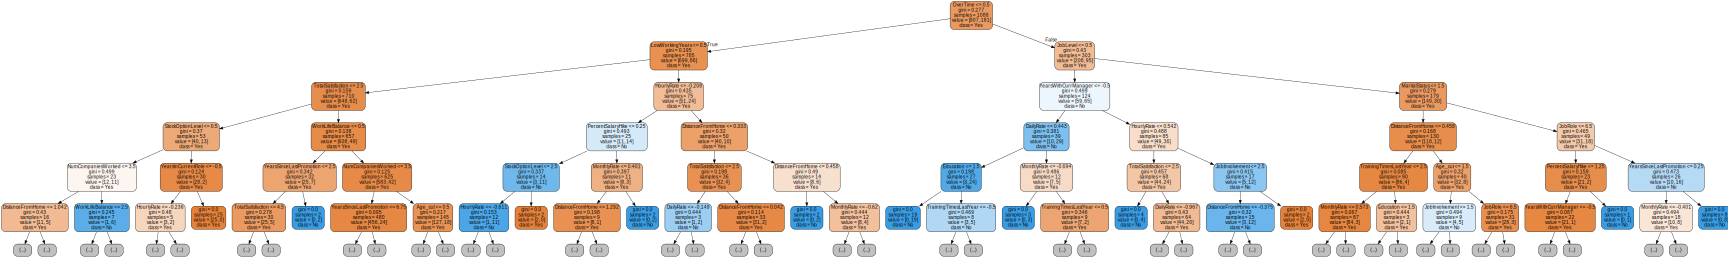

In [81]:
dot_data = export_graphviz(clf_best_model, out_file=None, 
                feature_names = X_train.columns,
                class_names = data.Attrition.unique(),
                max_depth = 5, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size("\"24\"")
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

- 의사결정나무의 장점은 알고리즘을 시각화 할수 있다는 뜻입니다.
- 맨위의 Feature인 Overtiem이 0.5 이상이면 True, 아니면 False이며, 지니불순도를 이용하여 클래스들의 섞임 정도를 확인합니다.(하나의 클래스에 몰려있다면 지니계수가 0과 가깝게 나옴)
- 그러다 마지막에 지니계수가 0이 되거나, 미리 설정한 파라미터에 의해 마지막 Depth가 되면 멈추게 되고, 마지막 클래스를 결정합니다.
- Class : 0혹은 1로 이루어진 종속변수값

<br>

### 6.2 랜덤포레스트
- 분류, 회귀 분석 등에 사용되는 앙상블 학습 방법의 일종으로 훈련 과정에서 구성한 다수의 결정트리로부터 분류 또는 평균 회귀 분석을 실행합니다.
- 여러개의 의사 결정 나무를 생성한 후에 다수결 또는 평균에 따라 출력 변수를 예측하는 알고리즘입니다. 즉 의사 결정 나무와 bagging을 혼합한 형태라고 볼 수 있습니다.
- Bagging은 샘플을 여러 번 뽑아 각 모델을 학습시켜 결과를 집계(Aggregating) 하는 방법입니다.
- 장점
    - 여러개의 의사결정트리의 결과를 가지고 최종결과를 결정하기에 과적합을 방지합니다. 
    - 따라서, 결측치의 비율이 높아져도 높은 정확도를 나타냅니다. 
    - 변수의 중요성을 파악할 수 있습니다.
- 단점
    - 데이터의 수가 많아지면 의사 결정나무에 비해 속도가 크게 떨어집니다. 
    - 여러개의 의사결정나무에서 나온 결과에 대해 최종 결과를 도출하므로, 최종 결과에 대한 해석이 어려운 단점이 있습니다. 

#### 6.2.1 기본 모델 생성 및 학습

In [82]:
rf_model = RandomForestClassifier(random_state=87)
params_grid = [{}]

gridsearch = GridSearchCV(
    estimator=rf_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=87), n_jobs=-1,
             param_grid=[{}], return_train_score=True)

- 랜덤포레스트의 모델을 기본 설정을 사용하여 생성하고 학습하였습니다.
- 의사결정나무와 마찬가지로 CV는 5회 하였습니다.

<br>

#### 6.2.2 학습 결과 저장

In [83]:
result.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'mean_train_score': float(gridsearch.cv_results_['mean_train_score']),
           'mean_test_score': float(gridsearch.cv_results_['mean_test_score'])})

- 추후 전체 결과에 대한 시각화를 위해 학습 결과를 저장합니다.

<br>

#### 6.2.3 예측 및 검증

Accuracy :  0.861
Recall :  0.196
Precision :  0.9
F1_Score :  0.321

Confusion_matrix :
[[226   1]
 [ 37   9]]


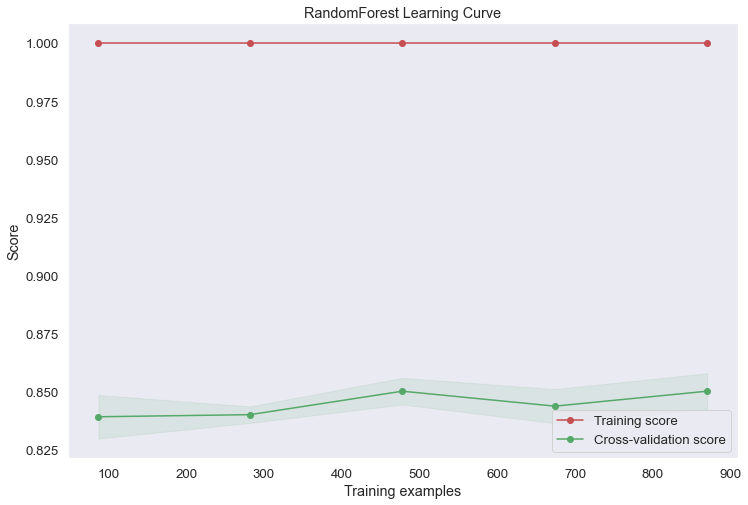

In [84]:
rf_best_model = gridsearch.best_estimator_
rf_best_model.fit(X_train, y_train)
rf_predict = rf_best_model.predict(X_test)

model_score(y_test, rf_predict)
plot_learning_curve(rf_best_model, 'RandomForest Learning Curve', X_train, y_train, cv=5)

- 의사결정나무와 마찬가지로 Learning Curve를 그려보았을때, 과대적합이 나타납니다.
- 하지만 검증 Accuracy는 의사결정나무보다 높습니다.
- 보통 랜덤포레스트가 의사결정나무보다는 더 나은 성능을 보입니다. 하지만 결과에 대한 해석이 어렵다는 단점이 있습니다.

<br>

#### 6.2. 4 중요 변수 확인

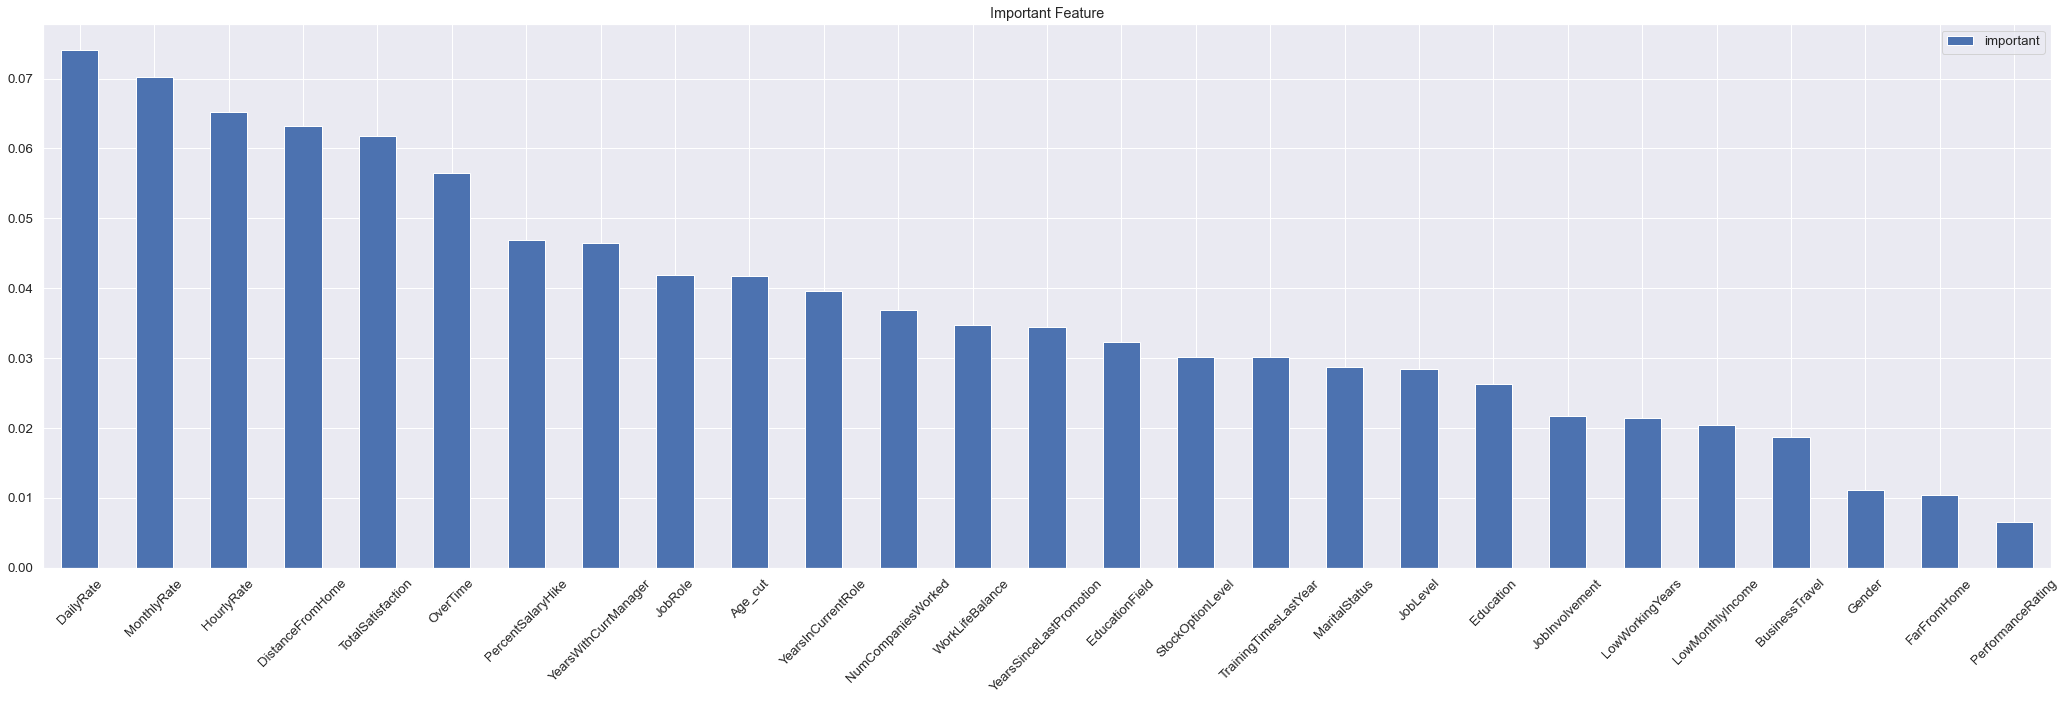

In [85]:
important = rf_best_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title ='Important Feature')
plt.show()

- 랜덤포레스트에서 중요하다고 나온 Feature들을 확인해보았습니다.
- 다행히 의사결정나무와는 다르게 중요하지 않다는 변수는 없습니다. 
- 위와 같은 사유로 하나의 모델을 보고 변수를 삭제하는것은 바람직 하지 않을수 있습니다.

<br>

#### 6.2.5 랜덤포레스트 시각화

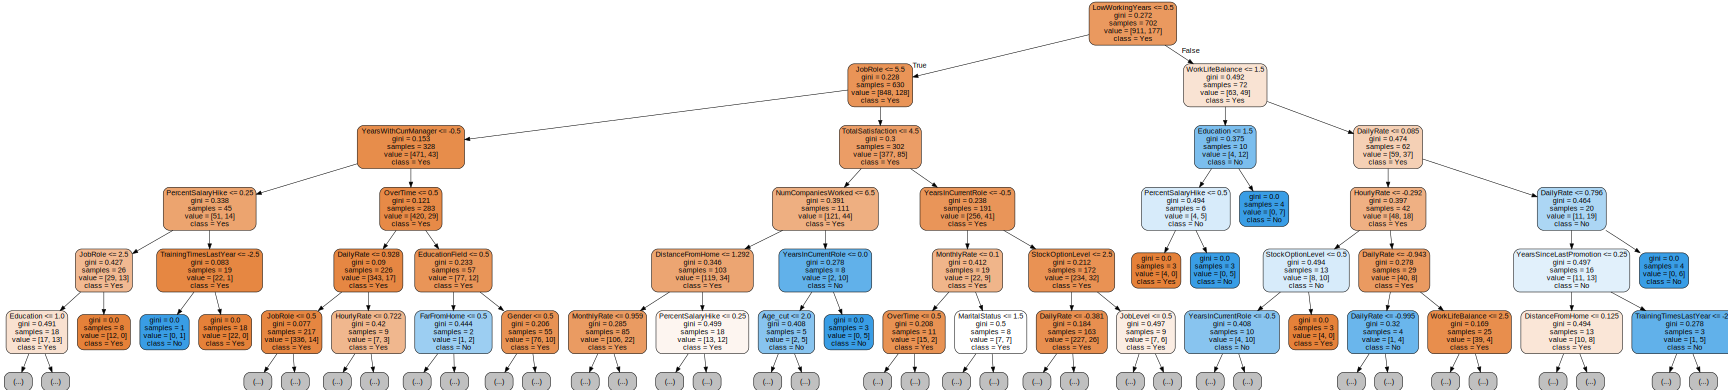

In [86]:
dot_data = export_graphviz(rf_best_model[0], out_file=None, 
                feature_names = X_train.columns,
                class_names = data.Attrition.unique(),
                max_depth = 5, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size("\"24\"")
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

- 랜덤포레스트도 트리기반이기 때문에 결정나무를 시각화하여 볼수 있습니다.
- 다만 Estimator의 갯수가 1개가 아닌, 많은 의사결정나무의 모임이기 때문에 대표되는 하나의 의사결정나무만 확인합니다.

<br>

### 6.3 로지스틱 회귀
- 독립 변수의 선형 결합을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 통계 기법입니다.
- 일반적인 회귀 분석의 목표와 동일하게 종속 변수와 독립 변수간의 관계를 구체적인 함수로 나타내어 향후 예측 모델에 사용합니다.
- 장점
    - 결과가 ‘0 또는 1’과 같이 이산 분포일 때 선형 회귀 모형의 문제점을 보완합니다.
    - 선형회귀와 다르게 바로 '값'이 아닌 '확률'로서 분류합니다. 시그모이드 함수를 사용하여 설정하는 확률값(0.5)에따라서 0과 1으로 분류 할수 있습니다.
- 단점
    - 선형회귀와 마찬가지로 독립변수와 종속변수가 선형 상관관계를 가지고 있다는 가정이 있어야 합니다.
    - 언더피팅되는 경향이 있습니다.

<br>

#### 6.3.1 기본 모델 생성 및 학습

In [87]:
lr_model = LogisticRegression(random_state=87)
params_grid = [{}]

gridsearch = GridSearchCV(
    estimator=lr_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=87), n_jobs=-1,
             param_grid=[{}], return_train_score=True)

- 로지스틱회귀 모델을 생성하고 학습하였습니다.
- 모델의 파라미터는 기본으로 설정하고, CV는 5회 진행합니다.

<br>

#### 6.3.2 학습 결과 저장

In [88]:
result.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'mean_train_score': float(gridsearch.cv_results_['mean_train_score']),
           'mean_test_score': float(gridsearch.cv_results_['mean_test_score'])})

- 추후 전체 결과를 시각화하여 표현하기 위해 결과를 저장합니다.

<br>

#### 6.3.3 예측 및 검증

Accuracy :  0.89
Recall :  0.457
Precision :  0.808
F1_Score :  0.583

Confusion_matrix :
[[222   5]
 [ 25  21]]


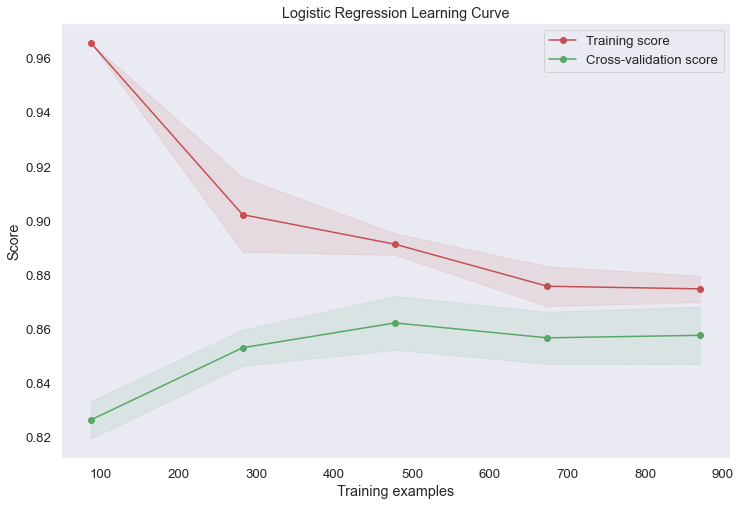

In [89]:
lr_best_model = gridsearch.best_estimator_
lr_best_model.fit(X_train, y_train)
lr_predict = lr_best_model.predict(X_test)

model_score(y_test, lr_predict)
plot_learning_curve(lr_best_model,
                    'Logistic Regression Learning Curve', X_train, y_train, cv=5)

- 생성된 최적의 모델로 검증을 진행합니다.
- Accuracy도 높게 나오고, 과적합이 일어나지 않습니다. 생각보다 괜찮은것 같습니다

<br>

#### 6.3.4 중요 변수 확인

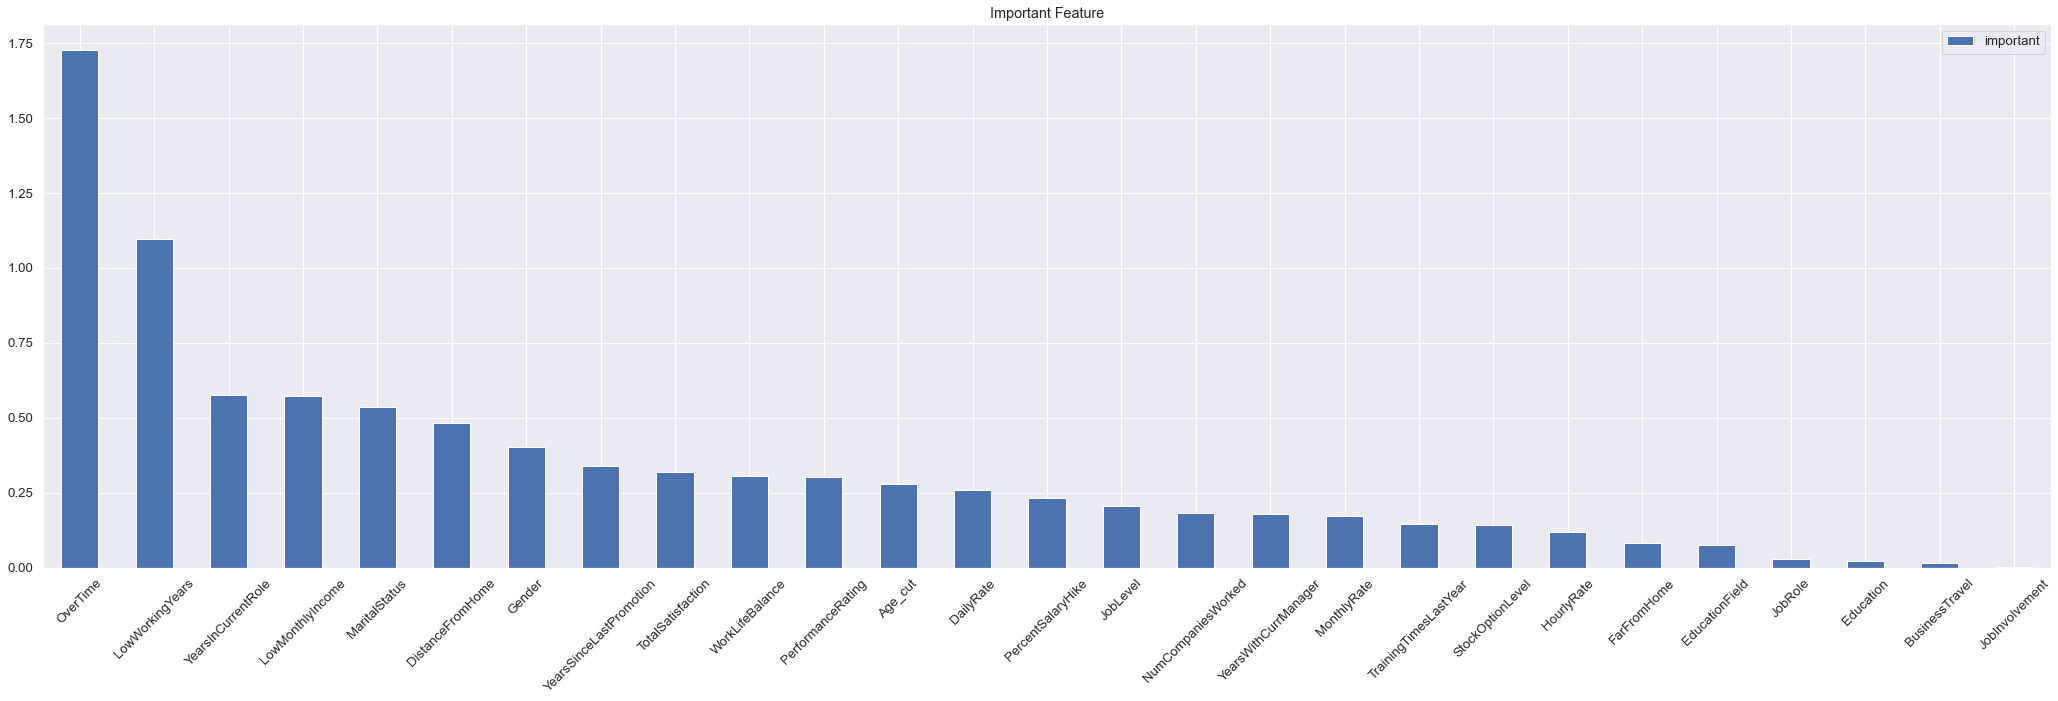

In [90]:
coefs = np.abs(lr_best_model.coef_[0])
pd.DataFrame(coefs, X_train.columns, columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Important Feature')
plt.show()

- 로지스틱 회귀에서 중요한 변수들을 확인합니다.
- 로지스틱 회귀의 중요도 점수는 음수를 가질수 있기에, np.abs를 사용하여 절대값으로 비교하였습니다.
- 현재의 그래프에서는 중요한 순서와 점수만 알수 있을뿐, 절대값을 주었기에 음수인지 양수인지는 확인 불가합니다.
- 음수와 양수를 나누려면 절대값코드를 제거하면 됩니다.

<br>

### 6.4 XGBoost
- Decision tree를 기반으로 한 Ensemble 방법으로 Boosting을 기반으로 하는 머신러닝 방법입니다.
- Boosting은 여러개의 알고리즘이 순차적으로 학습을 하되 앞에 학습한 알고리즘 예측이 틀린 데이터에 대해 올바르게 예측할수 있도록 그 다음번 알고리즘에 가중치를 부여하여 학습과 예측을 진행하는 방식입니다.
- 장점
    - GBM 기반의 알고리즘의 느린속도를 다양한 규제를 통해 해결하여 속도가 빠릅니다.
    - 병렬 학습이 가능하도록 설계됨
    - XGBoost는 반복 수행시 마다 내부적으로 학습데이터와 검증데이터를 교차검증으로 수행합니다.
    - 교차검증을 통해 최적화되면 반복을 중단하는 조기 중단 기능이 있습니다.
- 단점
    - GBM보다는 빠르지만, 여전히 느립니다. 

#### 6.4.1 기본 모델 생성 및 학습

In [91]:
xgb_model = xgb.XGBClassifier(random_state = 87)

params_grid = [{}]

gridsearch = GridSearchCV(
    estimator=xgb_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=87,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

- XGBoost를 기본 파라미터를 사용하여 생성합니다.
- 마찬가지로 CV는 5회 합니다.

<br>

#### 6.4.2 학습 결과 및 저장

In [92]:
result.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'mean_train_score': float(gridsearch.cv_results_['mean_train_score']),
           'mean_test_score': float(gridsearch.cv_results_['mean_test_score'])})

- 추후 전체 결과를 시각화하기 위해 학습 결과를 저장합니다.

<br>

#### 6.4.3 예측 및 검증

Accuracy :  0.883
Recall :  0.435
Precision :  0.769
F1_Score :  0.556

Confusion_matrix :
[[221   6]
 [ 26  20]]


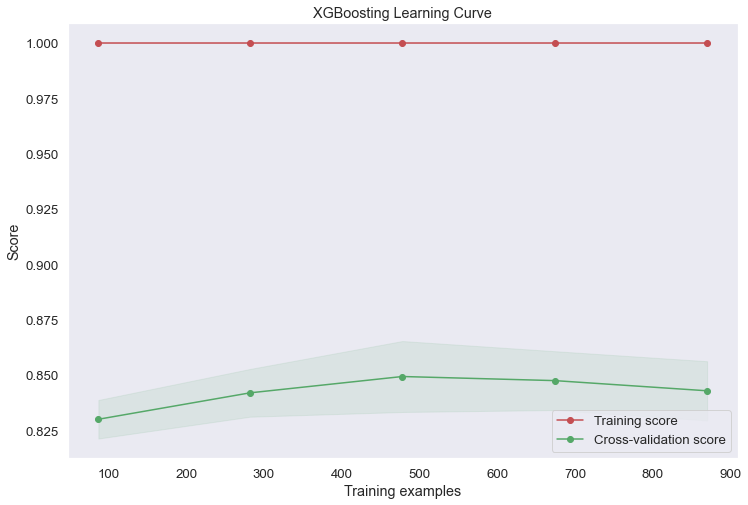

In [93]:
xgb_best_model = gridsearch.best_estimator_
xgb_best_model.fit(X_train, y_train)
xgb_predict = xgb_best_model.predict(X_test)

model_score(y_test, xgb_predict)
plot_learning_curve(xgb_best_model,
                    'XGBoosting Learning Curve', X_train, y_train, cv=5)

- Learning Curve를 확인한 결과 학습은 잘되었지만, 검증과는 차이가 많이 납니다.
- 역시나 과대 적합 같습니다.

<br>

#### 6.4.4 중요 변수 확인

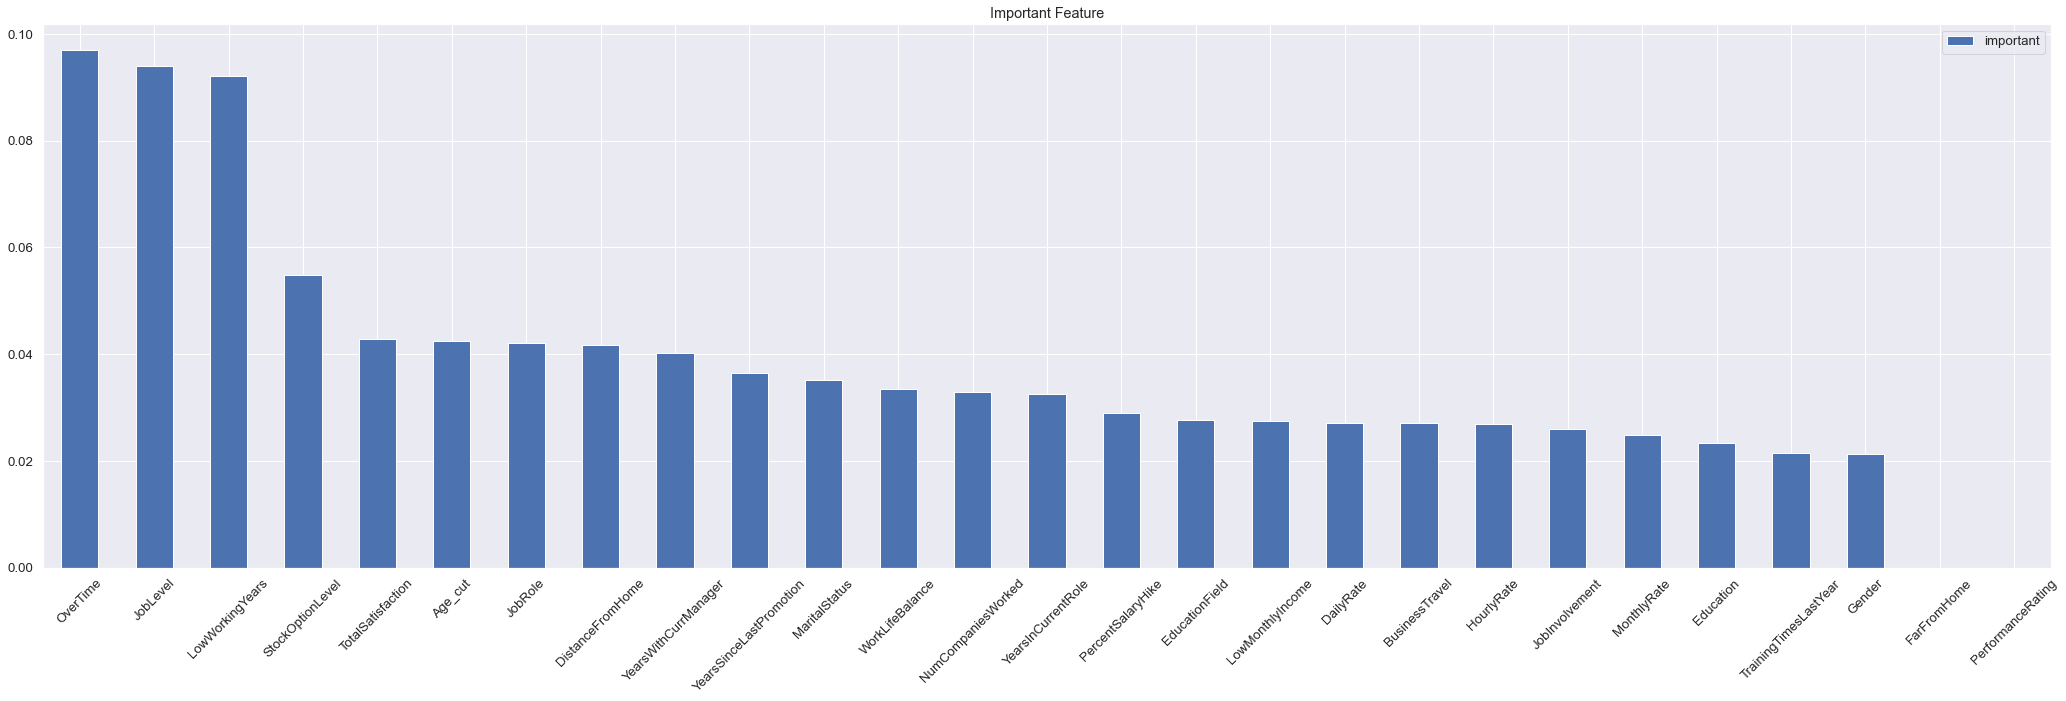

In [94]:
important = xgb_best_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Important Feature')
plt.show()

- XGBoost에서의 중요 Feature들을 확인해 보았습니다.
- Overtime이 모든 모델에 있어 중요한 변수로 확인됩니다.


### 6.5 LightGBM
- LightGBM은 XGBoost와 함께 부스팅 계열에서 가장 각광받는 알고리즘으로, XGBoost에서 속도 및 편의 등을 개선하여 나온 알고리즘입니다.
- 장점
    - LGBM의 큰 장점은 속도입니다. GBM 계열중에 제일 빠릅니다.
    - XGBoost보다 학습에 걸리는 시간이 훨씬 적으며, 메모리 사용량도 상대적으로 적다.
    - XGBoost와 마찬가지로 대용량 데이터에 대한 뛰어난 성능 및 병렬컴퓨팅 기능을 제공하고 최근에는 추가로GPU까지 지원한다.
- 단점
    - 적은 수의 데이터에는 어울리지 않으며, 데이터가 적으면 과적합에 쉽게 걸린다. (일반적으로 10000건 이상의 데이터가 필요하다고 함)

#### 6.5.1 기본 모델 생성 및 학습

In [95]:
lgbm_model = LGBMClassifier(random_state = 87)
params_grid = [{}]

gridsearch = GridSearchCV(
    estimator=lgbm_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=87), n_jobs=-1,
             param_grid=[{}], return_train_score=True)

- LightGBM 모델을 기본 파라미터로 생성 합니다.
- 마찬가지로 CV는 5회 합니다.

<br>

#### 6.5.2 학습 결과 저장

In [96]:
result.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'mean_train_score': float(gridsearch.cv_results_['mean_train_score']),
           'mean_test_score': float(gridsearch.cv_results_['mean_test_score'])})

- 전체 모델에 대한 시각화를 위해 학습 결과를 저장합니다.

<br>

#### 6.5.3 예측 및 검증

Accuracy :  0.864
Recall :  0.348
Precision :  0.696
F1_Score :  0.464

Confusion_matrix :
[[220   7]
 [ 30  16]]


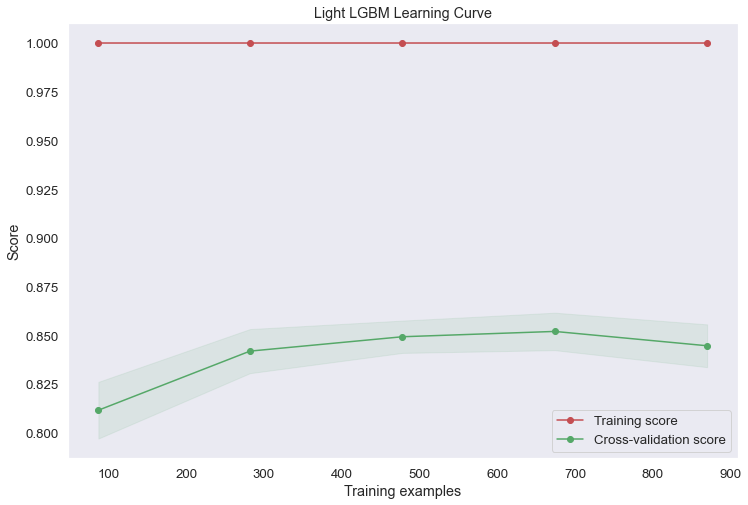

In [97]:
lgbm_best_model = gridsearch.best_estimator_
lgbm_best_model.fit(X_train, y_train)
lgbm_predict = lgbm_best_model.predict(X_test)

model_score(y_test, lgbm_predict)
plot_learning_curve(lgbm_best_model, 'Light LGBM Learning Curve', X_train, y_train, cv=5)

- Learning Curve를 확인한 결과 역시나 과대적합입니다.
- 트리기반의 모델은 대부분 과대적합을 가지는 단점을 가지고 있습니다.

<br>

#### 6.5.4 중요 변수 확인

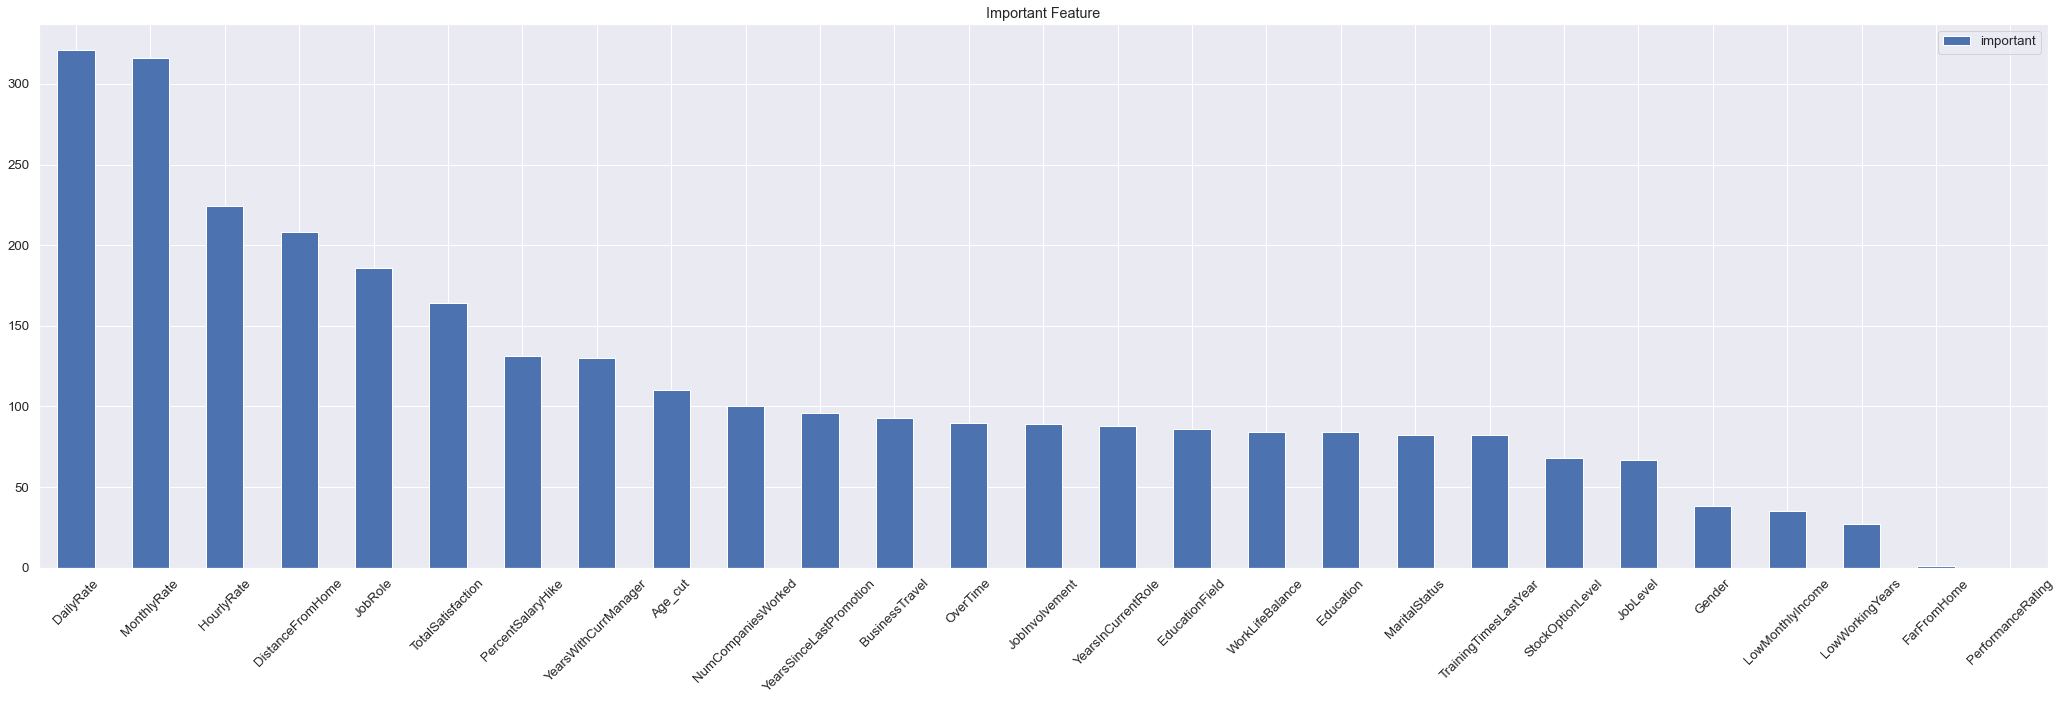

In [98]:
important = lgbm_best_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Important Feature')
plt.show()

- LightGBM의 중요변수를 확인하였습니다.
- Rate의 변수들이 모두 중요하다고 한것이 특이한 점입니다.

<Br>

### 6.6 ROC Curve

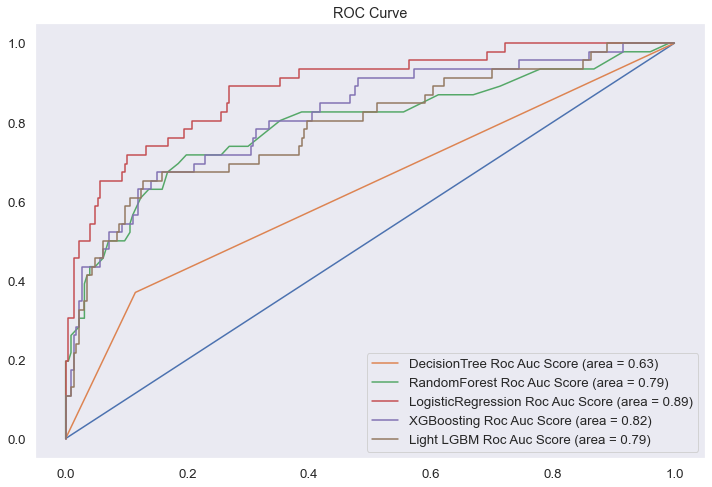

In [99]:
clf_pred_proba = clf_best_model.predict_proba(X_test)[:, 1]
clf_fpr, clf_tpr, thresholds = roc_curve(y_test, clf_pred_proba)
clf_roc_auc = roc_auc_score(y_test, clf_pred_proba)

rf_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_pred_proba)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

lr_pred_proba = lr_best_model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_pred_proba)
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba)

xgb_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_pred_proba)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

lgbm_pred_proba = gridsearch.best_estimator_.predict_proba(X_test)[:, 1]
lgbm_fpr, lgbm_tpr, thresholds = roc_curve(y_test, lgbm_pred_proba)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_pred_proba)



plt.figure(figsize=(12, 8))
plt.title('ROC Curve')

plt.plot([0,1], [0,1])

plt.plot(clf_fpr, clf_tpr, label='DecisionTree Roc Auc Score (area = %0.2f)' % clf_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='RandomForest Roc Auc Score (area = %0.2f)' % rf_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='LogisticRegression Roc Auc Score (area = %0.2f)' % lr_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoosting Roc Auc Score (area = %0.2f)' % xgb_roc_auc)
plt.plot(lgbm_fpr, lgbm_tpr, label='Light LGBM Roc Auc Score (area = %0.2f)' % lgbm_roc_auc)


plt.grid()
plt.legend(loc="lower right")
plt.show()

- 전체 모델의 ROC Curve와 AUC점수를 확인해 보았습니다.
- ROC Curve는 그래프가 반대 ㄱ모양으로 생기는게 가장 이상적인 모양입니다.
- AUC 점수는 ROC Curve의 아래 면적입니다. 1에 가까울수록 높은 수치 입니다.
- 역시나 의사결정나무가 가장 낮고, 로지스틱회귀가 가장 높으며 나머지는 비슷합니다.

<br>

### 6.7 Accuracy 비교

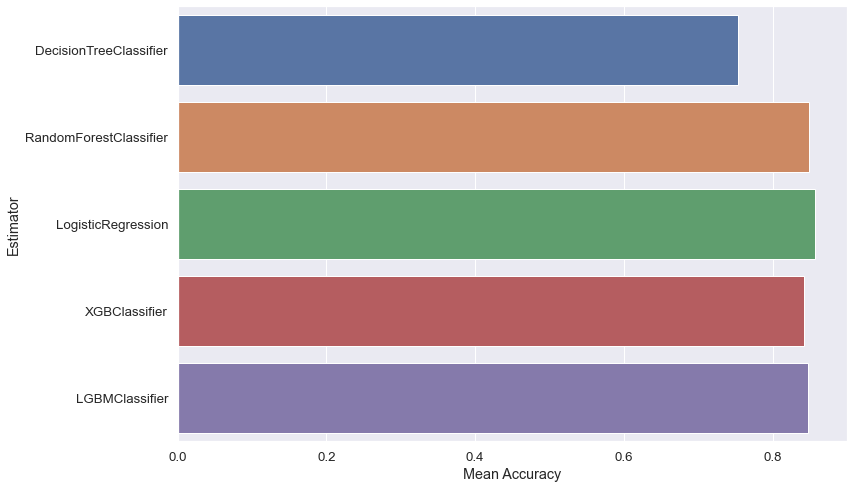

In [102]:
df = pd.DataFrame(result)

plt.figure(figsize=(12, 8))
g = sns.barplot('mean_test_score','Estimator', data = df)
g.set_xlabel("Mean Accuracy")
plt.show()

- 전체 모델의 Validation Accuracy를 시각화 하였습니다.
- 의사결정나무를 제외하고는 다들 비슷한 성능을 보입니다.

<br>

## 7. Hyperparameter Tuning
---

### 7.1 Decision Tree Hyperparameter Tuning

#### 7.1.1 튜닝 모델 생성 및 학습

In [103]:
clf_model = DecisionTreeClassifier(random_state=87)

params_grid = [{
    'max_depth': [5, 7, 9, 11], # 얼마나 깊게 들어가는지.
    'min_samples_split': [1, 2, 3, 4, 5], # 노드를 분할하기 위한 최소한의 샘플 데이터수 → 과적합을 제어하는데 사용
}]


gridsearch = GridSearchCV(
    estimator=clf_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=87), n_jobs=-1,
             param_grid=[{'max_depth': [5, 7, 9, 11],
                          'min_samples_split': [1, 2, 3, 4, 5]}],
             return_train_score=True)

- 의사결정나무의 파라미터를 튜닝하여 생성합니다.
- 파라미터는 그리드서치를 사용하여 최적의 파라미터를 찾게 하였습니다.
- 사용한 파라미터는 max_depth와 min_samples_split 입니다.

<Br>

#### 7.1.2 학습 결과 저장

In [104]:
result_hyper = []
result_hyper.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'hyper_mean_train_score': np.nanmean(gridsearch.cv_results_['mean_train_score']).astype(float),
           'hyper_mean_test_score': np.nanmean(gridsearch.cv_results_['mean_test_score']).astype(float)})

- 추후에 전체 모델에 대한 학습한 결과를 시각화하기 위해 저장합니다.

<br>

#### 7.1.3 예측 및 검증

Accuracy :  0.799
Recall :  0.37
Precision :  0.395
F1_Score :  0.382

Confusion_matrix :
[[201  26]
 [ 29  17]]


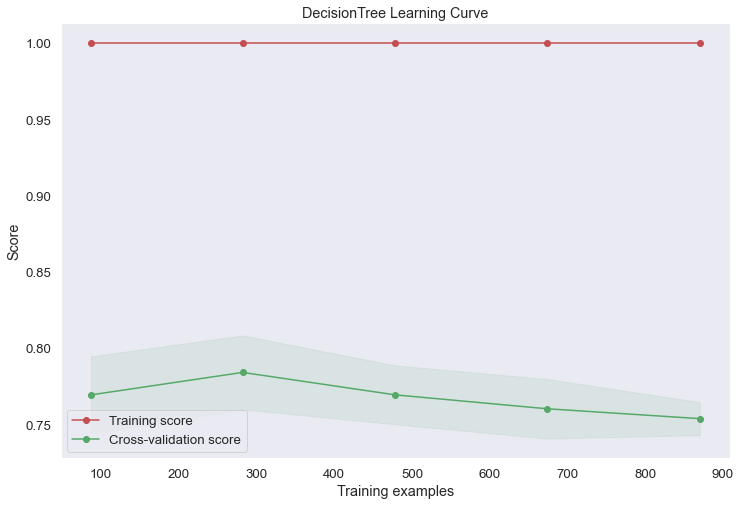

Accuracy :  0.832
Recall :  0.37
Precision :  0.5
F1_Score :  0.425

Confusion_matrix :
[[210  17]
 [ 29  17]]


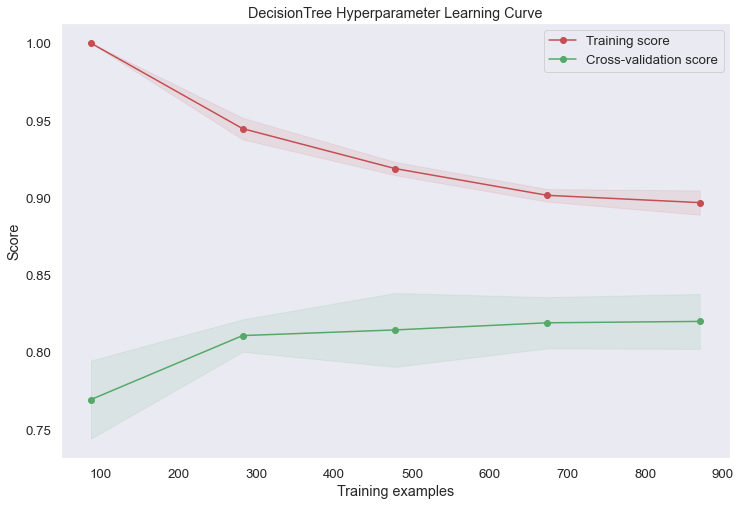

In [105]:
clf_hyper_model = gridsearch.best_estimator_
clf_hyper_model.fit(X_train, y_train)
clf_hyper_predict = clf_hyper_model.predict(X_test)

model_score(y_test, clf_predict)
plot_learning_curve(clf_best_model, 'DecisionTree Learning Curve', X_train, y_train, cv=5)

model_score(y_test, clf_hyper_predict)
plot_learning_curve(clf_hyper_model, 'DecisionTree Hyperparameter Learning Curve', X_train, y_train, cv=5)

- 파라미터를 튜닝한뒤 결과를 확인합니다.
- 확실히 학습에 규제를 주었기 때문에 Learning Curve가 서로 만나려고 합니다.
- 튜닝전과 후의 결과도 전체적으로 나은 모습을 보입니다.

<br>

In [126]:
clf_hyper_model

DecisionTreeClassifier(max_depth=5, random_state=87)

#### 7.1.4 중요 변수 확인

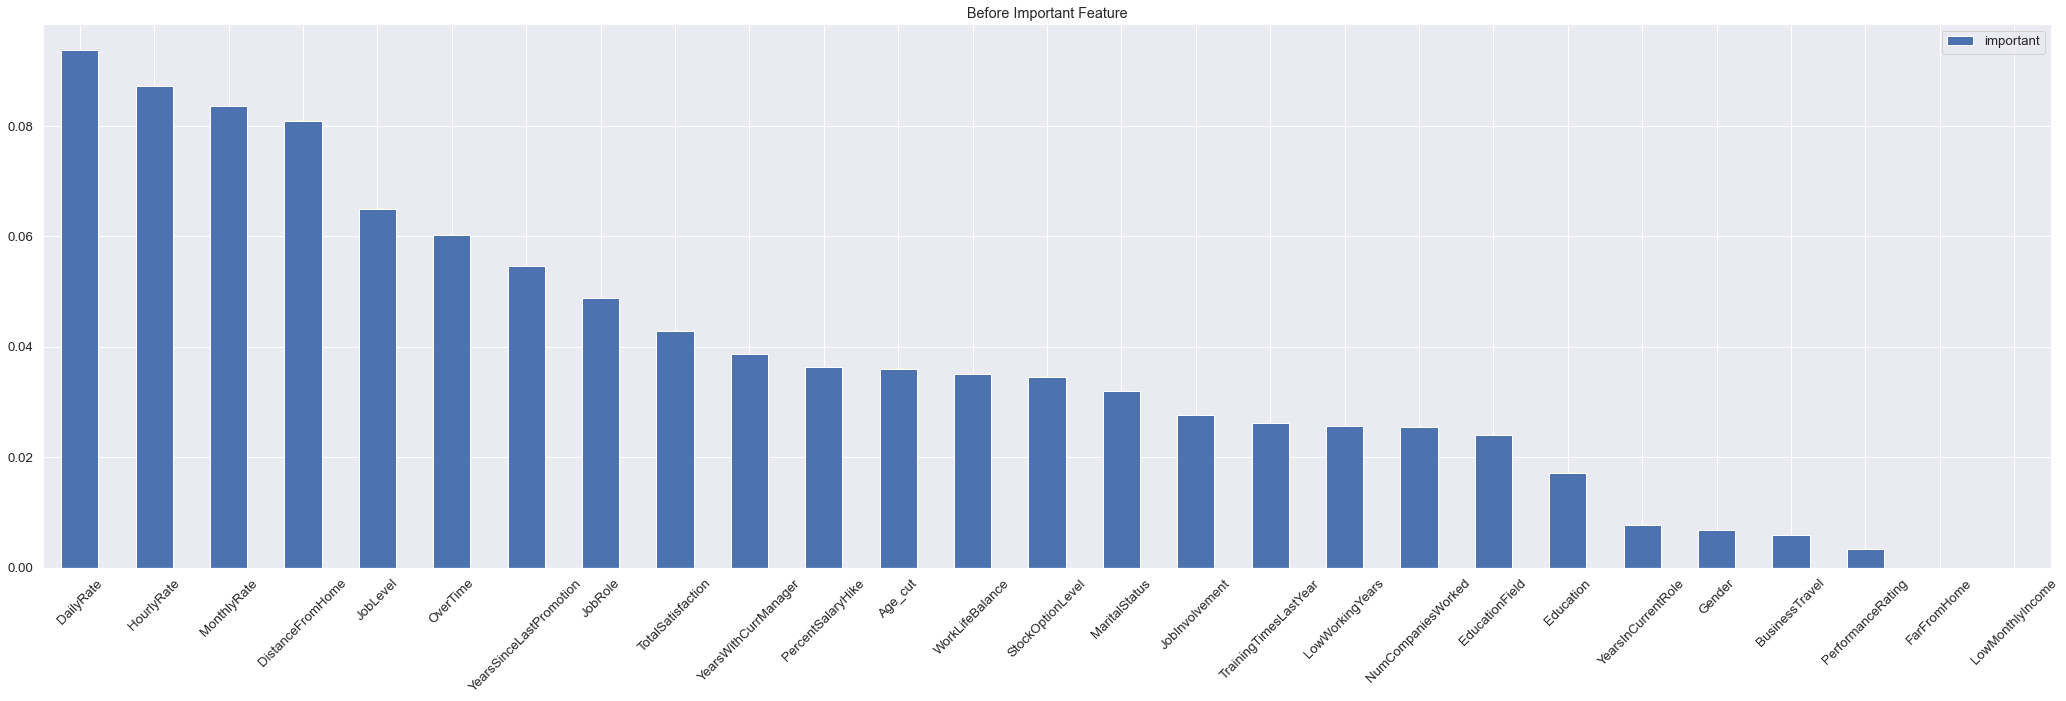

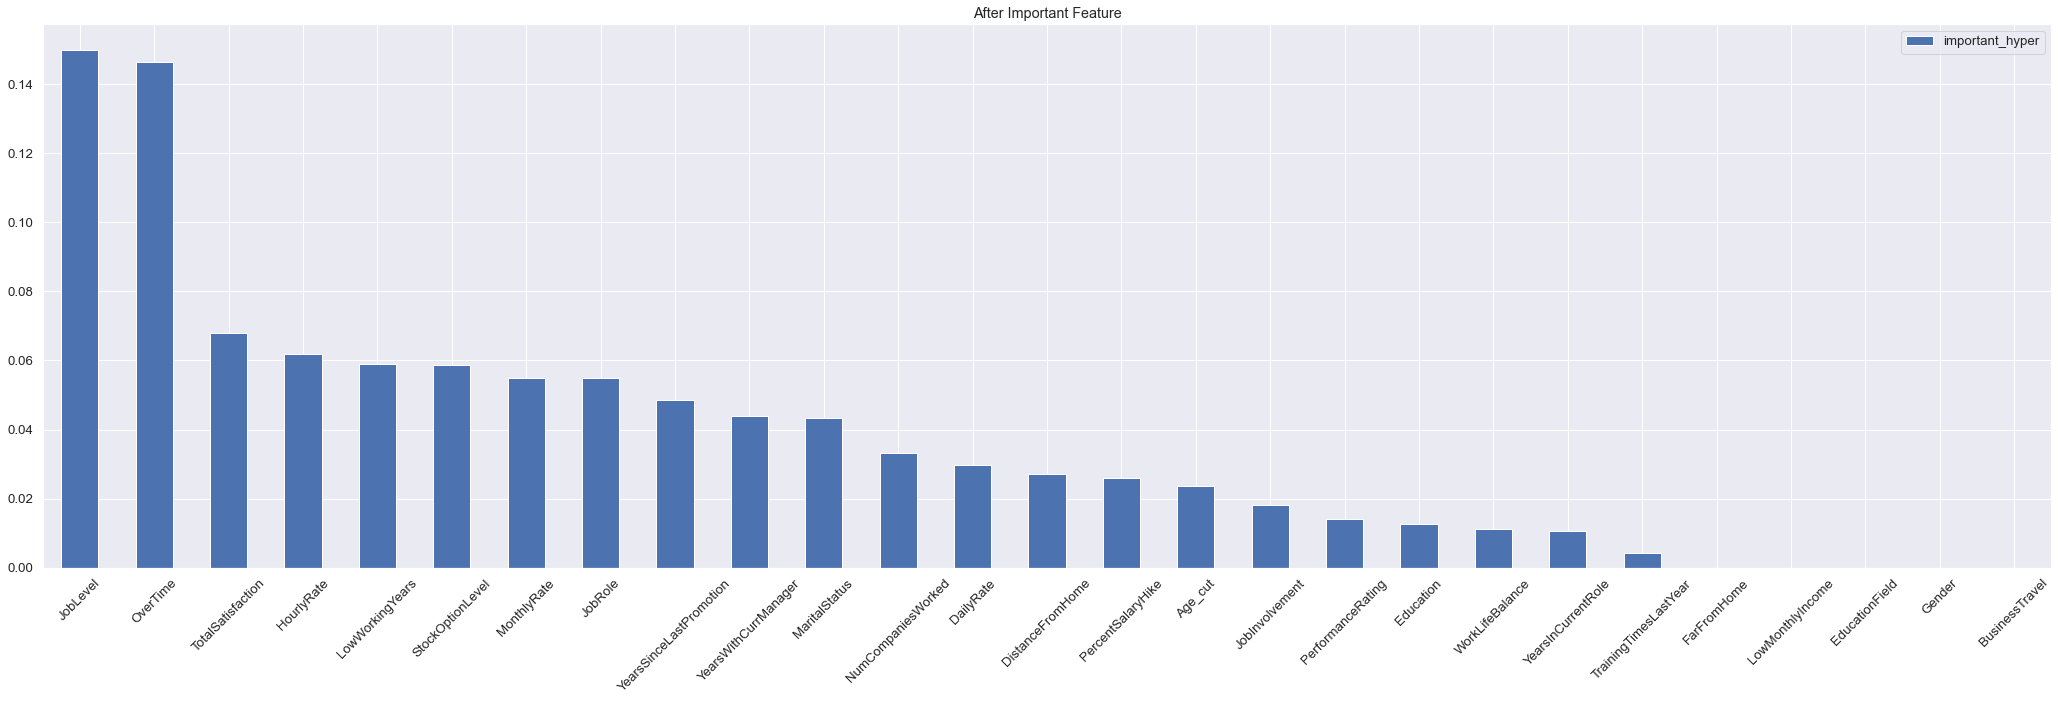

In [106]:
important = clf_best_model.feature_importances_
important_hyper = clf_hyper_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Before Important Feature')
pd.DataFrame(important_hyper, X_train.columns,columns=['important_hyper']).sort_values(by = 'important_hyper', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'After Important Feature')
plt.show()

- 파라미터를 튜닝하기 전과 튜닝 후의 중요변수를 확인해보았습니다.
- 튜닝전에는 Rate 계열의 변수가 중요했다면, 지금은 Overtime과 같은 변수가 중요해지는 등의 변화가 보입니다.

<br>

#### 7.1.5 결정나무 시각화

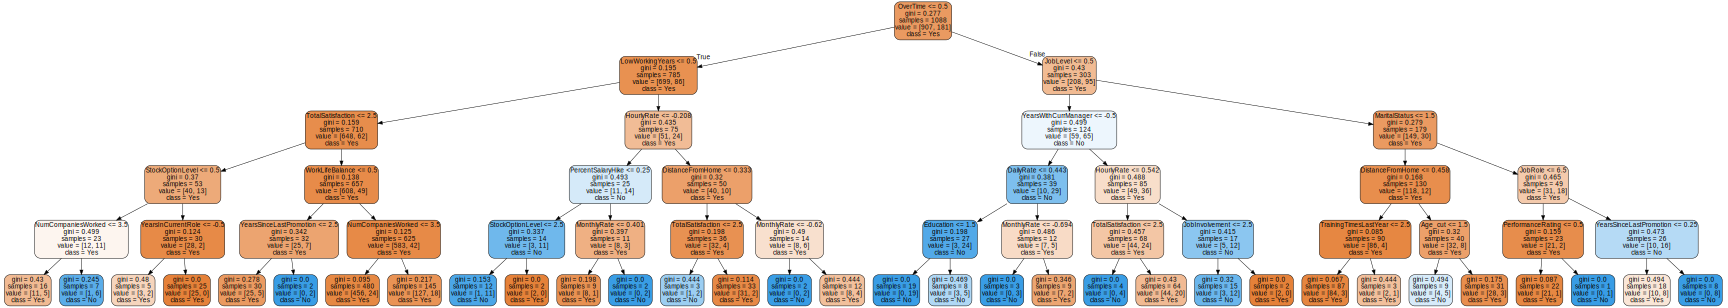

In [107]:
dot_data = export_graphviz(clf_hyper_model, out_file=None, 
                feature_names = X_train.columns,
                class_names = data.Attrition.unique(),
                max_depth = 5, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size("\"24\"")
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

- 이번에도 결정나무를 시각화 하였습니다.
- Max depth에 대해 규제를 주었기에 모든 결과를 볼수 있었습니다.

<br>

### 7.2 RandomForest Hyperparameter Tuning

#### 7.2.1 튜닝 모델 생성 및 학습

In [108]:
rf_model = RandomForestClassifier(random_state=87)

params_grid = [{'n_estimators': [10, 50, 150], # 의사결정나무의 갯수
                'max_features': [0.3, 0.7], # 선택할 특성의 수
                'max_depth': [2, 4, 6, 8], # 얼마나 깊게 들어가는지
                'min_samples_split': [2, 4, 6, 8], # 노드를 분할하기 위한 최소 샘플 수
                'min_samples_leaf': [2, 4, 6, 8], # 한 노드에서 가지고 있어야 하는 최소 샘플 수
                }]

gridsearch = GridSearchCV(
    estimator=rf_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=87), n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 6, 8], 'max_features': [0.3, 0.7],
                          'min_samples_leaf': [2, 4, 6, 8],
                          'min_samples_split': [2, 4, 6, 8],
                          'n_estimators': [10, 50, 150]}],
             return_train_score=True)

- 그리드 서치를 이용하여 최적의 파라미터를 가진 모델을 찾습니다.
- 파라미터는 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf를 사용하였습니다.

<br>

#### 7.2.2 학습 결과 저장

In [109]:
result_hyper.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'hyper_mean_train_score': np.nanmean(gridsearch.cv_results_['mean_train_score']).astype(float),
           'hyper_mean_test_score': np.nanmean(gridsearch.cv_results_['mean_test_score']).astype(float)})

- 전체 모델의 결과를 시각화하기 위해 학습 결과를 저장합니다.

<br>

#### 7.2.3 예측 및 검증

In [128]:
rf_hyper_model

RandomForestClassifier(max_depth=8, max_features=0.3, min_samples_leaf=2,
                       n_estimators=50, random_state=87)

Accuracy :  0.861
Recall :  0.196
Precision :  0.9
F1_Score :  0.321

Confusion_matrix :
[[226   1]
 [ 37   9]]


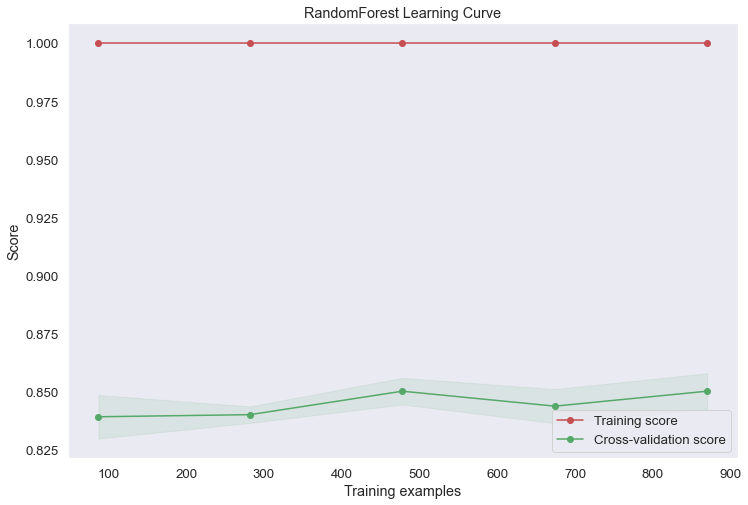

Accuracy :  0.864
Recall :  0.196
Precision :  1.0
F1_Score :  0.327

Confusion_matrix :
[[227   0]
 [ 37   9]]


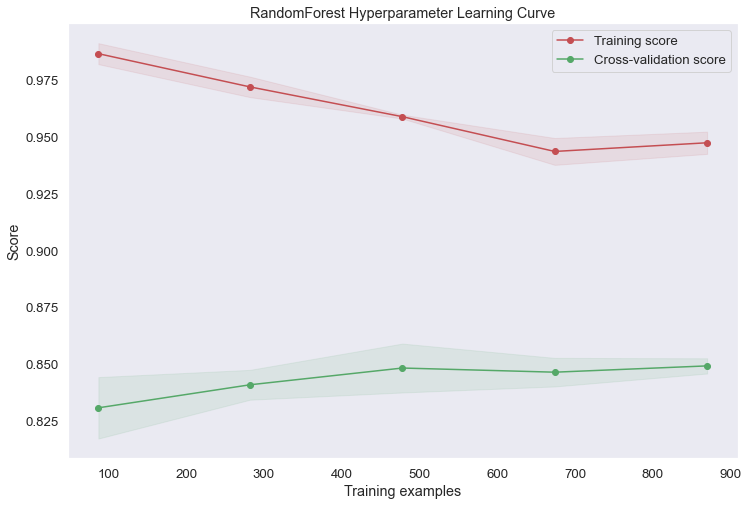

In [110]:
rf_hyper_model = gridsearch.best_estimator_
rf_hyper_model.fit(X_train, y_train)
rf_hyper_predict = rf_hyper_model.predict(X_test)

model_score(y_test, rf_predict)
plot_learning_curve(rf_best_model,
                    'RandomForest Learning Curve', X_train, y_train, cv=5)
model_score(y_test, rf_hyper_predict)
plot_learning_curve(rf_hyper_model,
                    'RandomForest Hyperparameter Learning Curve', X_train, y_train, cv=5)

- 파라미터 튜닝을 하여 찾은 최적의 모델을 사용하여 Learning Curve를 확인하였습니다.
- 확실히, 이전보다 성능도 좋아지고, 학습곡선도 잘 나옵니다.

<br>

#### 7.2.4 중요 변수 확인

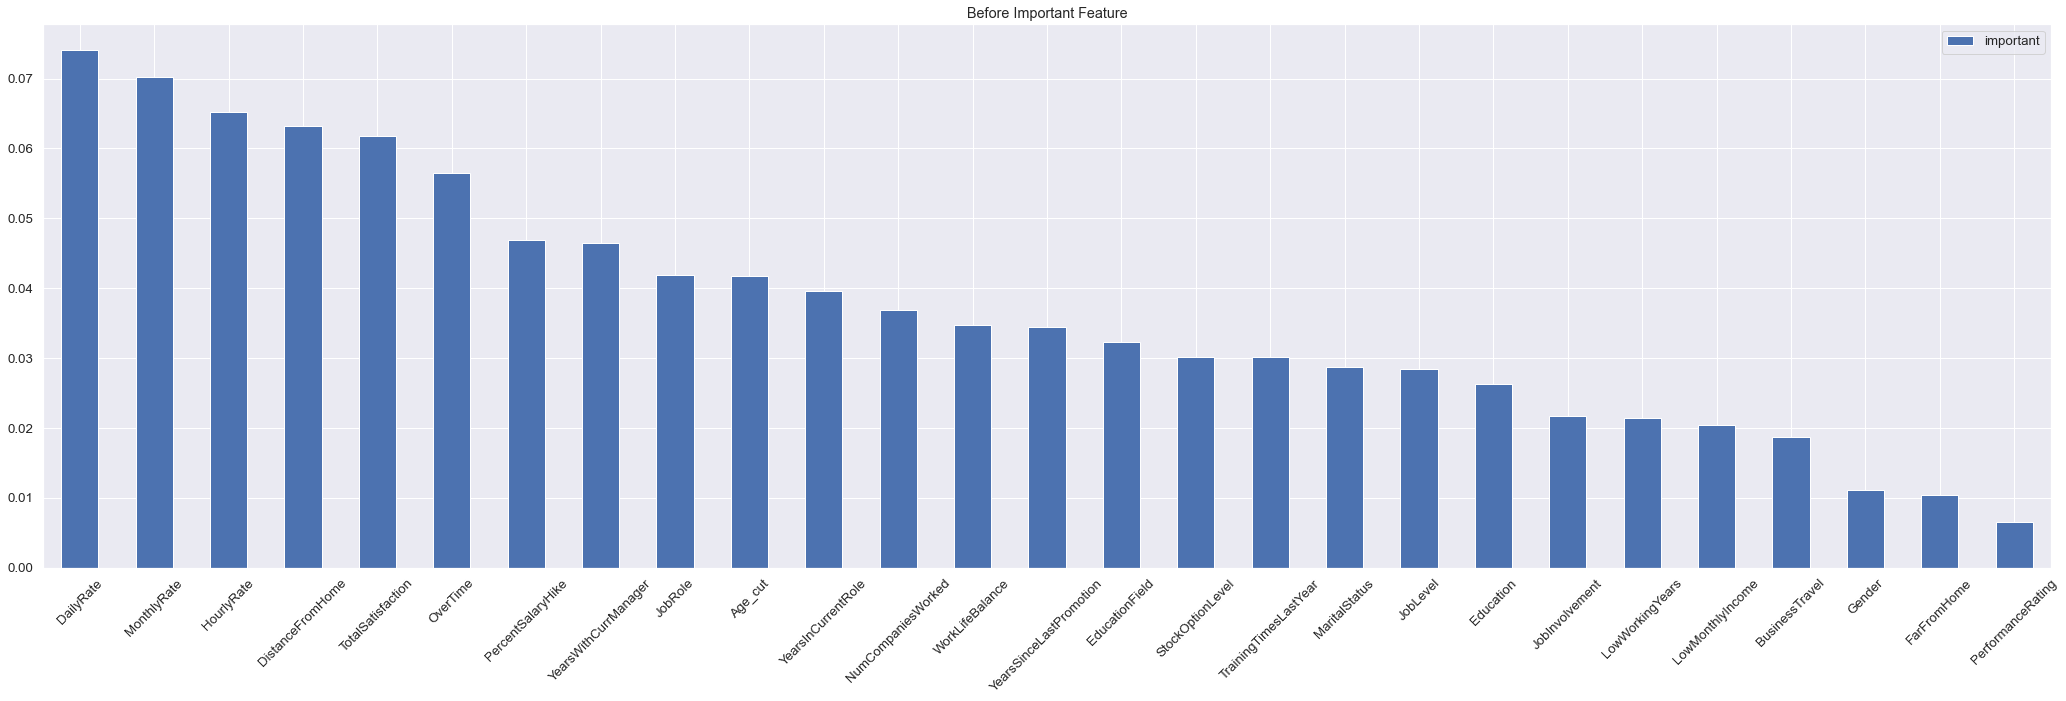

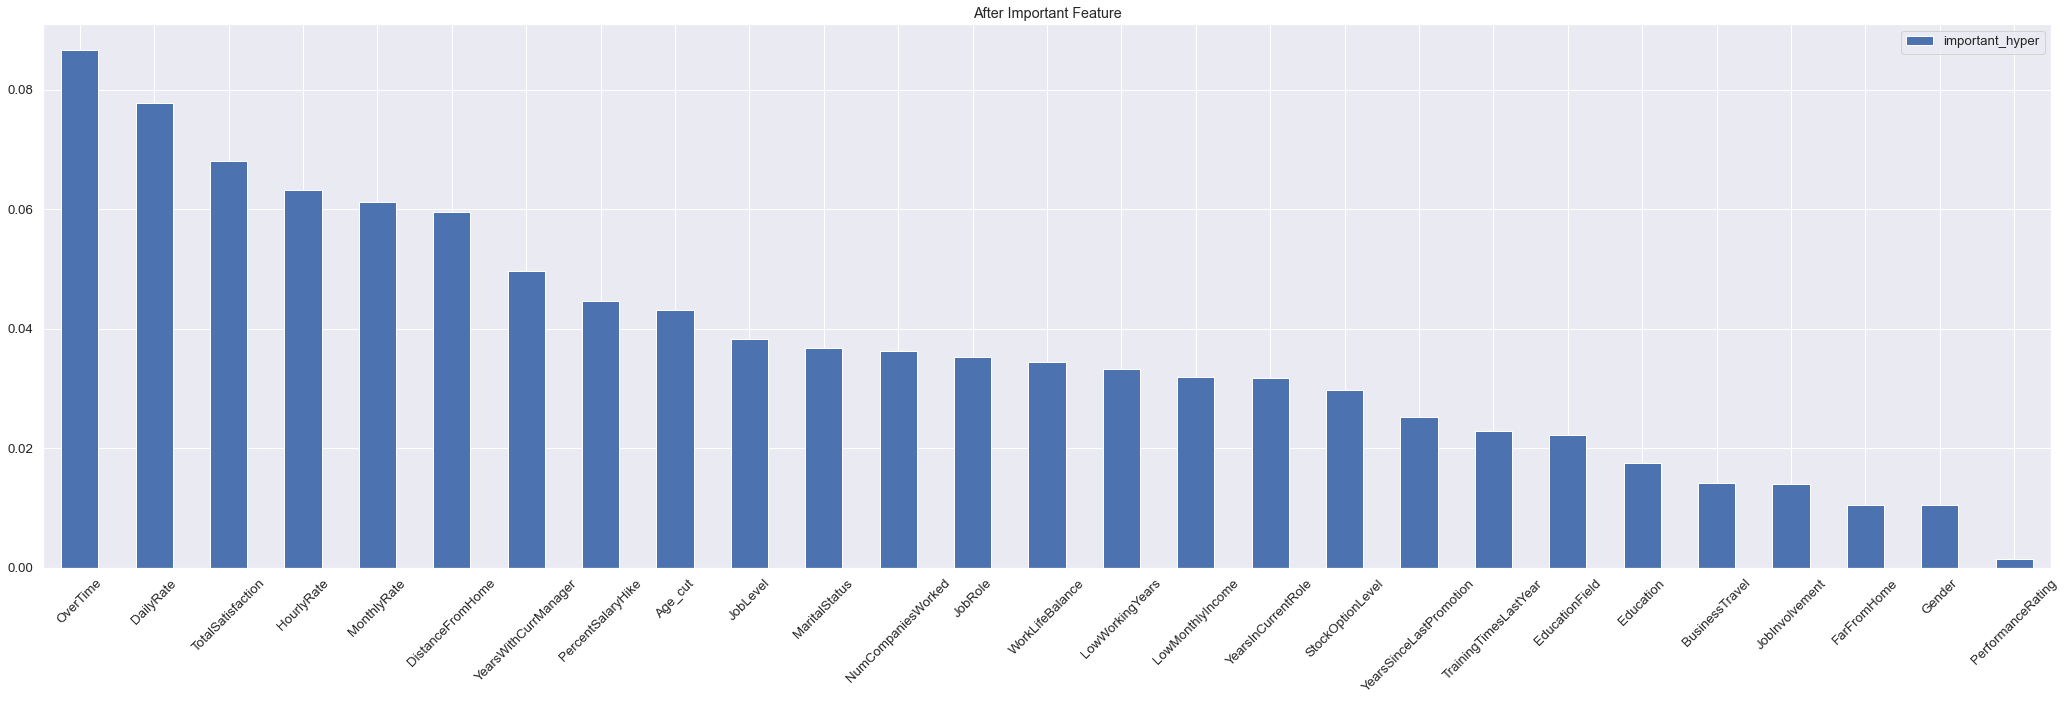

In [111]:
important = rf_best_model.feature_importances_
important_hyper = rf_hyper_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Before Important Feature')
pd.DataFrame(important_hyper, X_train.columns,columns=['important_hyper']).sort_values(by = 'important_hyper', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'After Important Feature')
plt.show()

- 파라미터를 튜닝하기전과 하고난 뒤의 중요 Feature들을 비교합니다.
- 마찬가지로 Overtime이 상위로 올라왔습니다.

<br>

#### 7.2.5 결정나무 시각화

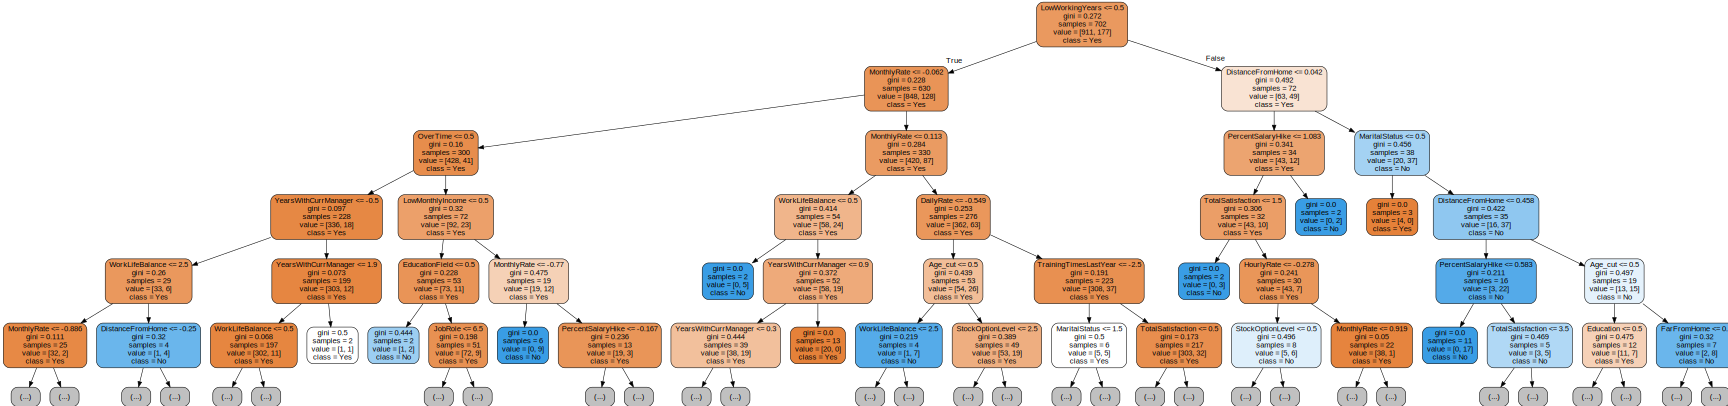

In [112]:
dot_data = export_graphviz(rf_hyper_model[0], out_file=None, 
                feature_names = X_train.columns,
                class_names = data.Attrition.unique(),
                max_depth = 5, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size("\"24\"")
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

- 랜덤포레스트의 결정나무중 하나를 가져와서 확인해봅니다.
- 이번에는 LowWorkingYears 변수를 시작하여 노드들이 나갑니다.

<br>

### 7.3 Logistic Regression Hyperparameter Tuning

#### 7.3.1 튜닝 모델 생성 및 학습

In [113]:
lr_model = LogisticRegression(random_state=87, class_weight='balance')

params_grid = [{
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'library',  'sag', 'saga'], # 최적화에 사용할 알고리즘
    'C': [0.01, 0.1, 1, 5, 10], # 규칙강도의 역수 값
    'max_iter': list(range(1, 1000, 50)) # solver가 수렴하게 만드는 최대 반복값
}]

gridsearch = GridSearchCV(
    estimator=lr_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balance',
                                          random_state=87),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10],
                          'max_iter': [1, 51, 101, 151, 201, 251, 301, 351, 401,
                                       451, 501, 551, 601, 651, 701, 751, 801,
                                       851, 901, 951],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                     'library', 'sag', 'saga']}],
             return_train_score=True)

- 로지스틱 회귀를 마찬가지로 그리드 서치를 사용하여 생성합니다.
- solver, C, max_iter의 파라미터를 사용하였습니다.

<br>

#### 7.3.2 학습 결과 저장

In [114]:
result_hyper.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'hyper_mean_train_score': np.nanmean(gridsearch.cv_results_['mean_train_score']).astype(float),
           'hyper_mean_test_score': np.nanmean(gridsearch.cv_results_['mean_test_score']).astype(float)})

- 추후 전체 데이터 시각화를 위해 학습결과를 저장합니다.

<Br>

#### 7.3.3 예측 및 검증

Accuracy :  0.89
Recall :  0.457
Precision :  0.808
F1_Score :  0.583

Confusion_matrix :
[[222   5]
 [ 25  21]]


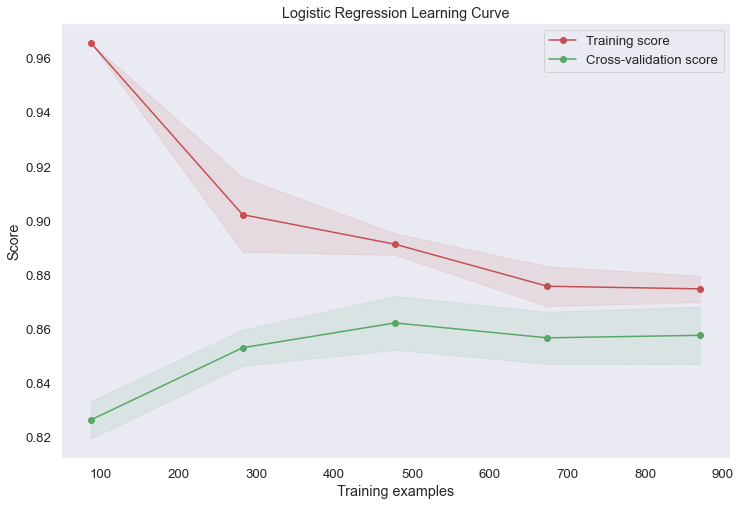

Accuracy :  0.894
Recall :  0.478
Precision :  0.815
F1_Score :  0.603

Confusion_matrix :
[[222   5]
 [ 24  22]]


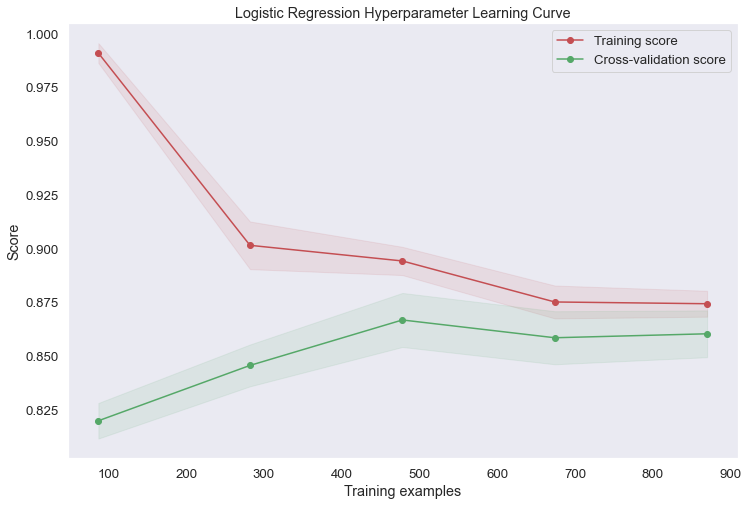

In [115]:
lr_hyper_model = gridsearch.best_estimator_
lr_hyper_model.fit(X_train, y_train)
lr_hyper_predict = lr_hyper_model.predict(X_test)

model_score(y_test, lr_predict)
plot_learning_curve(lr_best_model,
                    'Logistic Regression Learning Curve', X_train, y_train, cv=5)


model_score(y_test, lr_hyper_predict)
plot_learning_curve(lr_hyper_model,
                    'Logistic Regression Hyperparameter Learning Curve', X_train, y_train, cv=5)

- 트리기반의 모델들 보다는 뚜렷하게 나아진점이 보이진 않지만, 약하게 나마 Learning Curve도 좋아지는 모습을 보입니다.
- 또한, 성능도 좋은 수준입니다.

<br>

#### 7.3.4 중요 변수 확인

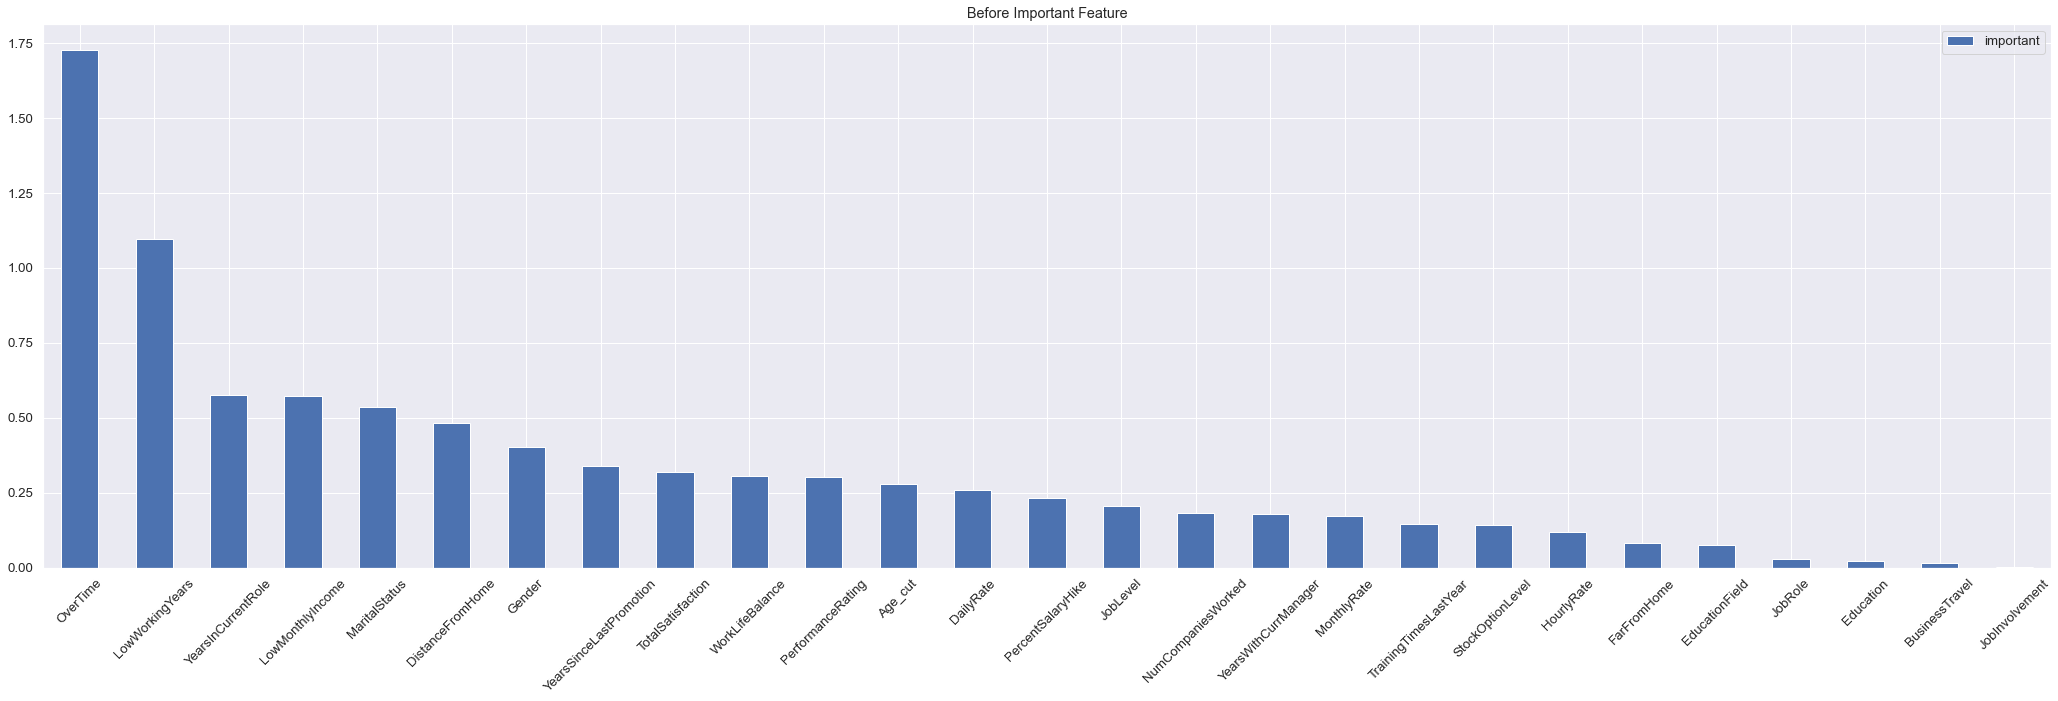

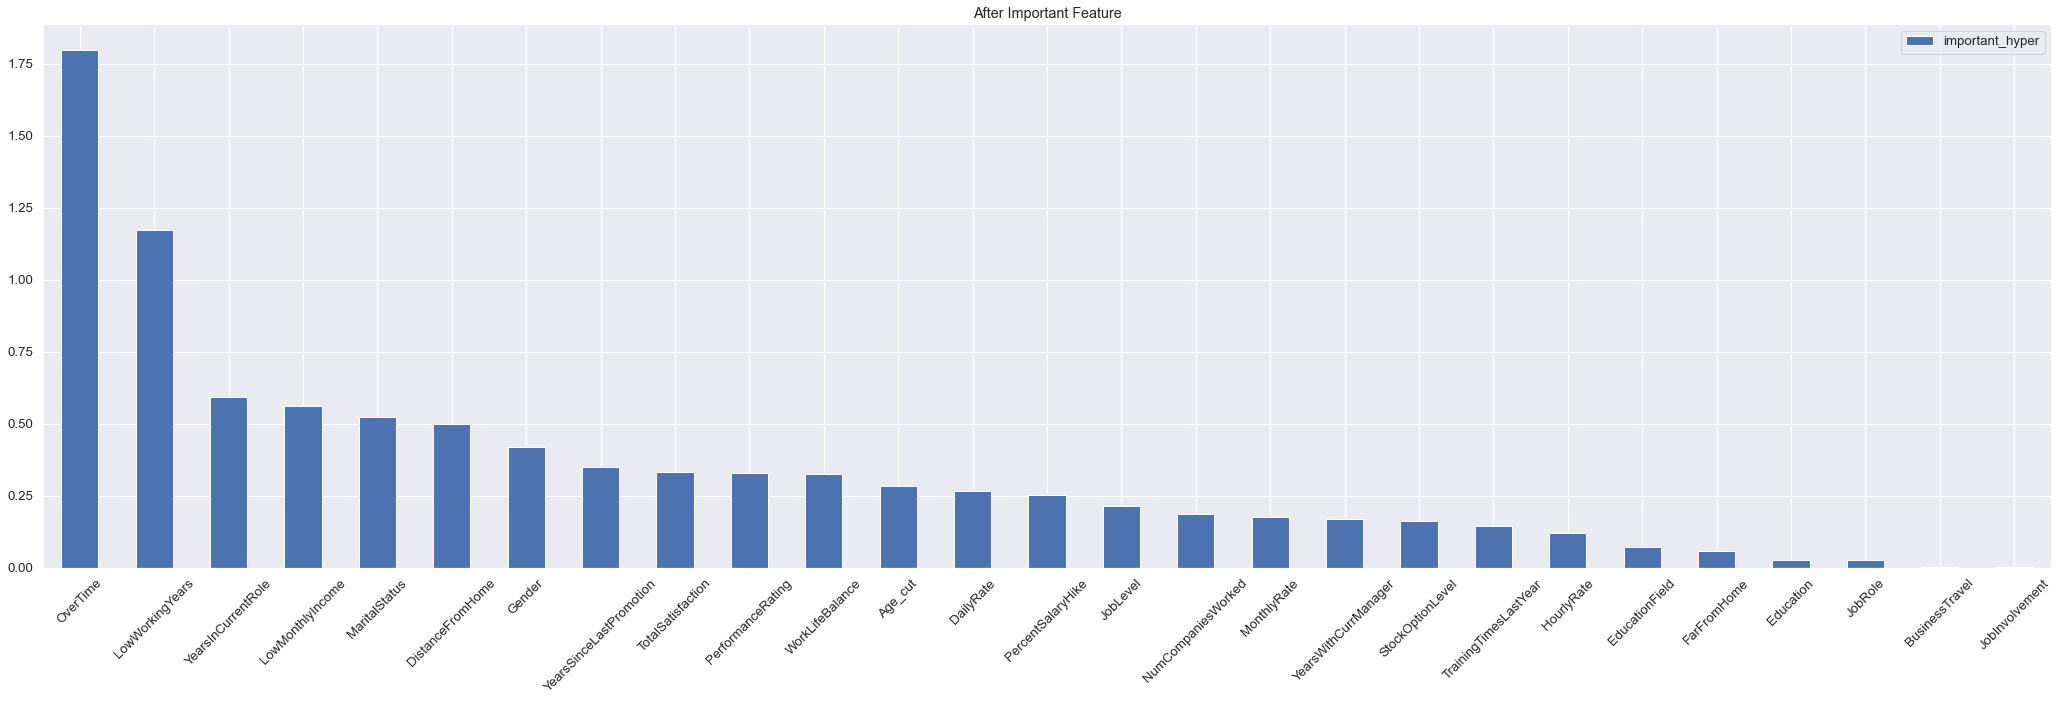

In [116]:
important = np.abs(lr_best_model.coef_[0])
important_hyper = np.abs(lr_hyper_model.coef_[0])
pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Before Important Feature')
pd.DataFrame(important_hyper, X_train.columns,columns=['important_hyper']).sort_values(by = 'important_hyper', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'After Important Feature')
plt.show()

- 중요한 변수를 확인해 보았습니다.
- 트리기반 모델들은 rate 계열의 컬럼을 중요하게 나왔는데, 회귀모델은 overtime이 중요하게 나옵니다.

<br>

### 7.4 XGBoost

#### 7.4.1 튜닝 모델 생성 및 학습

In [117]:
xgb_model = xgb.XGBClassifier(
    random_state=87, objective='binary:logistic', booster='gbtree')

params_grid = [{
    'n_estimators': list(range(10, 110, 10)), # 의사결정나무의 수
    'min_child_weight': list(range(5, 11, 2)), # 자식노드에서 관측되는 최소 가중치의 합
    'gamma': [0.1, 0.5, 0.7, 1, 1.3], # 트리의 노드에서 추가 파티션을 만들기 위해 필요한 최소 손실 감소. 크면 클수록 더 보수적인 알고리즘이 생성됨
    'max_depth': list(range(1, 11, 2)), # 얼마나 깊게 들어가는지

}]

gridsearch = GridSearchCV(
    estimator=xgb_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=87,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=Non

- 파라미터 튜닝을 하여 XGBoost를 생성합니다.
- 사용한 파라미터는 n_estimators, min_child_weight, gamma, max_depth 입니다.

<br>

#### 7.4.2 학습 결과 저장

In [118]:
result_hyper.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'hyper_mean_train_score': np.nanmean(gridsearch.cv_results_['mean_train_score']).astype(float),
           'hyper_mean_test_score': np.nanmean(gridsearch.cv_results_['mean_test_score']).astype(float)})

- 전체 모델에 대해 결과를 시각화하기 위해 결과 저장

<br>

#### 7.4.3 예측 및 검증

Accuracy :  0.883
Recall :  0.435
Precision :  0.769
F1_Score :  0.556

Confusion_matrix :
[[221   6]
 [ 26  20]]


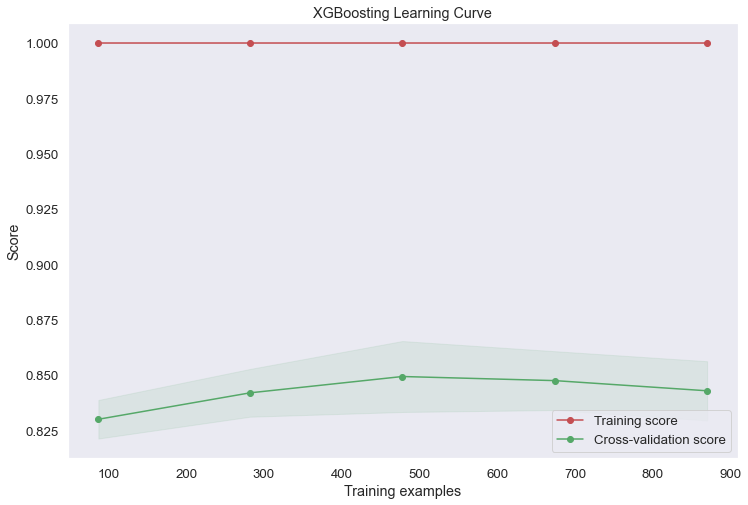

Accuracy :  0.886
Recall :  0.348
Precision :  0.941
F1_Score :  0.508

Confusion_matrix :
[[226   1]
 [ 30  16]]


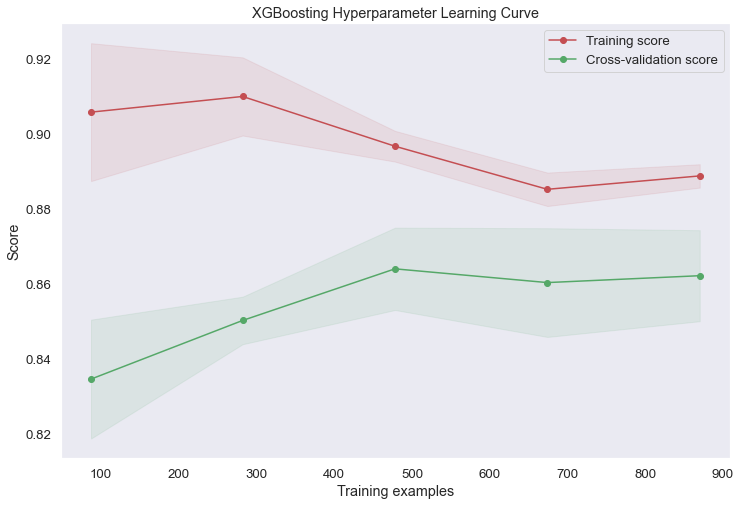

In [119]:
xgb_hyper_model = gridsearch.best_estimator_
xgb_hyper_model.fit(X_train, y_train)
xgb_hyper_predict = xgb_hyper_model.predict(X_test)

model_score(y_test, xgb_predict)
plot_learning_curve(xgb_best_model,
                    'XGBoosting Learning Curve', X_train, y_train, cv=5)


model_score(y_test, xgb_hyper_predict)
plot_learning_curve(xgb_hyper_model,
                    'XGBoosting Hyperparameter Learning Curve', X_train, y_train, cv=5)

- 파라미터를 사용하여 모델을 생성한 결과 많은 수치는 아니지만 꽤 좋은 성능을 내는 모델이 생성되었습니다.
- Recall의 점수는 떨어졌지만, Precision의 점수는 더욱 올라 F1-score가 좋아졌습니다.

<br>

#### 7.4.4 중요 변수 확인

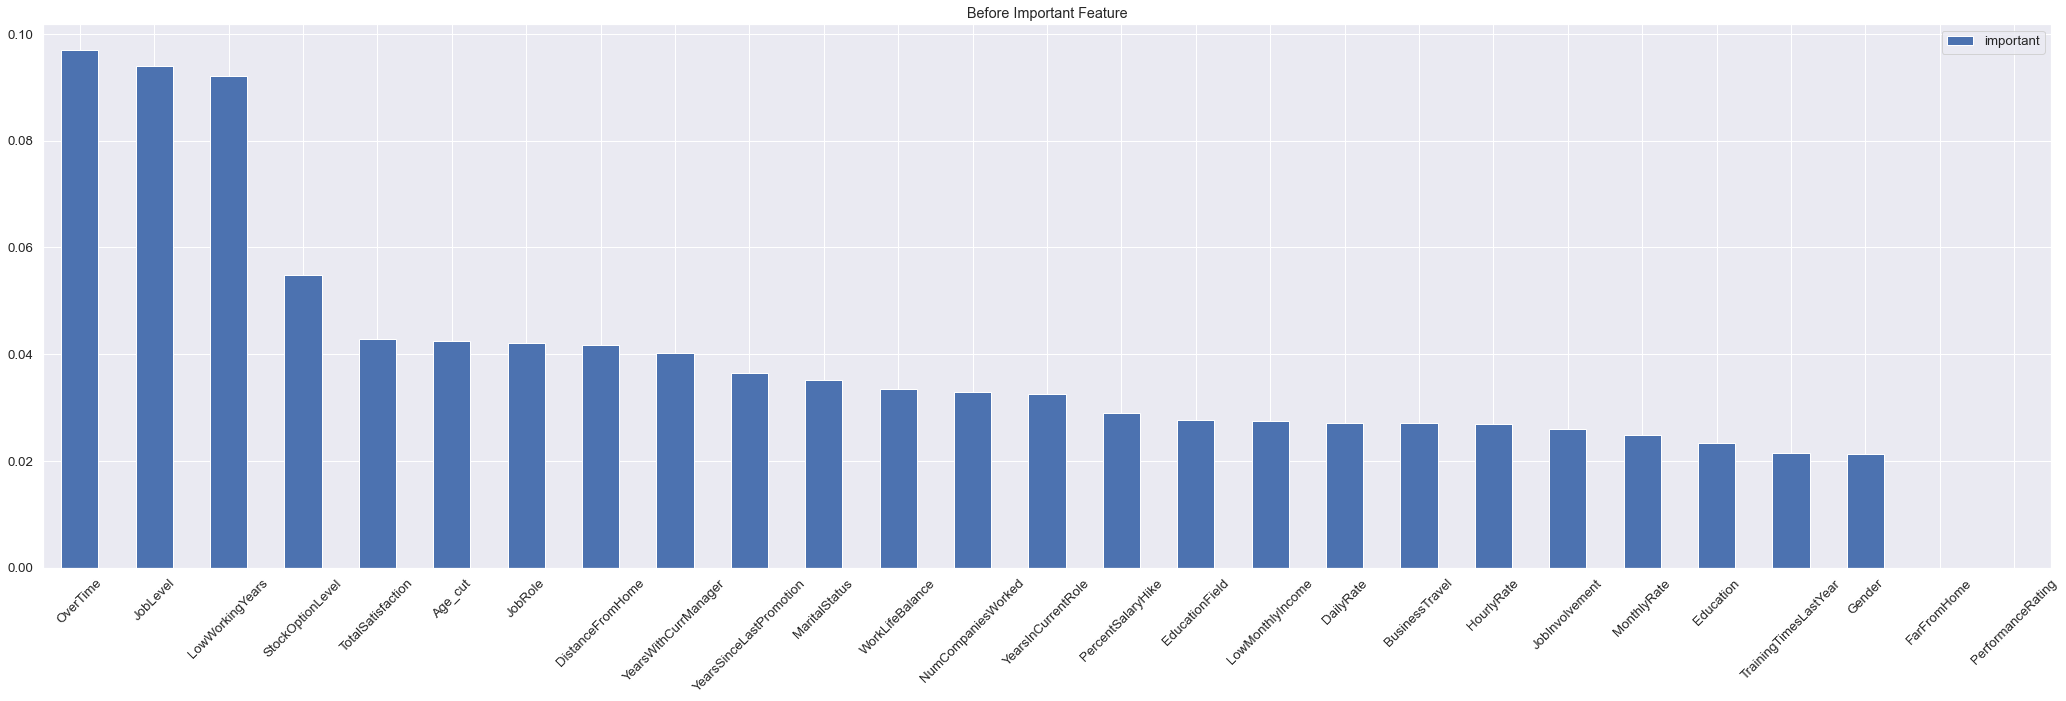

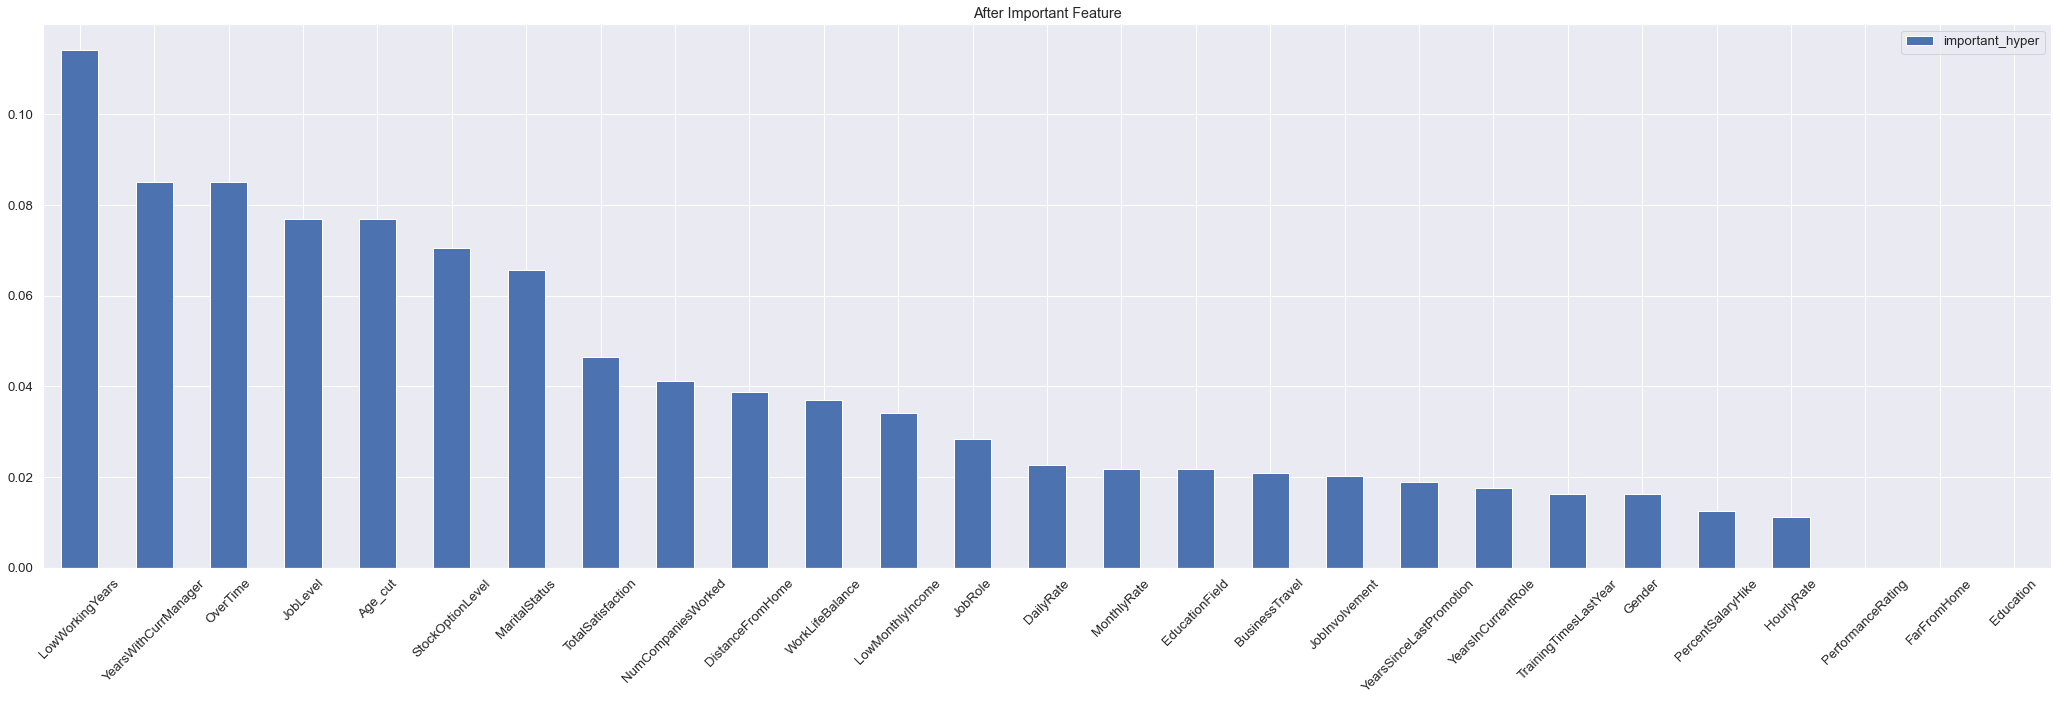

In [120]:
important = xgb_best_model.feature_importances_
important_hyper = xgb_hyper_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Before Important Feature')
pd.DataFrame(important_hyper, X_train.columns,columns=['important_hyper']).sort_values(by = 'important_hyper', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'After Important Feature')
plt.show()

- 파라미터를 튜닝하기 전과 후의 중요변수를 보면 YearWithCurrManager가 갑자기 상승하였습니다.

<br>

### 7.5 LightGBM

#### 7.5.1 튜닝 모델 생성 및 학습

In [121]:
lgbm_model = LGBMClassifier(random_state=87)

params_grid = [{
    'boosting_type': ['gbdt', 'dart', 'rf', 'goss'], # 알고리즘 타입
    'num_leaves': [5, 10, 20], # 잎사귀의 수
    'max_depth': [1, 2, 3, 4, 5, 7, 9, 11], # 깊이의 수
    'reg_alpha': [0.1, 0.5], # L1 정규화
    'lambda_l1': [0, 1, 1.5], # L1 정규화
    'lambda_l2': [0, 1, 1.5], # L2 정규화
}]

gridsearch = GridSearchCV(
    estimator=lgbm_model, param_grid=params_grid, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=87), n_jobs=-1,
             param_grid=[{'boosting_type': ['gbdt', 'dart', 'rf', 'goss'],
                          'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1, 1.5],
                          'max_depth': [1, 2, 3, 4, 5, 7, 9, 11],
                          'num_leaves': [5, 10, 20], 'reg_alpha': [0.1, 0.5]}],
             return_train_score=True)

- 그리드 서치를 이용하여 LightGBM의 파라미터를 튜닝 및 최적의 모델을 생성하였습니다.
- 파라미터는 boosting_type, num_leaves, max_depth, reg_alpha, lambda_l1, lambda_l2 를 사용했습니다.
- 아무래도 트리기반의 모델들은 depth가 중요한 파라미터인듯 합니다.

<Br>

#### 7.5.2 학습 결과 저장

In [122]:
result_hyper.append({'Estimator': str(gridsearch.best_estimator_).split('(')[0],
           'hyper_mean_train_score': np.nanmean(gridsearch.cv_results_['mean_train_score']).astype(float),
           'hyper_mean_test_score': np.nanmean(gridsearch.cv_results_['mean_test_score']).astype(float)})

- 전체 모델에 대한 결과를 시각화 하기 위해 결과를 저장합니다.

<br>

#### 7.5.3 예측 및 검증

Accuracy :  0.864
Recall :  0.348
Precision :  0.696
F1_Score :  0.464

Confusion_matrix :
[[220   7]
 [ 30  16]]


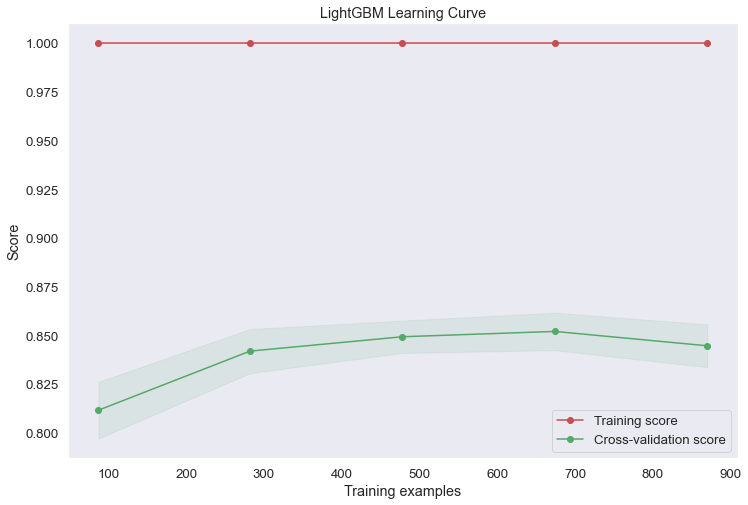

Accuracy :  0.861
Recall :  0.304
Precision :  0.7
F1_Score :  0.424

Confusion_matrix :
[[221   6]
 [ 32  14]]


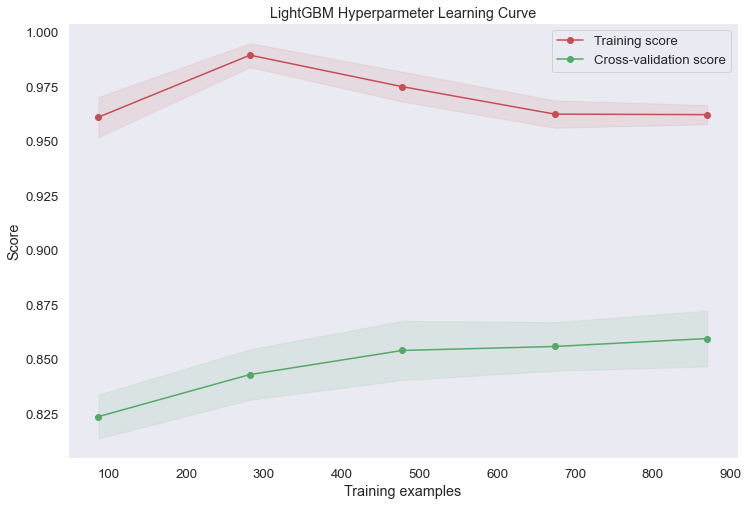

In [123]:
lgbm_hyper_model = gridsearch.best_estimator_
lgbm_hyper_model.fit(X_train, y_train)
lgbm_hyper_predict = lgbm_hyper_model.predict(X_test)

model_score(y_test, lgbm_predict)
plot_learning_curve(lgbm_best_model,
                    'LightGBM Learning Curve', X_train, y_train, cv=5)

model_score(y_test, lgbm_hyper_predict)
plot_learning_curve(lgbm_hyper_model,
                    'LightGBM Hyperparmeter Learning Curve', X_train, y_train, cv=5)

- 이번엔 튜닝을 하여도 성능이 좋아진것 같지 않습니다.
- Learning Curve만 보면 좋아진것 같지만, 그외의 다른것들의 점수가 다 낮아졌습니다.
- 사실 LGBM은 데이터가 적으면 큰 성능을 보이지 못합니다. 최소 데이터가 10000개는 있어야 한다고 합니다.

<br>

#### 7.5.4 중요 변수 확인

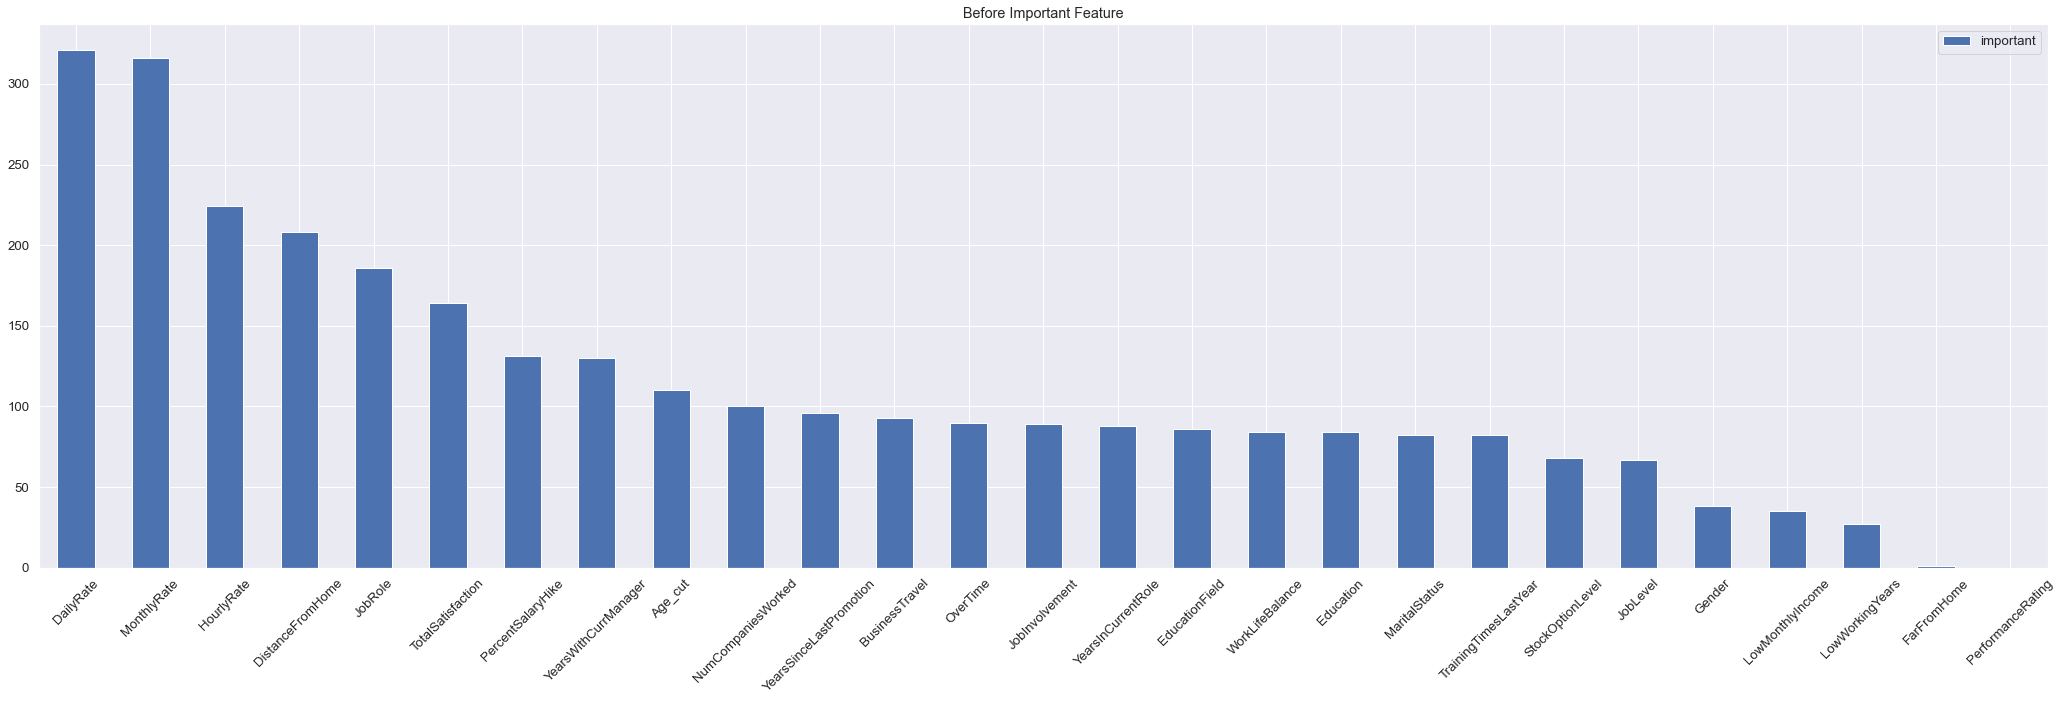

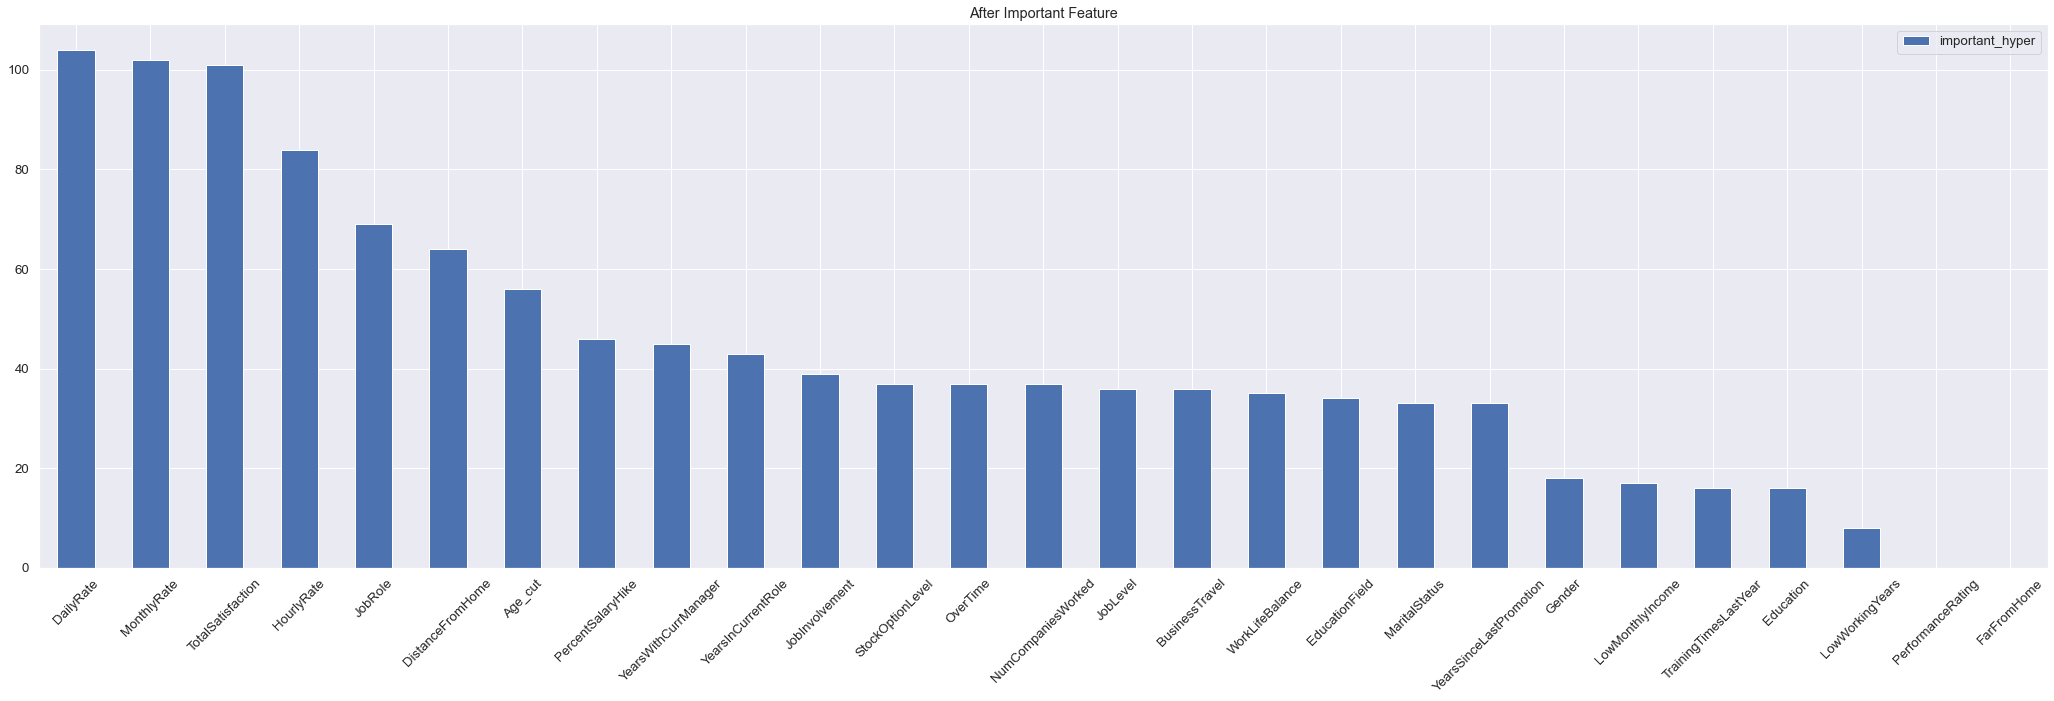

In [124]:
important = lgbm_best_model.feature_importances_
important_hyper = lgbm_hyper_model.feature_importances_

pd.DataFrame(important, X_train.columns,columns=['important']).sort_values(by = 'important', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'Before Important Feature')
pd.DataFrame(important_hyper, X_train.columns,columns=['important_hyper']).sort_values(by = 'important_hyper', ascending=False).plot(kind='bar', figsize = (36, 10), rot = 45, title = 'After Important Feature')
plt.show()

- 튜닝을 하여도 큰 변화가 없어서 그런지 중요변수도 크게 변화한것 같지 않습니다.
- 그대로 Rate 계열의 변수가 상위권에 있습니다.

<br>

### 7.6 ROC Curve, AUC

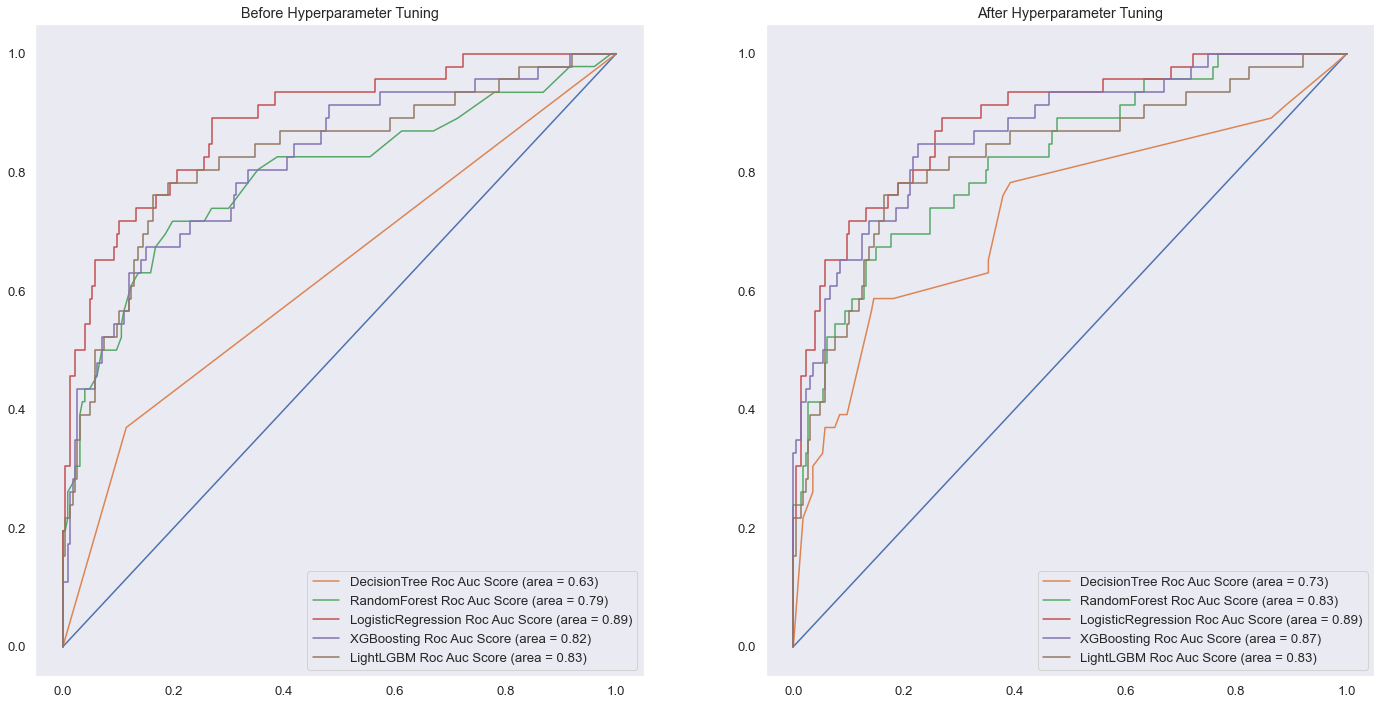

In [113]:
clf_pred_proba = clf_best_model.predict_proba(X_test)[:, 1]
clf_fpr, clf_tpr, thresholds = roc_curve(y_test, clf_pred_proba)
clf_roc_auc = roc_auc_score(y_test, clf_pred_proba)

clf_hyper_pred_proba = clf_hyper_model.predict_proba(X_test)[:, 1]
clf_hyper_fpr, clf_hyper_tpr, thresholds = roc_curve(y_test, clf_hyper_pred_proba)
clf_hyper_roc_auc = roc_auc_score(y_test, clf_hyper_pred_proba)

####

rf_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_pred_proba)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

rf_hyper_pred_proba = rf_hyper_model.predict_proba(X_test)[:, 1]
rf_hyper_fpr, rf_hyper_tpr, thresholds = roc_curve(y_test, rf_hyper_pred_proba)
rf_hyper_roc_auc = roc_auc_score(y_test, rf_hyper_pred_proba)

###

lr_pred_proba = lr_best_model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_pred_proba)
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba)

lr_hyper_pred_proba = lr_hyper_model.predict_proba(X_test)[:, 1]
lr_hyper_fpr, lr_hyper_tpr, thresholds = roc_curve(y_test, lr_hyper_pred_proba)
lr_hyper_roc_auc = roc_auc_score(y_test, lr_hyper_pred_proba)

###

xgb_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_pred_proba)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

xgb_hyper_pred_proba = xgb_hyper_model.predict_proba(X_test)[:, 1]
xgb_hyper_fpr, xgb_hyper_tpr, thresholds = roc_curve(y_test, xgb_hyper_pred_proba)
xgb_hyper_roc_auc = roc_auc_score(y_test, xgb_hyper_pred_proba)

###

lgbm_pred_proba = gridsearch.best_estimator_.predict_proba(X_test)[:, 1]
lgbm_fpr, lgbm_tpr, thresholds = roc_curve(y_test, lgbm_pred_proba)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_pred_proba)

lgbm_hyper_pred_proba = lgbm_hyper_model.predict_proba(X_test)[:, 1]
lgbm_hyper_fpr, lgbm_hyper_tpr, thresholds = roc_curve(y_test, lgbm_hyper_pred_proba)
lgbm_hyper_roc_auc = roc_auc_score(y_test, lgbm_hyper_pred_proba)



fig = plt.figure(figsize=(24,12))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot([0, 1], [0, 1])
ax1.plot(clf_fpr, clf_tpr,
         label='DecisionTree Roc Auc Score (area = %0.2f)' % clf_roc_auc)
ax1.plot(rf_fpr, rf_tpr,
         label='RandomForest Roc Auc Score (area = %0.2f)' % rf_roc_auc)
ax1.plot(lr_fpr, lr_tpr,
         label='LogisticRegression Roc Auc Score (area = %0.2f)' % lr_roc_auc)
ax1.plot(xgb_fpr, xgb_tpr,
         label='XGBoosting Roc Auc Score (area = %0.2f)' % xgb_roc_auc)
ax1.plot(lgbm_fpr, lgbm_tpr,
         label='LightLGBM Roc Auc Score (area = %0.2f)' % lgbm_roc_auc)
ax1.set_title('Before Hyperparameter Tuning')
ax1.grid()
ax1.legend(loc="lower right")

ax2.plot([0, 1], [0, 1])
ax2.plot(clf_hyper_fpr, clf_hyper_tpr,
         label='DecisionTree Roc Auc Score (area = %0.2f)' % clf_hyper_roc_auc)
ax2.plot(rf_hyper_fpr, rf_hyper_tpr,
         label='RandomForest Roc Auc Score (area = %0.2f)' % rf_hyper_roc_auc)
ax2.plot(lr_hyper_fpr, lr_hyper_tpr,
         label='LogisticRegression Roc Auc Score (area = %0.2f)' % lr_hyper_roc_auc)
ax2.plot(xgb_hyper_fpr, xgb_hyper_tpr,
         label='XGBoosting Roc Auc Score (area = %0.2f)' % xgb_hyper_roc_auc)
ax2.plot(lgbm_hyper_fpr, lgbm_hyper_tpr,
         label='LightLGBM Roc Auc Score (area = %0.2f)' % lgbm_hyper_roc_auc)
ax2.set_title('After Hyperparameter Tuning')
ax2.grid()
ax2.legend(loc="lower right")
plt.show()

- 파라미터 튜닝 후 전체적으로 성능이 좋아진것을 알수 있습니다.

<br>

#### 7.7 Validation Score 확인

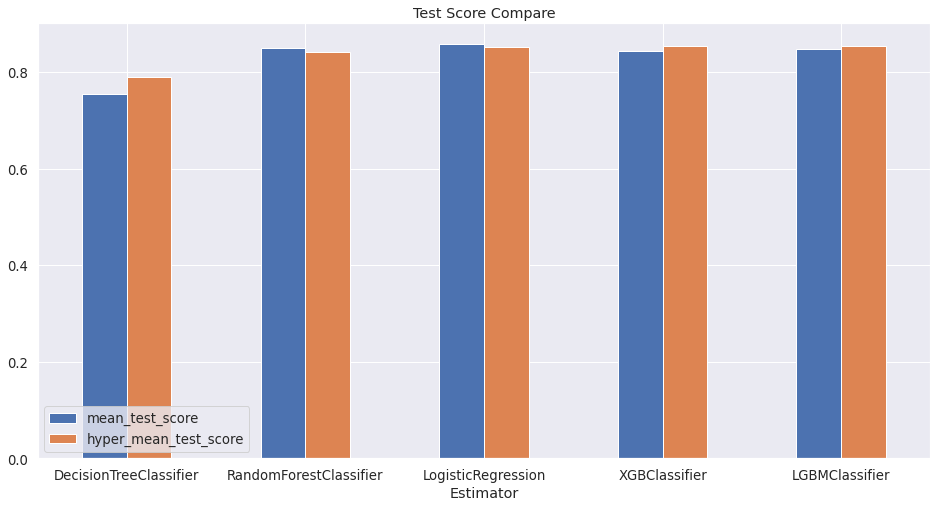

In [178]:
df = pd.DataFrame(result)
df2 = pd.DataFrame(result_hyper)
df = pd.merge(df, df2, on='Estimator')

df.plot.bar(x='Estimator', y=[
                   'mean_test_score', 'hyper_mean_test_score'], rot=360, figsize=(16, 8), title = 'Test Score Compare')
plt.legend(loc='lower left')
plt.show()

- 의사결정나무를 제외하고는 파라미터를 수정하여 Accuracy가 눈에띄게 좋아진것은 없습니다.
- 하지만 Accuracy만이 모델의 성능을 측정하는 지표는 아니며, Accuracy가 비슷하거나 조금 떨어졌지만, 그외의 지표들이 높아졌으니, 성능에 개선에 있었다고 이야기할수 있습니다.

<br>

## 8. 회고
---
### 8.1 회고

- 만일 데이터가 더 많았다면, 성능을 더 많이 올릴수 있을것 같았는데 아쉽습니다.
- 해당 내용에는 없지만 SMOTE를 사용하여 오버샘플링을 해보았지만, 오버샘플링의 단점인 과적합에 빠져, 오히려 검증시에는 성능이 안좋게 나왔습니다.
- 그래도 각 알고리즘별로 파라미터 튜닝을 실습해보고 했던것에 만족합니다.
- 많은 시간을 할애하여 진행했던 프로젝트지만 목표 Accuray는 0.9에 근접하게 나오긴 했지만 넘지는 못하여 아쉽습니다.
- 추후에 같은 데이터를 딥러닝에 적용하여 해봐야 겠습니다.
- 참조할 사이트 (https://tykimos.github.io/2017/08/13/Numerical_Input_Binary_Classification_Model_Recipe/)